# Import packages

In [1]:
# Import packages
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Add directory above current directory to path so we can import our pre-built package
import sys; sys.path.insert(0, '../..')
from entity_disambiguation.preprocessing import process_input, normalize_text

# Import NLP stopwords
# Ensure installation of nltk package in conda environment
from nltk.corpus import stopwords

# Import progress bar package
from tqdm import tqdm

In [2]:
try: 
    stop = stopwords.words('english')
except LookupError:
    # Download stopwords if it's your first time
    import nltk
    nltk.download('stopwords')

# Define helper functions

In [3]:
# Replace _ with " "
def replace_lines(text):
    return str(text).replace("_", " ")

In [5]:
# Replace " " with _
def add_lines(text):
    return str(text).replace(" ", "_")

## 1. Process Aida-Conll-Yago (ACY) dataset into train/test split

We can input two possibilities from ACY: (1) individual tokens (words) (2) full entity mentions. In processing the data, you can select which possibility you want to input using the match parameter of the process_input function.

In [6]:
# relative path to ACY dataset, should be the same for all users within `entity-disambiguation` repository
acy_path = '../../data/aida-conll-yago-dataset/'

# process_input() takes path location where you've stored AIDA-YAGO2-DATASET.tsv file
# Transforms tsv file into train, test split
# x are words, y are indices
train_x, train_y, test_x, test_y = process_input(acy_path, match="full_mention", train = 1.)

In [7]:
# Display shape of output train data
display((train_x.shape, train_y.shape))
display((test_x.shape, test_y.shape))

((22257, 2), (22257,))

((0, 2), (0,))

In [8]:
# Display x preview
train_x.head(10)

,full_mention,in_between_word_count
0,German,2
1,British,3
2,BRUSSELS,6
3,European Commission,3
4,European Commission,0
5,German,6
6,British,5
7,Germany,15
8,European Union,4
9,European Union,0


In [9]:
# Display y preview
train_y[0:3]

array(['11867', '31717', '3708'], dtype='<U8')

In [10]:
# Save train x/y into numpy arrays
x_np = train_x.full_mention.values
y_np = np.array(train_y, dtype = 'int64')

### Prepare normalized KWNLP

In [11]:
# Provide directory path for KWNLP data
# Should be same for all users of `entity-disambiguation` repository
kwnlp_path = '../../data/kwnlp'

# Load article data
article_df = pd.read_csv(os.path.join(kwnlp_path, 'kwnlp-enwiki-20200920-article.csv'))

# Load anchor target counts data
anchor_df = pd.read_csv(os.path.join(kwnlp_path, 'kwnlp-enwiki-20200920-anchor-target-counts.csv'))

In [12]:
# Display article preview
article_df.head()

,page_id,item_id,page_title,views,len_article_chars,len_intro_chars,in_link_count,out_link_count,tmpl_good_article,tmpl_featured_article,tmpl_pseudoscience,tmpl_conspiracy_theories,isa_Q17442446,isa_Q14795564,isa_Q18340514
0,12,6199,Anarchism,35558,40449,409,3826,371,1,0,0,0,0,0,0
1,25,38404,Autism,40081,47659,419,2313,309,0,1,0,0,0,0,0
2,39,101038,Albedo,10770,18766,293,3090,115,0,0,0,0,0,0,0
3,290,9659,A,29398,9538,609,173,149,0,0,0,0,0,0,0
4,303,173,Alabama,46680,74276,369,11864,744,0,0,0,0,0,0,0


In [13]:
# Display random sample of Wikipedia page titles
randints = np.random.randint(0, len(article_df), 10)
article_df.loc[randints, 'page_title']

599597                               Dabas
6189822    1998_Penn_Quakers_football_team
1667569                    Bryant_Bulldogs
2286200            Retrospektïẁ_(Part_III)
3382846                   Zachód,_Szczecin
1678729                    Porsche_LMP2000
217786                           Ristretto
1591071                 Ontario_Highway_72
6125142                      Peter_Bonello
994515                    Rigvedic_deities
Name: page_title, dtype: object

In [14]:
# Display anchor preview
anchor_df.head()

,anchor_text,target_page_id,count
0,United States,3434750,152451
1,World War II,32927,133668
2,India,14533,112069
3,France,5843419,109669
4,footballer,10568,101027


In [15]:
%%time
# Copy anchor_df to new dataframe
at_count_df = anchor_df.copy()

# Normalize anchor_text (lower-case, strip whitespace)
at_count_df["normalized_anchor_text"] = at_count_df["anchor_text"].apply(normalize_text)

# Return all anchor_texts that are non-zero, non-null
at_count_df = at_count_df.loc[at_count_df['normalized_anchor_text'].str.len() > 0, :]

print(len(at_count_df))
at_count_df.head(3)

15269229
CPU times: user 13.7 s, sys: 2.13 s, total: 15.8 s
Wall time: 16.1 s


,anchor_text,target_page_id,count,normalized_anchor_text
0,United States,3434750,152451,united states
1,World War II,32927,133668,world war ii
2,India,14533,112069,india


Inner join anchor-target data (mention to linked entity) with Wikipedia page article data. This lets us collate stats like page views with the target (entity) of mentions. Page views serves as another baseline model by selecting the page/entity that is most viewed for that anchor text.

In [16]:
%%time
# Merge at_count and article stats dataframes
at_count_df = pd.merge(
    at_count_df,
    article_df,
    how="inner",
    left_on="target_page_id",
    right_on="page_id")

# Rename columns for clarity
at_count_df = at_count_df.rename(columns={
    'title': 'target_page_title',
    'item_id': 'target_item_id',
    'views': 'target_page_views',
    'count': 'anchor_target_count',
    'page_title': 'target_page_title'})

# Specify column ordering
at_count_df = at_count_df[[
    "normalized_anchor_text",
    "target_page_id",
    "target_item_id",
    "target_page_title",
    "target_page_views",
    "anchor_target_count"]]

# Display preview
at_count_df.head(3)

CPU times: user 37.2 s, sys: 35.2 s, total: 1min 12s
Wall time: 1min 29s


,normalized_anchor_text,target_page_id,target_item_id,target_page_title,target_page_views,anchor_target_count
0,united states,3434750,30,United_States,460156,152451
1,american,3434750,30,United_States,460156,65722
2,usa,3434750,30,United_States,460156,8559


Drop NaNs. These have been encoded as `string` through the text normalisation previously.

In [17]:
# Drop NaNs
len_orig = len(at_count_df)
at_count_df = at_count_df.loc[at_count_df['normalized_anchor_text'] != 'nan']
print('Dropped rows:', len_orig - len(at_count_df))

Dropped rows: 3596


## Develop Wikipedia2Vec Model

We will create a normalized anchor text dataset from KWNLP. We will then use the pre-trained word embeddings provided via [Wikipedia2Vec](https://wikipedia2vec.github.io/wikipedia2vec/) to calculate a similarity score between a mention in ACY and a normalized anchor text in KWNLP.

We can try to apply word embedding similarities to two locations. The first is to move away from exact match joins between word token and anchor text and instead use a word similarity score. We would then use anchor link statistics to decide on an appropriate entity for disambiguation. The second is to compare word similarity directly between the token or full mention in ACY and the Wikipedia page title provided in the KWNLP.

In [18]:
# Import package
from wikipedia2vec import Wikipedia2Vec

In [19]:
%%time
# Load unzipped pkl file with word embeddings
wiki2vec = Wikipedia2Vec.load("../../embeddings/enwiki_20180420_100d.pkl")

CPU times: user 97.5 ms, sys: 163 ms, total: 260 ms
Wall time: 450 ms


# Retrieve Entities from Wikipedia2Vec

#### We want to test the success rate querying Wikipedia2Vec entities using KDNLP page titles. This should be an exact match since it is searching for an entity with the entity's title.

In [22]:
# Calculate success entity queries
success_rate = 0
queries = 0
failed_searches = []
for page in tqdm(article_df['page_title']):
    queries += 1
    entity =  wiki2vec.get_entity(str(page))
#     print(entity)
    if entity is not None:
        success_rate += 1
    else:
        failed_searches.append(page)
print("Success Rate: ", round(success_rate/queries*100, 3),"%")

100%|██████████| 6189965/6189965 [00:37<00:00, 164382.89it/s]

Success Rate:  4.232 %


In [23]:
# Preview failed queries
print("Failed Queries: ", failed_searches[:50])

Failed Queries:  ['Abraham_Lincoln', 'An_American_in_Paris', 'Academy_Award_for_Best_Production_Design', 'Academy_Awards', 'Animalia_(book)', 'International_Atomic_Time', 'Ayn_Rand', 'Alain_Connes', 'Allan_Dwan', 'List_of_Atlas_Shrugged_characters', 'Agricultural_science', 'Austin_(disambiguation)', 'Andre_Agassi', 'Austroasiatic_languages', 'Afroasiatic_languages', 'Arithmetic_mean', 'American_Football_Conference', 'Animal_Farm', 'Aldous_Huxley', 'Ada', 'Aberdeen_(disambiguation)', 'Analysis_of_variance', 'Appellate_procedure_in_the_United_States', 'Answer_(law)', 'Appellate_court', 'America_the_Beautiful', 'Assistive_technology', 'American_National_Standards_Institute', 'Argument_(disambiguation)', 'Apollo_11', 'Apollo_8', 'A_Modest_Proposal', 'Alkali_metal', 'Atomic_number', 'Affirming_the_consequent', 'Andrei_Tarkovsky', 'Animal_(disambiguation)', 'Articles_of_Confederation', 'Asia_Minor_(disambiguation)', 'Atlantic_Ocean', 'Arthur_Schopenhauer', 'Demographics_of_Angola', 'Politics

#### We see 4.23% success matching directly on Page Title but may see better success if we replace "_" with " " using our earlier function. It seems to work better if you search with spaces, like natural entry.

In [24]:
# Calculate success entity queries
success_rate = 0
queries = 0
failed_searches = []
for page in tqdm(article_df['page_title'].apply(replace_lines)):
    queries += 1
    entity =  wiki2vec.get_entity(str(page))
#     print(entity)
    if entity is not None:
        success_rate += 1
    else:
        failed_searches.append(page)
print("Success Rate: ", round(success_rate/queries*100, 3),"%")

100%|██████████| 6189965/6189965 [00:49<00:00, 125049.47it/s]

Success Rate:  39.111 %


In [25]:
# Preview failed queries
print("Failed Queries: ", failed_searches[:25])

Failed Queries:  ['Austin (disambiguation)', 'Ada', 'Aberdeen (disambiguation)', 'Argument (disambiguation)', 'Animal (disambiguation)', 'Asia Minor (disambiguation)', 'Atlas (disambiguation)', 'Asterism', 'Aztlan Underground', 'Altenberg', 'Arne Kaijser', 'AM', 'Abatement', "America's National Game", 'Atlantic (disambiguation)', 'APL', 'Athene (disambiguation)', 'Artistic revolution', 'Atomic', 'Asa', 'Telecommunications in Anguilla', 'Abduction', 'Ancylopoda', 'Anadyr (river)', 'ASIC (disambiguation)']


In [26]:
# How many are disambiguation pages
count=0
for i in failed_searches:
    if '(disambiguation)' in i:
        count+=1
round(count/len(failed_searches)*100, 2)

1.4

#### We see a 39% success rate matching on strings with spaces, but that still leaves ~3.4 million unmatched page titles.

Looking at failed searches like [Atomic](https://en.wikipedia.org/wiki/Atomic), [Asa](https://en.wikipedia.org/wiki/Asa), and [Abduction](https://en.wikipedia.org/wiki/Abduction), these terms go to disambiguation pages very frequently, even if disambiguation is only in the title ~1-2% of the time. They may not be fully indexed by Wikipedia2vec and thus not returned. The impact this will have on entity disambiguation is unknown.

# Use Wikipedia2Vec to Retrieve Entities from Words Directly

Wikipedia2vec can return the closest entities to any entered word. Let's see what kind of results are returned using its API.

In [27]:
# Import class to compare type against
from wikipedia2vec.dictionary import Entity

In [28]:
# Normalize full_mentions in x_np
# This is necessaryr in order for wiki2vec.get_word() to return results
x_np_norm = np.array([x.lower() if x is not None else x for x in x_np])
x_np_norm[:10]

array(['german', 'british', 'brussels', 'european commission',
       'european commission', 'german', 'british', 'germany',
       'european union', 'european union'], dtype='<U51')

In [29]:
# Test single x entity return

start_time = time.time()

# Print word
print("Search Word: ", x_np_norm[0])

# Get most similar word
count_similar = 100
similar = wiki2vec.most_similar(wiki2vec.get_word(str(x_np_norm[0])), count_similar)

# Retrieve only entities from word
entities = []
return_similar = 10
for i in similar:
#     print(type(i[0]))
    if isinstance(i[0], Entity):
        entities.append(i)
    if len(entities) == return_similar:
        break
end_time = time.time()
print(f"Single Word Query Time: {round(end_time - start_time, 2)}s")
display(entities)

Search Word:  german
Single Word Query Time: 15.2s


[(<Entity Culture of Germany>, 0.68680257),
 (<Entity 1860 in Germany>, 0.6840672),
 (<Entity 1866 in Germany>, 0.6836185),
 (<Entity Template:Focke-Wulf aircraft>, 0.68068546),
 (<Entity 1847 in Germany>, 0.680415),
 (<Entity File:Map-GermanConfederation.svg>, 0.67916125),
 (<Entity 1858 in Germany>, 0.6769093),
 (<Entity 1856 in Germany>, 0.67657095),
 (<Entity 1865 in Germany>, 0.6758945),
 (<Entity 1857 in Germany>, 0.67497927)]

In [111]:
# Measure how many similar words must be returned to retrieve a sufficient number of entities
word_returns = []
searches = np.arange(1,101)
randint = np.random.randint(len(np.unique(x_np_norm)))
print(randint)
domain = np.unique(x_np_norm)[randint:randint+5]

for word in domain:
    print(word)
    start_time = time.time()
    return_count = []
    for s in tqdm(searches):
#         print("word", word, "search for ", s)

        # Get most similar word
        count_similar = s
        similar = wiki2vec.most_similar(wiki2vec.get_word(str(word)), count_similar)

        # Retrieve only entities from word
        entities = 0
        return_similar = r
        for i in similar:
        #     print(type(i[0]))
            if isinstance(i[0], Entity):
                entities += 1
        return_count.append(entities)
    word_returns.append(return_count)
    end_time = time.time()
    print(f"Single Search Query Time: {round(end_time - start_time, 2)}s")

word german search for  1
word german search for  2
word german search for  3
word german search for  4
word german search for  5
word german search for  6
word german search for  7
word german search for  8
word german search for  9
word german search for  10
word german search for  11
word german search for  12
word german search for  13
word german search for  14
word german search for  15
word german search for  16
word german search for  17
word german search for  18
word german search for  19
word german search for  20
word german search for  21
word german search for  22
word german search for  23
word german search for  24
word german search for  25
word german search for  26
word german search for  27
word german search for  28
word german search for  29
word german search for  30
word german search for  31
word german search for  32
word german search for  33
word german search for  34
word german search for  35
word german search for  36
word german search for  37
word germa

word brussels search for  93
word brussels search for  94
word brussels search for  95
word brussels search for  96
word brussels search for  97
word brussels search for  98
word brussels search for  99
word brussels search for  100
Single Search Query Time: 313.89s
word european commission search for  1
word european commission search for  2
word european commission search for  3
word european commission search for  4
word european commission search for  5
word european commission search for  6
word european commission search for  7
word european commission search for  8
word european commission search for  9
word european commission search for  10
word european commission search for  11
word european commission search for  12
word european commission search for  13
word european commission search for  14
word european commission search for  15
word european commission search for  16
word european commission search for  17
word european commission search for  18
word european commissi

word european commission search for  99
word european commission search for  100
Single Search Query Time: 289.64s


In [113]:
print(f"Single Search Query Time: {round(end_time - start_time, 2)}s")

Single Search Query Time: 289.64s


From the below distribution, we should return at least 50 most similar objects in order to hit a list of Top 5 returned.

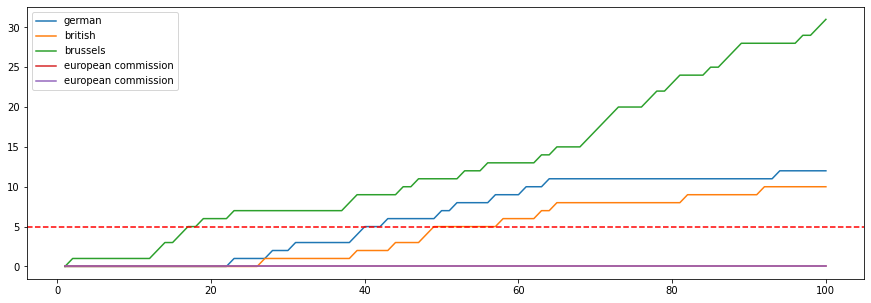

In [118]:
plt.figure(figsize=(15,5))
for w in range(len(domain)):
    plt.plot(searches, word_returns[w], label=domain[w])
plt.axhline(5, color='red', ls='--')
plt.legend()
plt.show()

From here, we can match returned entities and their title to page_title in article_df, then to page_id.

In [165]:
p = wiki2vec.get_entity("Culture of Germany")
print(p.title, p.index, p.count, p.doc_count)

Culture of Germany 4126950 143 142


In [164]:
article_df[article_df['page_title'] == 'Culture_of_Germany']

,page_id,item_id,page_title,views,len_article_chars,len_intro_chars,in_link_count,out_link_count,tmpl_good_article,tmpl_featured_article,tmpl_pseudoscience,tmpl_conspiracy_theories,isa_Q17442446,isa_Q14795564,isa_Q18340514
371385,1195868,1979615,Culture_of_Germany,2428,24914,227,167,482,0,0,0,0,0,0,0


Now, we develop an algorithm that returns the most likely entity matched from Wikipedia2Vec and uses that to get the page_id.

In [137]:
# Maximum set size
len(x_np_norm)

17805

In [220]:
# Specify how large of a set you want to run
size = 1780

In [221]:
%%time

most_similar_entities = []

for mention in tqdm(x_np_norm[:size]):
    
    # Retrieve w2v word from mention
    word = wiki2vec.get_word(str(mention))
    
    # Retrieve 50 most similar to ensure at least one entity returned
    similars = wiki2vec.most_similar(word, 50)
    
    # Retrieve most similar entity
    most_similar = None
    for s in similars:
        if isinstance(s[0], Entity):
            most_similar = s
        if most_similar is not None:
            break
    
    # Save most similar
    most_similar_entities.append(most_similar)

  0%|          | 2/1780 [00:09<2:22:53,  4.82s/it]


KeyboardInterrupt: 

In [95]:
# Preview most similar list
most_similar_entities[:10]

[(<Entity Culture of Germany>, 0.68680257),
 (<Entity Russians in the United Kingdom>, 0.6155642),
 (<Entity Brussels>, 0.8870699),
 None,
 None,
 (<Entity Culture of Germany>, 0.68680257),
 (<Entity Russians in the United Kingdom>, 0.6155642),
 (<Entity Germany>, 0.7371232),
 None,
 None]

In [149]:
# Display full mention and most similar
preds_wiki2vec = pd.DataFrame({
    'mention': x_np[:size],
    'match': [s[0].title if s is not None else None for s in most_similar_entities],
    'similarity_score': [s[1] if s is not None else None for s in most_similar_entities],
    'entity_page_id': None,
    'target_page_title': None
})
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,Culture of Germany,0.686803,None,None
1,British,Russians in the United Kingdom,0.615564,None,None
2,BRUSSELS,Brussels,0.887070,None,None
3,European Commission,None,NaN,None,None
4,European Commission,None,NaN,None,None
...,...,...,...,...,...
95,Opel AG,None,NaN,None,None
96,Opel AG,None,NaN,None,None
97,General Motors,None,NaN,None,None
98,General Motors,None,NaN,None,None


In [150]:
article_df[article_df['page_id'] == 7152417][['page_id', 'page_title']].values

array([[7152417, 'None']], dtype=object)

In [151]:
# Update with entity_page_id, target_page_title after updating match to have _ instead of " " todo 
for i in tqdm(range(len(preds_wiki2vec))):
    try:
        preds_wiki2vec.iloc[i, 3:5] = article_df[article_df['page_title'] == add_lines(preds_wiki2vec.iloc[i,1])][['page_id', 'page_title']].values[0]
    except:
        # Leave at default None values
        continue

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


In [152]:
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,Culture of Germany,0.686803,1195868,Culture_of_Germany
1,British,Russians in the United Kingdom,0.615564,9808786,Russians_in_the_United_Kingdom
2,BRUSSELS,Brussels,0.887070,3708,Brussels
3,European Commission,None,NaN,7152417,None
4,European Commission,None,NaN,7152417,None
...,...,...,...,...,...
95,Opel AG,None,NaN,7152417,None
96,Opel AG,None,NaN,7152417,None
97,General Motors,None,NaN,7152417,None
98,General Motors,None,NaN,7152417,None


In [153]:
# Accuracy matching full mention with anchor text
print('-- Accuracy on entire ACY dataset using KWNLP --')
print('Wikipedia2vec most_similar(): {}%'.format(np.round(100*np.mean(preds_wiki2vec.entity_page_id == y_np[:size]), 2)))
# print('Page Views: {}%'.format(np.round(100*np.mean(preds_page.entity_page_id == y_np), 2)))

-- Accuracy on entire ACY dataset using KWNLP --
Wikipedia2vec most_similar(): 34.0%


If we filter our prediction dataframe, we can see the real problem. wiki2vec struggles when entering multi-word text into the get_word solution. This may be where we can combine with our earlier tests for directly getting the entry to see what we score.

In [154]:
# Display filtered dataframe
preds_wiki2vec[preds_wiki2vec['mention'].str.split(" ").apply(len) >= 2].head(10)

,mention,match,similarity_score,entity_page_id,target_page_title
3,European Commission,None,NaN,7152417,None
4,European Commission,None,NaN,7152417,None
8,European Union,None,NaN,7152417,None
9,European Union,None,NaN,7152417,None
12,European Union,None,NaN,7152417,None
13,European Union,None,NaN,7152417,None
14,Franz Fischler,None,NaN,7152417,None
15,Franz Fischler,None,NaN,7152417,None
20,Loyola de Palacio,None,NaN,7152417,None
21,Loyola de Palacio,None,NaN,7152417,None


In [157]:
# For all non-matched items, try to retrieve the entity directly
for i in tqdm(range(len(preds_wiki2vec))):
    if preds_wiki2vec.iloc[i]['match'] == None:
        entity = wiki2vec.get_entity(preds_wiki2vec.iloc[i]['mention'])
        if entity is not None:
            preds_wiki2vec.iloc[i, 1:3] = entity.title, 1.0

100%|██████████| 100/100 [00:00<00:00, 2880.62it/s]


In [159]:
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,Culture of Germany,0.686803,1195868,Culture_of_Germany
1,British,Russians in the United Kingdom,0.615564,9808786,Russians_in_the_United_Kingdom
2,BRUSSELS,Brussels,0.887070,3708,Brussels
3,European Commission,European Commission,1.000000,7152417,None
4,European Commission,European Commission,1.000000,7152417,None
...,...,...,...,...,...
95,Opel AG,Opel,1.000000,7152417,None
96,Opel AG,Opel,1.000000,7152417,None
97,General Motors,General Motors,1.000000,7152417,None
98,General Motors,General Motors,1.000000,7152417,None


In [160]:
# Update with entity_page_id, target_page_title after updating match to have _ instead of " " todo 
for i in tqdm(range(len(preds_wiki2vec))):
    try:
        preds_wiki2vec.iloc[i, 3:5] = article_df[article_df['page_title'] == add_lines(preds_wiki2vec.iloc[i,1])][['page_id', 'page_title']].values[0]
    except:
        # Leave at default None values
        continue

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


In [161]:
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,Culture of Germany,0.686803,1195868,Culture_of_Germany
1,British,Russians in the United Kingdom,0.615564,9808786,Russians_in_the_United_Kingdom
2,BRUSSELS,Brussels,0.887070,3708,Brussels
3,European Commission,European Commission,1.000000,9974,European_Commission
4,European Commission,European Commission,1.000000,9974,European_Commission
...,...,...,...,...,...
95,Opel AG,Opel,1.000000,22284,Opel
96,Opel AG,Opel,1.000000,22284,Opel
97,General Motors,General Motors,1.000000,12102,General_Motors
98,General Motors,General Motors,1.000000,12102,General_Motors


In [162]:
# Accuracy matching full mention with anchor text
print('-- Accuracy on entire ACY dataset using KWNLP --')
print('Wikipedia2vec most_similar(): {}%'.format(np.round(100*np.mean(preds_wiki2vec.entity_page_id == y_np[:size]), 2)))
# print('Page Views: {}%'.format(np.round(100*np.mean(preds_page.entity_page_id == y_np), 2)))

-- Accuracy on entire ACY dataset using KWNLP --
Wikipedia2vec most_similar(): 65.0%


In [165]:
display(preds_wiki2vec[10:20])

,mention,match,similarity_score,entity_page_id,target_page_title
10,Britain,Synchronized swimming at the 2012 Summer Olymp...,0.705516,None,None
11,Commission,None,NaN,7152417,None
12,European Union,European Union,1.000000,9317,European_Union
13,European Union,European Union,1.000000,9317,European_Union
14,Franz Fischler,Franz Fischler,1.000000,626779,Franz_Fischler
15,Franz Fischler,Franz Fischler,1.000000,626779,Franz_Fischler
16,Britain,Synchronized swimming at the 2012 Summer Olymp...,0.705516,None,None
17,France,Sailing at the 1900 Summer Olympics – 10 to 20...,0.738717,None,None
18,BSE,Metropolitan Stock Exchange,0.661101,55179731,Metropolitan_Stock_Exchange
19,Spanish,Hispanic America,0.726539,452104,Hispanic_America


#### Interestingly, we see some mentions that might actually be more successful if we swapped our ordering. Let's use get_entity() first and then fill it out with most_similar.

In [222]:
# Display full mention and most similar
preds_wiki2vec = pd.DataFrame({
    'mention': x_np[:size],
    'match': None,
    'similarity_score': None,
    'entity_page_id': None,
    'target_page_title': None
})
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,None,None,None,None
1,British,None,None,None,None
2,BRUSSELS,None,None,None,None
3,European Commission,None,None,None,None
4,European Commission,None,None,None,None
...,...,...,...,...,...
1775,TEXAS,None,None,None,None
1776,INDIANS,None,None,None,None
1777,CLEVELAND,None,None,None,None
1778,Rusty Greer,None,None,None,None


In [223]:
# For all non-matched items, try to retrieve the entity directly
for i in tqdm(range(len(preds_wiki2vec))):
    if preds_wiki2vec.iloc[i]['match'] == None:
        entity = wiki2vec.get_entity(preds_wiki2vec.iloc[i]['mention'])
        if entity is not None:
            preds_wiki2vec.iloc[i, 1:3] = entity.title, 1.0

100%|██████████| 1780/1780 [00:00<00:00, 1810.53it/s]


In [224]:
# Update with entity_page_id, target_page_title after updating match to have _ instead of " " todo 
for i in tqdm(range(len(preds_wiki2vec))):
    try:
        preds_wiki2vec.iloc[i, 3:5] = article_df[article_df['page_title'] == add_lines(preds_wiki2vec.iloc[i,1])][['page_id', 'page_title']].values[0]
    except:
        # Leave at default None values
        continue

100%|██████████| 1780/1780 [08:51<00:00,  3.35it/s]


In [225]:
# Accuracy matching full mention with anchor text
print('-- Accuracy on entire ACY dataset using KWNLP --')
print('Wikipedia2vec most_similar(): {}%'.format(np.round(100*np.mean(preds_wiki2vec.entity_page_id == y_np[:size]), 2)))
# print('Page Views: {}%'.format(np.round(100*np.mean(preds_page.entity_page_id == y_np), 2)))

-- Accuracy on entire ACY dataset using KWNLP --
Wikipedia2vec most_similar(): 63.48%


In [226]:
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,None,None,7152417,None
1,British,None,None,7152417,None
2,BRUSSELS,None,None,7152417,None
3,European Commission,European Commission,1,9974,European_Commission
4,European Commission,European Commission,1,9974,European_Commission
...,...,...,...,...,...
1775,TEXAS,None,None,7152417,None
1776,INDIANS,None,None,7152417,None
1777,CLEVELAND,None,None,7152417,None
1778,Rusty Greer,Rusty Greer,1,2070208,Rusty_Greer


#### And now we fill out with most_similar()

In [227]:
%%time

most_similar_entities = []

for i in tqdm(range(len(preds_wiki2vec))):
#     print(preds_wiki2vec.iloc[i]['match'])
    if preds_wiki2vec.iloc[i]['match'] == None:
    
#         # Retrieve w2v word from mention
#         print("word", preds_wiki2vec.iloc[i]['mention'].lower())
        word = wiki2vec.get_word(preds_wiki2vec.iloc[i]['mention'].lower())
#         print("Word:", word)

        # Retrieve 50 most similar to ensure at least one entity returned
        similars = wiki2vec.most_similar(word, 50)
#         print(similars)

        # Retrieve most similar entity
        most_similar = None
        for s in similars:
#             print(s)
            if isinstance(s[0], Entity):
                most_similar = s
            if most_similar is not None:
                break
#         print(most_similar)
        
        # Save most similar into predictions dataframe
        try:
            preds_wiki2vec.iloc[i, 1:3] = most_similar[0].title, most_similar[1]
        except TypeError:
            continue

100%|██████████| 1780/1780 [23:23<00:00,  1.27it/s] 

CPU times: user 21min 48s, sys: 7min 54s, total: 29min 42s
Wall time: 23min 23s


In [228]:
display(preds_wiki2vec)

,mention,match,similarity_score,entity_page_id,target_page_title
0,German,Culture of Germany,0.686803,7152417,None
1,British,Russians in the United Kingdom,0.615564,7152417,None
2,BRUSSELS,Brussels,0.88707,7152417,None
3,European Commission,European Commission,1,9974,European_Commission
4,European Commission,European Commission,1,9974,European_Commission
...,...,...,...,...,...
1775,TEXAS,Texas,0.855106,7152417,None
1776,INDIANS,None,None,7152417,None
1777,CLEVELAND,Cleveland,0.780858,7152417,None
1778,Rusty Greer,Rusty Greer,1,2070208,Rusty_Greer


In [229]:
# Update with entity_page_id, target_page_title after updating match to have _ instead of " " todo 
for i in tqdm(range(len(preds_wiki2vec))):
    try:
        preds_wiki2vec.iloc[i, 3:5] = article_df[article_df['page_title'] == add_lines(preds_wiki2vec.iloc[i,1])][['page_id', 'page_title']].values[0]
    except:
        # Leave at default None values
        continue

100%|██████████| 1780/1780 [09:03<00:00,  3.27it/s]


In [237]:
# Accuracy matching full mention with anchor text
print('-- Accuracy on entire ACY dataset using KWNLP --')
print('Wikipedia2vec most_similar(): {}%'.format(np.round(100*np.mean(preds_wiki2vec.entity_page_id == y_np[:size]), 2)))
# print('Page Views: {}%'.format(np.round(100*np.mean(preds_page.entity_page_id == y_np), 2)))

-- Accuracy on entire ACY dataset using KWNLP --
Wikipedia2vec most_similar(): 67.08%


In [239]:
display(preds_wiki2vec[40:50])

,mention,match,similarity_score,entity_page_id,target_page_title
40,Hendrix,Jimi Hendrix,1,16095,Jimi_Hendrix
41,London,London,1,17867,London
42,English,William Bullokar,0.677979,1797414,William_Bullokar
43,Nottingham,Nottingham,1,39470,Nottingham
44,Hendrix,Jimi Hendrix,1,16095,Jimi_Hendrix
45,Hendrix,Jimi Hendrix,1,16095,Jimi_Hendrix
46,Australian,Australians,1,11197621,Australians
47,China,China,1,5405,China
48,Taiwan,Taiwan,1,25734,Taiwan
49,BEIJING,Beijing,0.893827,18603746,Beijing


#### We only see a 4% improvement. Is the right result somewhere within the top couple of results?

In [213]:
word = wiki2vec.get_word('german')
similar = wiki2vec.most_similar(word, 100)
entities = []
for i in similar:
    if isinstance(i[0], Entity):
        entities.append(i)
entities

[(<Entity Culture of Germany>, 0.68680257),
 (<Entity 1860 in Germany>, 0.6840672),
 (<Entity 1866 in Germany>, 0.6836185),
 (<Entity Template:Focke-Wulf aircraft>, 0.68068546),
 (<Entity 1847 in Germany>, 0.680415),
 (<Entity File:Map-GermanConfederation.svg>, 0.67916125),
 (<Entity 1858 in Germany>, 0.6769093),
 (<Entity 1856 in Germany>, 0.67657095),
 (<Entity 1865 in Germany>, 0.6758945),
 (<Entity 1857 in Germany>, 0.67497927),
 (<Entity Handrij Zejler>, 0.672897),
 (<Entity 1864 in Germany>, 0.6659955)]

In [214]:
word = wiki2vec.get_word('british')
similar = wiki2vec.most_similar(word, 100)
entities = []
for i in similar:
    if isinstance(i[0], Entity):
        entities.append(i)
entities

[(<Entity Russians in the United Kingdom>, 0.6155642),
 (<Entity Henry Wood (naval officer)>, 0.60587233),
 (<Entity D.N. Penfold>, 0.6025652),
 (<Entity Christopher J. Burgess>, 0.5973172),
 (<Entity Commonwealth of Nations>, 0.59682524),
 (<Entity British Empire>, 0.59353995),
 (<Entity File:Flag of The Commonwealth.svg>, 0.59272784),
 (<Entity Dial 999 (1938 film)>, 0.592148),
 (<Entity Black British>, 0.58818066),
 (<Entity Numa François Henri Sadoul>, 0.5852482)]

In [219]:
word = wiki2vec.get_word('chinese')
similar = wiki2vec.most_similar(word, 100)
entities = []
for i in similar:
    if isinstance(i[0], Entity):
        entities.append(i)
entities

[(<Entity Old Southwestern Chinese>, 0.73234856),
 (<Entity Han Chinese>, 0.7310837)]

#### It is in particular struggling to associate a description of a nation's people with that nation itself. Thus, we need congruence!

# TRASH

In [17]:
# Experiment with returning words from full mentions
for word in x_np[:5]:
    print("Full Mention: ", word)
    found_word = wiki2vec.get_word(word)
    print("Found Word: ", found_word)
    if found_word is None:
        continue
    else:
        start_time = time.time()
        similar_word = wiki2vec.most_similar(wiki2vec.get_word(word), 5)
        end_time = time.time()
        total_time = round(end_time - start_time, 2)
        print("Similar Word: ", similar_word)
        print("Time: ", total_time)
    print("**************************")
    

Full Mention:  German
Found Word:  None
Full Mention:  British
Found Word:  None
Full Mention:  BRUSSELS
Found Word:  None
Full Mention:  European Commission
Found Word:  None
Full Mention:  European Commission
Found Word:  None


In [26]:
# Experiment with returning words from full mentions lower-cased
for word in x_np[:5]:
    print("Full Mention: ", word.lower())
    found_word = wiki2vec.get_word(word.lower())
    print("Found Word: ", found_word)
    if found_word is None:
        continue
    else:
        start_time = time.time()
        similar_word = wiki2vec.most_similar(wiki2vec.get_word(word.lower()), 5)
        end_time = time.time()
        total_time = round(end_time - start_time, 2)
        print("Similar Word: ", similar_word)
        print("Time: ", total_time)
    print("**************************")
    

Full Mention:  german
Found Word:  <Word german>
Similar Word:  [(<Word german>, 0.9999999), (<Word austrian>, 0.78725725), (<Word scharfschütze>, 0.7308491), (<Word badeners>, 0.7266695), (<Word bavarian>, 0.7198452)]
Time:  3.33
**************************
Full Mention:  british
Found Word:  <Word british>
Similar Word:  [(<Word british>, 1.0), (<Word canadian>, 0.67067295), (<Word britiah>, 0.6659233), (<Word bccss>, 0.6586777), (<Word indian>, 0.6507589)]
Time:  3.53
**************************
Full Mention:  brussels
Found Word:  <Word brussels>
Similar Word:  [(<Word brussels>, 1.0), (<Entity Brussels>, 0.8870699), (<Word ghent>, 0.8244215), (<Word bruges>, 0.8157395), (<Word brussel>, 0.80919355)]
Time:  3.26
**************************
Full Mention:  european commission
Found Word:  None
Full Mention:  european commission
Found Word:  None


In [18]:
# Experiment with returning words from full mentions
for word in x_np[:5]:
    print("Full Mention: ", word)
    found_word = wiki2vec.get_entity(word)
    print("Found Word: ", found_word)
    if found_word is None:
        continue
    else:
        start_time = time.time()
        similar_word = wiki2vec.most_similar(wiki2vec.get_entity(word), 5)
        end_time = time.time()
        total_time = round(end_time - start_time, 2)
        print("Similar Word: ", similar_word)
        print("Time: ", total_time)
    print("**************************")
    

Full Mention:  German
Found Word:  None
Full Mention:  British
Found Word:  None
Full Mention:  BRUSSELS
Found Word:  None
Full Mention:  European Commission
Found Word:  <Entity European Commission>
Similar Word:  [(<Entity European Commission>, 0.99999994), (<Entity European Union>, 0.79579794), (<Entity European Council>, 0.7832253), (<Entity Directorate-General for Research and Innovation (European Commission)>, 0.7746816), (<Entity Directorate-General for Informatics>, 0.7597976)]
Time:  22.96
**************************
Full Mention:  European Commission
Found Word:  <Entity European Commission>
Similar Word:  [(<Entity European Commission>, 0.99999994), (<Entity European Union>, 0.79579794), (<Entity European Council>, 0.7832253), (<Entity Directorate-General for Research and Innovation (European Commission)>, 0.7746816), (<Entity Directorate-General for Informatics>, 0.7597976)]
Time:  9.99
**************************


wiki2vec is unable to return a word for any multi-word input nor an entity for any lower-cased input.

## Experimenting with "European Commission" string
To better understand what Wikipedia2Vec can return, I tried a few different combinations focused around the text example "European Commission."

In [27]:
wiki2vec.get_entity("european commission")
# Returns nothing

In [28]:
wiki2vec.get_entity("European Commission")
# Returns desired value

<Entity European Commission>

In [29]:
# w2v.most_similar("European Commission")
# KeyError: "word 'European Commission' not in vocabulary"

In [30]:
# w2v.most_similar(positive=['European', 'Commission'])
# KeyError: "word 'European' not in vocabulary"

In [43]:
w2v.most_similar(positive=['european', 'commission'])
# Returns unknown results

[('fedenatur', 0.7605640292167664),
 ('proinno', 0.7542604207992554),
 ('europeanissuers', 0.7450321912765503),
 ('trendchart', 0.7408386468887329),
 ('ecsr', 0.7381627559661865),
 ('clrae', 0.7355659008026123),
 ('dgxiii', 0.7343104481697083),
 ('eucu', 0.7291509509086609),
 ('concilation', 0.728323757648468),
 ('ertrac', 0.7281754016876221)]

### Experimenting with matching Anchor Text words

In [32]:
# Experiment with returning words from anchor texts
for word in at_count_df['normalized_anchor_text'][:5]:
    print("Anchor Text: ", word)
    found_word = wiki2vec.get_word(word)
    print("Found Word: ", found_word)
    if found_word is None:
        continue
    else:
        similar_word = wiki2vec.most_similar(wiki2vec.get_word(word), 5)
        print("Similar Word: ", similar_word)
    print("**************************")
    

Anchor Text:  united states
Found Word:  None
Anchor Text:  american
Found Word:  <Word american>
Similar Word:  [(<Word american>, 1.0), (<Word african>, 0.6946235), (<Word canadian>, 0.6769873), (<Word africanamerican>, 0.67509526), (<Word caribbeanist>, 0.6693679)]
**************************
Anchor Text:  usa
Found Word:  <Word usa>
Similar Word:  [(<Word usa>, 1.0000001), (<Word finnfest>, 0.7673373), (<Word priceton>, 0.74322855), (<Word mddtusa>, 0.72683185), (<Word hanahou>, 0.7265224)]
**************************
Anchor Text:  u.s.
Found Word:  None
Anchor Text:  us
Found Word:  <Word us>
Similar Word:  [(<Word us>, 1.0), (<Word 20px25px>, 0.72674584), (<Word truckstops>, 0.6859466), (<Word 39billion>, 0.68373144), (<Word 2004dollars>, 0.67024976)]
**************************


In [33]:
# Experiment with returning entities from anchor texts
for word in at_count_df['normalized_anchor_text'][:5]:
    print("Anchor Text: ", word)
    found_entity = wiki2vec.get_entity(word)
    print("Found Entity: ", found_entity)
#     if found_entity is None:
#         continue
#     else:
#         similar_word = wiki2vec.most_similar(wiki2vec.get_word(word), 5)
#         print("Similar Word: ", similar_word)
    print("**************************")
    

Anchor Text:  united states
Found Entity:  None
**************************
Anchor Text:  american
Found Entity:  None
**************************
Anchor Text:  usa
Found Entity:  None
**************************
Anchor Text:  u.s.
Found Entity:  None
**************************
Anchor Text:  us
Found Entity:  None
**************************


In [56]:
# Our normalizing function has actually prevented wiki2vec from correctly identifying entities
# Below, capitalized 'United States' returns correct entity whereas lowercased 'united states' does not
print(wiki2vec.get_entity('United States'))
print(wiki2vec.get_entity('united states'))
print(wiki2vec.get_entity('united_states'))
print(wiki2vec.get_entity('United_States'))

<Entity United States>
None
None
None


#### Challenges & Pivot

It appears unlikely to be able to use Wikipedia2Vec to automatically link anchor texts to Entities. Instead, let's try to use Gensim and the word similarity score or distance metric functionality.

In [20]:
# Import gensim
from gensim.models import KeyedVectors

In [21]:
%%time

# Use KeyedVectors to load txt file
w2v = KeyedVectors.load_word2vec_format("../../embeddings/enwiki_20180420_100d.txt")

CPU times: user 5min 37s, sys: 4.62 s, total: 5min 41s
Wall time: 5min 42s


In [37]:
# How many unique tokens are in our ACY dataset
print("Token Count: ", len(x_np), ", Unique Tokens Count: ", len(np.unique(x_np)))

Token Count:  17805 , Unique Tokens Count:  4015


In [38]:
# How many page titles do we have in our KWNLP dataset
print("Page Count: ", len(article_df['page_title']))

Page Count:  6189965


### Experiment with matching full mention phrases

We first standardize page titles to be similar lower case with spaces as our full mention texts are.

In [39]:
# Replace _ with " "
def replace_lines(text):
    return str(text).replace("_", " ")

In [166]:
# Replace " " with _
def add_lines(text):
    return str(text).replace(" ", "_")

In [40]:
# Normalize page titles
norm_page_titles = article_df['page_title'].apply(normalize_text).apply(replace_lines)
norm_page_titles.tail(5)
# todo don't normalize titles

6189960             florida elections, 2020
6189961                     toyaka sanganna
6189962                     furkan kircicek
6189963    universal pictures debut network
6189964                   raymond englebert
Name: page_title, dtype: object

In [41]:
# Display random sample of Wikipedia page titles
randints = np.random.randint(0, len(article_df), 10)
norm_page_titles[randints]

4382915                                jane bennett (artist)
1504117                                       island airways
587403                                                 gevil
5268541                                         indru mudhal
2161368                  norwegian police university college
613212                           the golden republic (album)
2774463    list of new york state historic markers in mon...
2564810                                    błażejowice dolne
1172559                roman catholic archdiocese of vilnius
6028691                                       judgement 2008
Name: page_title, dtype: object

In [44]:
w2v.most_similar(positive=["european", "union", "british", "punjabis"])

[('ujw', 0.7881916761398315),
 ('rrwu', 0.7774186134338379),
 ('bglu', 0.7714731097221375),
 ('quattropole', 0.7692691683769226),
 ('pgeu', 0.762389063835144),
 ('pmglu', 0.7578543424606323),
 ('eucu', 0.7538524866104126),
 ('bwsf', 0.7528156042098999),
 ('owaad', 0.7476096153259277),
 ('awunz', 0.7462313175201416)]

In [45]:
%%time
# Create single full_mention similarity matrix to assess computation time
match_pct = 1

# Prepare blank matrix
w2v_similarity_title_dict = {}
page_titles_not_found = 0

# Swap between tqdm depending on if you want progress bar
for full_mention in tqdm(x_np[:int(np.ceil(len(x_np)*0.01))]):
# for full_mention in x_np[:int(np.ceil(len(x_np)*0.01))]:

#     print("full_mention: ", full_mention)
    page_title_dict = {}
    
# Swap between tqdm depending on if you want progress bar
#     for page_title in tqdm(norm_page_titles[:int(np.ceil(len(at_count_df)*(match_pct/100)))]):
    for page_title in norm_page_titles[:int(np.ceil(len(at_count_df)*(match_pct/100)))]:
#         print("Anchor Text: ", page_title)
        try:
            full_mention_title_similarity = w2v.similarity(full_mention, page_title)
#             print("full_mention-Title Similarity: ", round(full_mention_title_similarity, 5))
            page_title_dict[page_title] = full_mention_title_similarity
        except KeyError:
            page_titles_not_found += 1
#             print(KeyError, "Page Title Not in Vocabulary")
    try:
        matched_value = max(page_title_dict, key=page_title_dict.get)
        matched_score = page_title_dict[matched_value]
    except ValueError:
        matched_value = None
        matched_score = 0.
    print("full_mention: ", full_mention)
    print("full_mention Matched Value: ", matched_value, round(matched_score,5))
    w2v_similarity_title_dict[full_mention] = (matched_value, matched_score)
print("******************************************************")
print("Anchor Texts Not In Wikipedia2Vec Vocabulary: ", page_titles_not_found)
print("******************************************************")

  1%|          | 1/179 [00:00<01:16,  2.33it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


  1%|          | 2/179 [00:00<01:05,  2.71it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  2%|▏         | 3/179 [00:00<01:03,  2.79it/s]

full_mention:  BRUSSELS
full_mention Matched Value:  None 0.0


  2%|▏         | 4/179 [00:01<00:56,  3.12it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


  3%|▎         | 5/179 [00:01<00:50,  3.48it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


  3%|▎         | 6/179 [00:01<00:46,  3.73it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


  4%|▍         | 7/179 [00:01<00:44,  3.88it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  4%|▍         | 8/179 [00:02<00:43,  3.94it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


  5%|▌         | 9/179 [00:02<00:42,  4.02it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  6%|▌         | 10/179 [00:02<00:40,  4.13it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  6%|▌         | 11/179 [00:02<00:40,  4.17it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


  7%|▋         | 12/179 [00:03<00:39,  4.22it/s]

full_mention:  Commission
full_mention Matched Value:  None 0.0


  7%|▋         | 13/179 [00:03<00:37,  4.38it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  8%|▊         | 14/179 [00:03<00:38,  4.29it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  8%|▊         | 15/179 [00:03<00:37,  4.40it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


  9%|▉         | 16/179 [00:03<00:36,  4.49it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


  9%|▉         | 17/179 [00:04<00:35,  4.52it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 10%|█         | 18/179 [00:04<00:35,  4.56it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 11%|█         | 19/179 [00:04<00:38,  4.19it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


 11%|█         | 20/179 [00:04<00:36,  4.36it/s]

full_mention:  Spanish
full_mention Matched Value:  None 0.0


 12%|█▏        | 21/179 [00:05<00:35,  4.48it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


 12%|█▏        | 22/179 [00:05<00:34,  4.55it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


 13%|█▎        | 23/179 [00:05<00:33,  4.61it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


 13%|█▎        | 24/179 [00:05<00:33,  4.62it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 14%|█▍        | 25/179 [00:06<00:40,  3.81it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 15%|█▍        | 26/179 [00:06<00:40,  3.79it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


 15%|█▌        | 27/179 [00:06<00:37,  4.02it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 16%|█▌        | 28/179 [00:06<00:35,  4.20it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 16%|█▌        | 29/179 [00:06<00:34,  4.34it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 17%|█▋        | 30/179 [00:07<00:33,  4.43it/s]

full_mention:  Europe
full_mention Matched Value:  None 0.0


 17%|█▋        | 31/179 [00:07<00:32,  4.55it/s]

full_mention:  Bonn
full_mention Matched Value:  None 0.0


 18%|█▊        | 32/179 [00:07<00:32,  4.58it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 18%|█▊        | 33/179 [00:07<00:31,  4.60it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


 19%|█▉        | 34/179 [00:08<00:31,  4.65it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 20%|█▉        | 35/179 [00:08<00:31,  4.51it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 20%|██        | 36/179 [00:08<00:32,  4.46it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


 21%|██        | 37/179 [00:08<00:32,  4.42it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 21%|██        | 38/179 [00:08<00:31,  4.52it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 22%|██▏       | 39/179 [00:09<00:30,  4.59it/s]

full_mention:  Jimi Hendrix
full_mention Matched Value:  None 0.0


 22%|██▏       | 40/179 [00:09<00:30,  4.62it/s]

full_mention:  Jimi Hendrix
full_mention Matched Value:  None 0.0


 23%|██▎       | 41/179 [00:09<00:29,  4.66it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


 23%|██▎       | 42/179 [00:09<00:29,  4.63it/s]

full_mention:  London
full_mention Matched Value:  None 0.0


 24%|██▍       | 43/179 [00:10<00:28,  4.70it/s]

full_mention:  English
full_mention Matched Value:  None 0.0


 25%|██▍       | 44/179 [00:10<00:29,  4.58it/s]

full_mention:  Nottingham
full_mention Matched Value:  None 0.0


 25%|██▌       | 45/179 [00:10<00:29,  4.56it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


 26%|██▌       | 46/179 [00:10<00:28,  4.65it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


 26%|██▋       | 47/179 [00:10<00:28,  4.61it/s]

full_mention:  Australian
full_mention Matched Value:  None 0.0


 27%|██▋       | 48/179 [00:11<00:28,  4.52it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 27%|██▋       | 49/179 [00:11<00:29,  4.34it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 28%|██▊       | 50/179 [00:11<00:28,  4.48it/s]

full_mention:  BEIJING
full_mention Matched Value:  None 0.0


 28%|██▊       | 51/179 [00:11<00:28,  4.54it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 29%|██▉       | 52/179 [00:12<00:29,  4.26it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0


 30%|██▉       | 53/179 [00:12<00:29,  4.26it/s]

full_mention:  Taiwan Strait
full_mention Matched Value:  None 0.0


 30%|███       | 54/179 [00:12<00:28,  4.38it/s]

full_mention:  Taiwan Strait
full_mention Matched Value:  None 0.0


 31%|███       | 55/179 [00:12<00:27,  4.50it/s]

full_mention:  Ukraine
full_mention Matched Value:  None 0.0


 32%|███▏      | 57/179 [00:13<00:26,  4.69it/s]

full_mention:  Taiwanese
full_mention Matched Value:  None 0.0
full_mention:  Lien Chan
full_mention Matched Value:  None 0.0


 32%|███▏      | 58/179 [00:13<00:25,  4.75it/s]

full_mention:  Lien Chan
full_mention Matched Value:  None 0.0


 33%|███▎      | 59/179 [00:13<00:25,  4.65it/s]

full_mention:  Beijing
full_mention Matched Value:  None 0.0


 34%|███▎      | 60/179 [00:13<00:25,  4.65it/s]

full_mention:  Chinese
full_mention Matched Value:  None 0.0


 34%|███▍      | 61/179 [00:13<00:25,  4.71it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 35%|███▍      | 62/179 [00:14<00:24,  4.72it/s]

full_mention:  Foreign Ministry
full_mention Matched Value:  None 0.0


 35%|███▌      | 63/179 [00:14<00:24,  4.72it/s]

full_mention:  Foreign Ministry
full_mention Matched Value:  None 0.0


 36%|███▌      | 64/179 [00:14<00:24,  4.73it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 37%|███▋      | 66/179 [00:15<00:23,  4.81it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0
full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 37%|███▋      | 67/179 [00:15<00:23,  4.83it/s]

full_mention:  Reuters Television
full_mention Matched Value:  None 0.0


 38%|███▊      | 68/179 [00:15<00:22,  4.85it/s]

full_mention:  Reuters Television
full_mention Matched Value:  None 0.0


 39%|███▉      | 70/179 [00:15<00:22,  4.81it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0
full_mention:  Beijing
full_mention Matched Value:  None 0.0


 40%|███▉      | 71/179 [00:16<00:22,  4.85it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 41%|████      | 73/179 [00:16<00:21,  4.88it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0
full_mention:  Ukraine
full_mention Matched Value:  None 0.0


 41%|████▏     | 74/179 [00:16<00:21,  4.83it/s]

full_mention:  Taiwanese
full_mention Matched Value:  None 0.0


 42%|████▏     | 75/179 [00:16<00:21,  4.82it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 42%|████▏     | 76/179 [00:17<00:21,  4.82it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 43%|████▎     | 77/179 [00:17<00:21,  4.80it/s]

full_mention:  BEIJING
full_mention Matched Value:  None 0.0


 44%|████▎     | 78/179 [00:17<00:21,  4.71it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


 44%|████▍     | 79/179 [00:17<00:22,  4.49it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 45%|████▍     | 80/179 [00:17<00:22,  4.49it/s]

full_mention:  Xinhua
full_mention Matched Value:  None 0.0


 45%|████▌     | 81/179 [00:18<00:21,  4.56it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 46%|████▌     | 82/179 [00:18<00:21,  4.60it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 46%|████▋     | 83/179 [00:18<00:20,  4.59it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 47%|████▋     | 84/179 [00:18<00:20,  4.62it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 47%|████▋     | 85/179 [00:19<00:20,  4.64it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 48%|████▊     | 86/179 [00:19<00:20,  4.63it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 49%|████▊     | 87/179 [00:19<00:19,  4.66it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 49%|████▉     | 88/179 [00:19<00:19,  4.65it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 50%|████▉     | 89/179 [00:19<00:19,  4.57it/s]

full_mention:  FRANKFURT
full_mention Matched Value:  None 0.0


 50%|█████     | 90/179 [00:20<00:19,  4.60it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 51%|█████     | 91/179 [00:20<00:19,  4.63it/s]

full_mention:  Germans
full_mention Matched Value:  None 0.0


 51%|█████▏    | 92/179 [00:20<00:18,  4.67it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 52%|█████▏    | 93/179 [00:20<00:18,  4.67it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 53%|█████▎    | 94/179 [00:21<00:18,  4.63it/s]

full_mention:  Volkswagen AG
full_mention Matched Value:  None 0.0


 53%|█████▎    | 95/179 [00:21<00:17,  4.69it/s]

full_mention:  Volkswagen AG
full_mention Matched Value:  None 0.0


 54%|█████▎    | 96/179 [00:21<00:17,  4.70it/s]

full_mention:  Opel AG
full_mention Matched Value:  None 0.0


 54%|█████▍    | 97/179 [00:21<00:17,  4.73it/s]

full_mention:  Opel AG
full_mention Matched Value:  None 0.0


 55%|█████▍    | 98/179 [00:21<00:16,  4.78it/s]

full_mention:  General Motors
full_mention Matched Value:  None 0.0


 55%|█████▌    | 99/179 [00:22<00:16,  4.80it/s]

full_mention:  General Motors
full_mention Matched Value:  None 0.0


 56%|█████▌    | 100/179 [00:22<00:16,  4.79it/s]

full_mention:  Ford
full_mention Matched Value:  None 0.0


 56%|█████▋    | 101/179 [00:22<00:16,  4.68it/s]

full_mention:  Porsche
full_mention Matched Value:  None 0.0


 57%|█████▋    | 102/179 [00:22<00:16,  4.72it/s]

full_mention:  Porsche
full_mention Matched Value:  None 0.0


 58%|█████▊    | 103/179 [00:22<00:16,  4.71it/s]

full_mention:  GREEK
full_mention Matched Value:  None 0.0


 58%|█████▊    | 104/179 [00:23<00:16,  4.62it/s]

full_mention:  ATHENS
full_mention Matched Value:  None 0.0


 59%|█████▊    | 105/179 [00:23<00:16,  4.62it/s]

full_mention:  Greek
full_mention Matched Value:  None 0.0


 59%|█████▉    | 106/179 [00:23<00:15,  4.57it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 60%|█████▉    | 107/179 [00:23<00:15,  4.60it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 60%|██████    | 108/179 [00:23<00:15,  4.64it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 61%|██████    | 109/179 [00:24<00:16,  4.21it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 61%|██████▏   | 110/179 [00:24<00:15,  4.37it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 62%|██████▏   | 111/179 [00:24<00:15,  4.49it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 63%|██████▎   | 112/179 [00:24<00:15,  4.38it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 64%|██████▎   | 114/179 [00:25<00:14,  4.63it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0
full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 65%|██████▍   | 116/179 [00:25<00:13,  4.82it/s]

full_mention:  GERMAN
full_mention Matched Value:  None 0.0
full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 65%|██████▌   | 117/179 [00:25<00:12,  4.86it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 66%|██████▌   | 118/179 [00:26<00:12,  4.87it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 66%|██████▋   | 119/179 [00:26<00:12,  4.90it/s]

full_mention:  SWEDISH
full_mention Matched Value:  None 0.0


 67%|██████▋   | 120/179 [00:26<00:12,  4.87it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 68%|██████▊   | 121/179 [00:26<00:11,  4.86it/s]

full_mention:  ENGLISH
full_mention Matched Value:  None 0.0


 68%|██████▊   | 122/179 [00:26<00:11,  4.87it/s]

full_mention:  SWEDEN
full_mention Matched Value:  None 0.0


 69%|██████▊   | 123/179 [00:27<00:11,  4.81it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 69%|██████▉   | 124/179 [00:27<00:11,  4.69it/s]

full_mention:  Tartous
full_mention Matched Value:  None 0.0


 70%|██████▉   | 125/179 [00:27<00:11,  4.62it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 70%|███████   | 126/179 [00:27<00:11,  4.64it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 71%|███████   | 127/179 [00:28<00:11,  4.66it/s]

full_mention:  JERUSALEM
full_mention Matched Value:  None 0.0


 72%|███████▏  | 128/179 [00:28<00:11,  4.62it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 72%|███████▏  | 129/179 [00:28<00:10,  4.65it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 73%|███████▎  | 131/179 [00:28<00:10,  4.80it/s]

full_mention:  Itamar Rabinovich
full_mention Matched Value:  None 0.0
full_mention:  Itamar Rabinovich
full_mention Matched Value:  None 0.0


 74%|███████▎  | 132/179 [00:29<00:09,  4.77it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 74%|███████▍  | 133/179 [00:29<00:09,  4.69it/s]

full_mention:  Washington
full_mention Matched Value:  None 0.0


 75%|███████▍  | 134/179 [00:29<00:09,  4.69it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 75%|███████▌  | 135/179 [00:29<00:09,  4.73it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 76%|███████▌  | 136/179 [00:29<00:09,  4.76it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 77%|███████▋  | 137/179 [00:30<00:08,  4.76it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 77%|███████▋  | 138/179 [00:30<00:08,  4.65it/s]

full_mention:  Rabinovich
full_mention Matched Value:  None 0.0


 78%|███████▊  | 139/179 [00:30<00:08,  4.71it/s]

full_mention:  Eliahu Ben-Elissar
full_mention Matched Value:  None 0.0


 78%|███████▊  | 140/179 [00:30<00:08,  4.74it/s]

full_mention:  Eliahu Ben-Elissar
full_mention Matched Value:  None 0.0


 79%|███████▉  | 141/179 [00:31<00:07,  4.76it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 79%|███████▉  | 142/179 [00:31<00:07,  4.77it/s]

full_mention:  Egypt
full_mention Matched Value:  None 0.0


 80%|███████▉  | 143/179 [00:31<00:07,  4.72it/s]

full_mention:  Likud
full_mention Matched Value:  None 0.0


 80%|████████  | 144/179 [00:31<00:07,  4.66it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 81%|████████  | 145/179 [00:31<00:07,  4.71it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 82%|████████▏ | 146/179 [00:32<00:06,  4.73it/s]

full_mention:  Washington
full_mention Matched Value:  None 0.0


 82%|████████▏ | 147/179 [00:32<00:06,  4.70it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 83%|████████▎ | 148/179 [00:32<00:06,  4.67it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 83%|████████▎ | 149/179 [00:32<00:06,  4.62it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 84%|████████▍ | 151/179 [00:33<00:05,  4.76it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0
full_mention:  Damascus
full_mention Matched Value:  None 0.0


 85%|████████▌ | 153/179 [00:33<00:05,  4.81it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0
full_mention:  David Levy
full_mention Matched Value:  None 0.0


 86%|████████▌ | 154/179 [00:33<00:05,  4.77it/s]

full_mention:  David Levy
full_mention Matched Value:  None 0.0


 87%|████████▋ | 155/179 [00:33<00:05,  4.79it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 88%|████████▊ | 157/179 [00:34<00:04,  4.83it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0
full_mention:  Israeli
full_mention Matched Value:  None 0.0


 88%|████████▊ | 158/179 [00:34<00:04,  4.81it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 89%|████████▉ | 159/179 [00:34<00:04,  4.78it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 89%|████████▉ | 160/179 [00:35<00:03,  4.78it/s]

full_mention:  Golan Heights
full_mention Matched Value:  None 0.0


 90%|████████▉ | 161/179 [00:35<00:03,  4.79it/s]

full_mention:  Golan Heights
full_mention Matched Value:  None 0.0


 91%|█████████ | 162/179 [00:35<00:03,  4.79it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 91%|█████████ | 163/179 [00:35<00:03,  4.81it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 92%|█████████▏| 164/179 [00:35<00:03,  4.80it/s]

full_mention:  Middle East
full_mention Matched Value:  None 0.0


 92%|█████████▏| 165/179 [00:36<00:02,  4.82it/s]

full_mention:  Middle East
full_mention Matched Value:  None 0.0


 93%|█████████▎| 166/179 [00:36<00:02,  4.81it/s]

full_mention:  Golan
full_mention Matched Value:  None 0.0


 93%|█████████▎| 167/179 [00:36<00:02,  4.80it/s]

full_mention:  Golan
full_mention Matched Value:  None 0.0


 94%|█████████▍| 168/179 [00:36<00:02,  4.78it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 95%|█████████▍| 170/179 [00:37<00:01,  4.79it/s]

full_mention:  Channel Two
full_mention Matched Value:  None 0.0
full_mention:  Channel Two
full_mention Matched Value:  None 0.0


 96%|█████████▌| 171/179 [00:37<00:01,  4.78it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 96%|█████████▌| 172/179 [00:37<00:01,  4.70it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 97%|█████████▋| 173/179 [00:37<00:01,  4.68it/s]

full_mention:  Netanyahu
full_mention Matched Value:  None 0.0


 97%|█████████▋| 174/179 [00:37<00:01,  4.61it/s]

full_mention:  Netanyahu
full_mention Matched Value:  None 0.0


 98%|█████████▊| 175/179 [00:38<00:00,  4.68it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 98%|█████████▊| 176/179 [00:38<00:00,  4.72it/s]

full_mention:  United States
full_mention Matched Value:  None 0.0


 99%|█████████▉| 177/179 [00:38<00:00,  4.74it/s]

full_mention:  United States
full_mention Matched Value:  None 0.0


 99%|█████████▉| 178/179 [00:38<00:00,  4.75it/s]

full_mention:  Moscow
full_mention Matched Value:  None 0.0


100%|██████████| 179/179 [00:39<00:00,  4.58it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0
******************************************************
Anchor Texts Not In Wikipedia2Vec Vocabulary:  27325603
******************************************************
CPU times: user 37.8 s, sys: 835 ms, total: 38.6 s
Wall time: 39.1 s


In [46]:
# Display generated dictionary
w2v_similarity_title_dict

{'German': (None, 0.0),
 'British': (None, 0.0),
 'BRUSSELS': (None, 0.0),
 'European Commission': (None, 0.0),
 'Germany': (None, 0.0),
 'European Union': (None, 0.0),
 'Britain': (None, 0.0),
 'Commission': (None, 0.0),
 'Franz Fischler': (None, 0.0),
 'France': (None, 0.0),
 'BSE': (None, 0.0),
 'Spanish': (None, 0.0),
 'Loyola de Palacio': (None, 0.0),
 'Europe': (None, 0.0),
 'Bonn': (None, 0.0),
 'Hendrix': (None, 0.0),
 'LONDON': (None, 0.0),
 'U.S.': (None, 0.0),
 'Jimi Hendrix': (None, 0.0),
 'London': (None, 0.0),
 'English': (None, 0.0),
 'Nottingham': (None, 0.0),
 'Australian': (None, 0.0),
 'China': (None, 0.0),
 'Taiwan': (None, 0.0),
 'BEIJING': (None, 0.0),
 'Taipei': (None, 0.0),
 'Taiwan Strait': (None, 0.0),
 'Ukraine': (None, 0.0),
 'Taiwanese': (None, 0.0),
 'Lien Chan': (None, 0.0),
 'Beijing': (None, 0.0),
 'Chinese': (None, 0.0),
 'Foreign Ministry': (None, 0.0),
 'Reuters Television': (None, 0.0),
 'Xinhua': (None, 0.0),
 'Association for Relations Across the 

In [52]:
%%time
# Create single full_mention similarity matrix to assess computation time  LOWER CASE
match_pct = 1

# Prepare blank matrix
w2v_similarity_title_dict = {}
page_titles_not_found = 0

# Swap between tqdm depending on if you want progress bar
for full_mention in tqdm(x_np[:int(np.ceil(len(x_np)*0.01))]):
# for full_mention in x_np[:int(np.ceil(len(x_np)*0.01))]:

#     print("full_mention: ", full_mention)
    page_title_dict = {}
    
# Swap between tqdm depending on if you want progress bar
#     for page_title in tqdm(norm_page_titles[:int(np.ceil(len(at_count_df)*(match_pct/100)))]):
    for page_title in norm_page_titles[:int(np.ceil(len(at_count_df)*(match_pct/100)))]:
#         print("Anchor Text: ", page_title)
        try:
            full_mention_title_similarity = w2v.similarity(full_mention.lower(), page_title)
#             print("full_mention-Title Similarity: ", round(full_mention_title_similarity, 5))
            page_title_dict[page_title] = full_mention_title_similarity
        except KeyError:
            page_titles_not_found += 1
#             print(KeyError, "Page Title Not in Vocabulary")
    try:
        matched_value = max(page_title_dict, key=page_title_dict.get)
        matched_score = page_title_dict[matched_value]
    except ValueError:
        matched_value = None
        matched_score = 0.
    print("full_mention: ", full_mention.lower())
    print("full_mention Matched Value: ", matched_value, round(matched_score,5))
    w2v_similarity_title_dict[full_mention] = (matched_value, matched_score)
print("******************************************************")
print("Anchor Texts Not In Wikipedia2Vec Vocabulary: ", page_titles_not_found)
print("******************************************************")

  1%|          | 1/179 [00:04<14:00,  4.72s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


  1%|          | 2/179 [00:06<10:53,  3.69s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  2%|▏         | 3/179 [00:07<08:43,  2.97s/it]

full_mention:  brussels
full_mention Matched Value:  brussels 1.0


  2%|▏         | 4/179 [00:07<06:16,  2.15s/it]

full_mention:  european commission
full_mention Matched Value:  None 0.0


  3%|▎         | 5/179 [00:07<04:33,  1.57s/it]

full_mention:  european commission
full_mention Matched Value:  None 0.0


  3%|▎         | 6/179 [00:09<04:17,  1.49s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


  4%|▍         | 7/179 [00:10<04:08,  1.44s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  4%|▍         | 8/179 [00:11<04:02,  1.42s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


  5%|▌         | 9/179 [00:11<03:00,  1.06s/it]

full_mention:  european union
full_mention Matched Value:  None 0.0


  6%|▌         | 10/179 [00:12<02:17,  1.23it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  6%|▌         | 11/179 [00:13<02:41,  1.04it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


  7%|▋         | 12/179 [00:14<02:58,  1.07s/it]

full_mention:  commission
full_mention Matched Value:  commission 1.0


  7%|▋         | 13/179 [00:15<02:15,  1.23it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  8%|▊         | 14/179 [00:15<01:45,  1.57it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  8%|▊         | 15/179 [00:15<01:24,  1.95it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


  9%|▉         | 16/179 [00:15<01:09,  2.34it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


  9%|▉         | 17/179 [00:17<01:51,  1.45it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 10%|█         | 18/179 [00:18<02:18,  1.16it/s]

full_mention:  france
full_mention Matched Value:  provence 0.77104


 11%|█         | 19/179 [00:19<02:36,  1.02it/s]

full_mention:  bse
full_mention Matched Value:  bse 1.0


 11%|█         | 20/179 [00:20<02:51,  1.08s/it]

full_mention:  spanish
full_mention Matched Value:  spanish 1.0


 12%|█▏        | 21/179 [00:21<02:09,  1.22it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


 12%|█▏        | 22/179 [00:21<01:40,  1.56it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


 13%|█▎        | 23/179 [00:21<01:20,  1.94it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


 13%|█▎        | 24/179 [00:22<01:55,  1.34it/s]

full_mention:  france
full_mention Matched Value:  provence 0.77104


 14%|█▍        | 25/179 [00:24<02:20,  1.10it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 15%|█▍        | 26/179 [00:25<02:36,  1.02s/it]

full_mention:  bse
full_mention Matched Value:  bse 1.0


 15%|█▌        | 27/179 [00:26<02:48,  1.11s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 16%|█▌        | 28/179 [00:28<02:57,  1.18s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 16%|█▌        | 29/179 [00:29<03:02,  1.22s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 17%|█▋        | 30/179 [00:30<03:05,  1.24s/it]

full_mention:  europe
full_mention Matched Value:  europe 1.0


 17%|█▋        | 31/179 [00:32<03:10,  1.29s/it]

full_mention:  bonn
full_mention Matched Value:  bonn 1.0


 18%|█▊        | 32/179 [00:33<03:19,  1.36s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 18%|█▊        | 33/179 [00:34<03:20,  1.37s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


 19%|█▉        | 34/179 [00:36<03:16,  1.36s/it]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 20%|█▉        | 35/179 [00:37<03:13,  1.34s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 20%|██        | 36/179 [00:38<03:12,  1.34s/it]

full_mention:  hendrix
full_mention Matched Value:  redding 0.70132


 21%|██        | 37/179 [00:40<03:08,  1.33s/it]

full_mention:  london
full_mention Matched Value:  london 1.0


 21%|██        | 38/179 [00:40<02:20,  1.00it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 22%|██▏       | 39/179 [00:40<01:46,  1.31it/s]

full_mention:  jimi hendrix
full_mention Matched Value:  None 0.0


 22%|██▏       | 40/179 [00:40<01:23,  1.66it/s]

full_mention:  jimi hendrix
full_mention Matched Value:  None 0.0


 23%|██▎       | 41/179 [00:42<01:53,  1.22it/s]

full_mention:  hendrix
full_mention Matched Value:  redding 0.70132


 23%|██▎       | 42/179 [00:43<02:13,  1.03it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 24%|██▍       | 43/179 [00:44<02:26,  1.08s/it]

full_mention:  english
full_mention Matched Value:  english 1.0


 25%|██▍       | 44/179 [00:46<02:35,  1.15s/it]

full_mention:  nottingham
full_mention Matched Value:  nottingham 1.0


 25%|██▌       | 45/179 [00:47<02:41,  1.20s/it]

full_mention:  hendrix
full_mention Matched Value:  redding 0.70132


 26%|██▌       | 46/179 [00:48<02:43,  1.23s/it]

full_mention:  hendrix
full_mention Matched Value:  redding 0.70132


 26%|██▋       | 47/179 [00:50<02:45,  1.25s/it]

full_mention:  australian
full_mention Matched Value:  queensland 0.74009


 27%|██▋       | 48/179 [00:51<02:46,  1.27s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


 27%|██▋       | 49/179 [00:52<02:46,  1.28s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 28%|██▊       | 50/179 [00:54<02:45,  1.28s/it]

full_mention:  beijing
full_mention Matched Value:  nanjing 0.85605


 28%|██▊       | 51/179 [00:55<02:44,  1.29s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


 29%|██▉       | 52/179 [00:56<02:44,  1.29s/it]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


 30%|██▉       | 53/179 [00:56<02:02,  1.03it/s]

full_mention:  taiwan strait
full_mention Matched Value:  None 0.0


 30%|███       | 54/179 [00:57<01:33,  1.34it/s]

full_mention:  taiwan strait
full_mention Matched Value:  None 0.0


 31%|███       | 55/179 [00:58<01:52,  1.10it/s]

full_mention:  ukraine
full_mention Matched Value:  ukraine 1.0


 31%|███▏      | 56/179 [00:59<02:05,  1.02s/it]

full_mention:  taiwanese
full_mention Matched Value:  taiwanese 1.0


 32%|███▏      | 57/179 [00:59<01:34,  1.29it/s]

full_mention:  lien chan
full_mention Matched Value:  None 0.0


 32%|███▏      | 58/179 [01:00<01:14,  1.63it/s]

full_mention:  lien chan
full_mention Matched Value:  None 0.0


 33%|███▎      | 59/179 [01:01<01:37,  1.23it/s]

full_mention:  beijing
full_mention Matched Value:  nanjing 0.85605


 34%|███▎      | 60/179 [01:02<01:54,  1.04it/s]

full_mention:  chinese
full_mention Matched Value:  chinese 1.0


 34%|███▍      | 61/179 [01:03<02:04,  1.05s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 35%|███▍      | 62/179 [01:04<01:33,  1.25it/s]

full_mention:  foreign ministry
full_mention Matched Value:  None 0.0


 35%|███▌      | 63/179 [01:04<01:13,  1.59it/s]

full_mention:  foreign ministry
full_mention Matched Value:  None 0.0


 36%|███▌      | 64/179 [01:05<01:33,  1.22it/s]

full_mention:  china
full_mention Matched Value:  china 1.0


 36%|███▋      | 65/179 [01:06<01:48,  1.05it/s]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


 37%|███▋      | 66/179 [01:08<01:58,  1.05s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 37%|███▋      | 67/179 [01:08<01:29,  1.25it/s]

full_mention:  reuters television
full_mention Matched Value:  None 0.0


 38%|███▊      | 68/179 [01:08<01:09,  1.59it/s]

full_mention:  reuters television
full_mention Matched Value:  None 0.0


 39%|███▊      | 69/179 [01:09<01:32,  1.19it/s]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 39%|███▉      | 70/179 [01:11<01:46,  1.02it/s]

full_mention:  beijing
full_mention Matched Value:  nanjing 0.85605


 40%|███▉      | 71/179 [01:12<01:55,  1.07s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


 40%|████      | 72/179 [01:13<02:02,  1.14s/it]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


 41%|████      | 73/179 [01:15<02:05,  1.19s/it]

full_mention:  ukraine
full_mention Matched Value:  ukraine 1.0


 41%|████▏     | 74/179 [01:16<02:08,  1.22s/it]

full_mention:  taiwanese
full_mention Matched Value:  taiwanese 1.0


 42%|████▏     | 75/179 [01:17<02:09,  1.24s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


 42%|████▏     | 76/179 [01:19<02:09,  1.25s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 43%|████▎     | 77/179 [01:20<02:08,  1.26s/it]

full_mention:  beijing
full_mention Matched Value:  nanjing 0.85605


 44%|████▎     | 78/179 [01:21<02:08,  1.27s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


 44%|████▍     | 79/179 [01:22<02:06,  1.27s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 45%|████▍     | 80/179 [01:24<02:05,  1.27s/it]

full_mention:  xinhua
full_mention Matched Value:  hongqiao 0.6862


 45%|████▌     | 81/179 [01:24<01:33,  1.05it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 46%|████▌     | 82/179 [01:24<01:11,  1.35it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 46%|████▋     | 83/179 [01:24<00:56,  1.71it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 47%|████▋     | 84/179 [01:25<00:45,  2.11it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 47%|████▋     | 85/179 [01:25<00:37,  2.50it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 48%|████▊     | 86/179 [01:25<00:32,  2.87it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 49%|████▊     | 87/179 [01:25<00:28,  3.22it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 49%|████▉     | 88/179 [01:26<00:54,  1.68it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 50%|████▉     | 89/179 [01:28<01:12,  1.25it/s]

full_mention:  frankfurt
full_mention Matched Value:  frankfurt 1.0


 50%|█████     | 90/179 [01:29<01:24,  1.06it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 51%|█████     | 91/179 [01:30<01:31,  1.04s/it]

full_mention:  germans
full_mention Matched Value:  germans 1.0


 51%|█████▏    | 92/179 [01:32<01:38,  1.13s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 52%|█████▏    | 93/179 [01:33<01:42,  1.20s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 53%|█████▎    | 94/179 [01:33<01:16,  1.11it/s]

full_mention:  volkswagen ag
full_mention Matched Value:  None 0.0


 53%|█████▎    | 95/179 [01:33<00:58,  1.43it/s]

full_mention:  volkswagen ag
full_mention Matched Value:  None 0.0


 54%|█████▎    | 96/179 [01:34<00:46,  1.80it/s]

full_mention:  opel ag
full_mention Matched Value:  None 0.0


 54%|█████▍    | 97/179 [01:34<00:37,  2.20it/s]

full_mention:  opel ag
full_mention Matched Value:  None 0.0


 55%|█████▍    | 98/179 [01:34<00:31,  2.60it/s]

full_mention:  general motors
full_mention Matched Value:  None 0.0


 55%|█████▌    | 99/179 [01:34<00:26,  2.98it/s]

full_mention:  general motors
full_mention Matched Value:  None 0.0


 56%|█████▌    | 100/179 [01:36<00:49,  1.61it/s]

full_mention:  ford
full_mention Matched Value:  holden 0.78866


 56%|█████▋    | 101/179 [01:37<01:04,  1.21it/s]

full_mention:  porsche
full_mention Matched Value:  porsche 1.0


 57%|█████▋    | 102/179 [01:38<01:14,  1.03it/s]

full_mention:  porsche
full_mention Matched Value:  porsche 1.0


 58%|█████▊    | 103/179 [01:39<01:20,  1.06s/it]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 58%|█████▊    | 104/179 [01:41<01:24,  1.12s/it]

full_mention:  athens
full_mention Matched Value:  athens 1.0


 59%|█████▊    | 105/179 [01:42<01:26,  1.17s/it]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 59%|█████▉    | 106/179 [01:42<01:04,  1.13it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 60%|█████▉    | 107/179 [01:42<00:49,  1.46it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 60%|██████    | 108/179 [01:43<00:38,  1.83it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 61%|██████    | 109/179 [01:43<00:31,  2.24it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 61%|██████▏   | 110/179 [01:43<00:26,  2.63it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 62%|██████▏   | 111/179 [01:43<00:22,  3.00it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 63%|██████▎   | 112/179 [01:45<00:40,  1.64it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 63%|██████▎   | 113/179 [01:45<00:32,  2.02it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 64%|██████▎   | 114/179 [01:45<00:26,  2.43it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 64%|██████▍   | 115/179 [01:46<00:42,  1.49it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 65%|██████▍   | 116/179 [01:47<00:33,  1.86it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 65%|██████▌   | 117/179 [01:47<00:27,  2.26it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 66%|██████▌   | 118/179 [01:48<00:42,  1.44it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 66%|██████▋   | 119/179 [01:49<00:51,  1.15it/s]

full_mention:  swedish
full_mention Matched Value:  danish 0.8432


 67%|██████▋   | 120/179 [01:51<00:58,  1.01it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 68%|██████▊   | 121/179 [01:52<01:02,  1.08s/it]

full_mention:  english
full_mention Matched Value:  english 1.0


 68%|██████▊   | 122/179 [01:53<01:05,  1.15s/it]

full_mention:  sweden
full_mention Matched Value:  denmark 0.86809


 69%|██████▊   | 123/179 [01:54<01:06,  1.19s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 69%|██████▉   | 124/179 [01:56<01:07,  1.23s/it]

full_mention:  tartous
full_mention Matched Value:  latakia 0.81063


 70%|██████▉   | 125/179 [01:57<01:08,  1.26s/it]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 70%|███████   | 126/179 [01:58<01:07,  1.27s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 71%|███████   | 127/179 [02:00<01:06,  1.27s/it]

full_mention:  jerusalem
full_mention Matched Value:  jerusalem 1.0


 72%|███████▏  | 128/179 [02:01<01:05,  1.28s/it]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 72%|███████▏  | 129/179 [02:02<01:03,  1.28s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 73%|███████▎  | 130/179 [02:03<00:47,  1.04it/s]

full_mention:  itamar rabinovich
full_mention Matched Value:  None 0.0


 73%|███████▎  | 131/179 [02:03<00:35,  1.35it/s]

full_mention:  itamar rabinovich
full_mention Matched Value:  None 0.0


 74%|███████▎  | 132/179 [02:04<00:42,  1.11it/s]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 74%|███████▍  | 133/179 [02:05<00:46,  1.01s/it]

full_mention:  washington
full_mention Matched Value:  washington 1.0


 75%|███████▍  | 134/179 [02:07<00:49,  1.09s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 75%|███████▌  | 135/179 [02:07<00:36,  1.20it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 76%|███████▌  | 136/179 [02:07<00:28,  1.53it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 77%|███████▋  | 137/179 [02:08<00:35,  1.18it/s]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 77%|███████▋  | 138/179 [02:10<00:40,  1.02it/s]

full_mention:  rabinovich
full_mention Matched Value:  schneersohn 0.6685


 78%|███████▊  | 139/179 [02:10<00:30,  1.33it/s]

full_mention:  eliahu ben-elissar
full_mention Matched Value:  None 0.0


 78%|███████▊  | 140/179 [02:10<00:23,  1.68it/s]

full_mention:  eliahu ben-elissar
full_mention Matched Value:  None 0.0


 79%|███████▉  | 141/179 [02:11<00:30,  1.24it/s]

full_mention:  israeli
full_mention Matched Value:  idf 0.81498


 79%|███████▉  | 142/179 [02:13<00:34,  1.06it/s]

full_mention:  egypt
full_mention Matched Value:  libya 0.81598


 80%|███████▉  | 143/179 [02:14<00:37,  1.04s/it]

full_mention:  likud
full_mention Matched Value:  likud 1.0


 80%|████████  | 144/179 [02:15<00:39,  1.12s/it]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 81%|████████  | 145/179 [02:17<00:40,  1.18s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 82%|████████▏ | 146/179 [02:18<00:40,  1.22s/it]

full_mention:  washington
full_mention Matched Value:  washington 1.0


 82%|████████▏ | 147/179 [02:19<00:39,  1.22s/it]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 83%|████████▎ | 148/179 [02:20<00:37,  1.21s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 83%|████████▎ | 149/179 [02:21<00:36,  1.21s/it]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 84%|████████▍ | 150/179 [02:23<00:34,  1.20s/it]

full_mention:  israeli
full_mention Matched Value:  idf 0.81498


 84%|████████▍ | 151/179 [02:24<00:33,  1.19s/it]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 85%|████████▍ | 152/179 [02:25<00:31,  1.18s/it]

full_mention:  israeli
full_mention Matched Value:  idf 0.81498


 85%|████████▌ | 153/179 [02:25<00:23,  1.12it/s]

full_mention:  david levy
full_mention Matched Value:  None 0.0


 86%|████████▌ | 154/179 [02:25<00:17,  1.45it/s]

full_mention:  david levy
full_mention Matched Value:  None 0.0


 87%|████████▋ | 155/179 [02:26<00:13,  1.84it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 87%|████████▋ | 156/179 [02:26<00:10,  2.25it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 88%|████████▊ | 157/179 [02:27<00:14,  1.51it/s]

full_mention:  israeli
full_mention Matched Value:  idf 0.81498


 88%|████████▊ | 158/179 [02:27<00:11,  1.89it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 89%|████████▉ | 159/179 [02:27<00:08,  2.31it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 89%|████████▉ | 160/179 [02:28<00:06,  2.73it/s]

full_mention:  golan heights
full_mention Matched Value:  None 0.0


 90%|████████▉ | 161/179 [02:28<00:05,  3.11it/s]

full_mention:  golan heights
full_mention Matched Value:  None 0.0


 91%|█████████ | 162/179 [02:29<00:09,  1.76it/s]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 91%|█████████ | 163/179 [02:30<00:11,  1.35it/s]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 92%|█████████▏| 164/179 [02:30<00:08,  1.71it/s]

full_mention:  middle east
full_mention Matched Value:  None 0.0


 92%|█████████▏| 165/179 [02:31<00:06,  2.13it/s]

full_mention:  middle east
full_mention Matched Value:  None 0.0


 93%|█████████▎| 166/179 [02:32<00:08,  1.48it/s]

full_mention:  golan
full_mention Matched Value:  golan 1.0


 93%|█████████▎| 167/179 [02:33<00:09,  1.21it/s]

full_mention:  golan
full_mention Matched Value:  golan 1.0


 94%|█████████▍| 168/179 [02:34<00:10,  1.08it/s]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 94%|█████████▍| 169/179 [02:34<00:07,  1.40it/s]

full_mention:  channel two
full_mention Matched Value:  None 0.0


 95%|█████████▍| 170/179 [02:34<00:05,  1.78it/s]

full_mention:  channel two
full_mention Matched Value:  None 0.0


 96%|█████████▌| 171/179 [02:36<00:05,  1.35it/s]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 96%|█████████▌| 172/179 [02:37<00:06,  1.15it/s]

full_mention:  israel
full_mention Matched Value:  jerusalem 0.7822


 97%|█████████▋| 173/179 [02:38<00:05,  1.05it/s]

full_mention:  netanyahu
full_mention Matched Value:  shamir 0.76126


 97%|█████████▋| 174/179 [02:39<00:05,  1.01s/it]

full_mention:  netanyahu
full_mention Matched Value:  shamir 0.76126


 98%|█████████▊| 175/179 [02:40<00:04,  1.05s/it]

full_mention:  syria
full_mention Matched Value:  homs 0.83179


 98%|█████████▊| 176/179 [02:40<00:02,  1.25it/s]

full_mention:  united states
full_mention Matched Value:  None 0.0


 99%|█████████▉| 177/179 [02:41<00:01,  1.62it/s]

full_mention:  united states
full_mention Matched Value:  None 0.0


 99%|█████████▉| 178/179 [02:42<00:00,  1.30it/s]

full_mention:  moscow
full_mention Matched Value:  moscow 1.0


100%|██████████| 179/179 [02:43<00:00,  1.10it/s]

full_mention:  polish
full_mention Matched Value:  polish 1.0
******************************************************
Anchor Texts Not In Wikipedia2Vec Vocabulary:  23849515
******************************************************
CPU times: user 2min 36s, sys: 3.38 s, total: 2min 40s
Wall time: 2min 43s


In [53]:
# Display generated dictionary
w2v_similarity_title_dict

{'German': ('german', 1.0),
 'British': ('british', 0.99999994),
 'BRUSSELS': ('brussels', 1.0),
 'European Commission': (None, 0.0),
 'Germany': ('germany', 1.0),
 'European Union': (None, 0.0),
 'Britain': ('britain', 1.0),
 'Commission': ('commission', 1.0),
 'Franz Fischler': (None, 0.0),
 'France': ('provence', 0.7710397),
 'BSE': ('bse', 1.0),
 'Spanish': ('spanish', 1.0),
 'Loyola de Palacio': (None, 0.0),
 'Europe': ('europe', 1.0),
 'Bonn': ('bonn', 1.0),
 'Hendrix': ('redding', 0.70131755),
 'LONDON': ('london', 1.0),
 'U.S.': (None, 0.0),
 'Jimi Hendrix': (None, 0.0),
 'London': ('london', 1.0),
 'English': ('english', 1.0),
 'Nottingham': ('nottingham', 1.0),
 'Australian': ('queensland', 0.7400913),
 'China': ('china', 1.0),
 'Taiwan': ('taiwan', 1.0),
 'BEIJING': ('nanjing', 0.8560537),
 'Taipei': ('taipei', 1.0),
 'Taiwan Strait': (None, 0.0),
 'Ukraine': ('ukraine', 1.0),
 'Taiwanese': ('taiwanese', 1.0),
 'Lien Chan': (None, 0.0),
 'Beijing': ('nanjing', 0.8560537),
 '

#### It is impossible to match multi-word strings using wikipedia2vec.

In [47]:
%%time
# Create single full_mention similarity matrix to assess computation time
match_pct = 1

# Prepare blank matrix
w2v_similarity_anchor_dict = {}
anchor_texts_not_found = 0

# Swap between tqdm depending on if you want progress bar
for full_mention in tqdm(x_np[:int(np.ceil(len(x_np)*0.05))]):
# for full_mention in x_np[:int(np.ceil(len(x_np)*0.01))]:

#     print("full_mention: ", full_mention)
    anchor_text_dict = {}
    
# Swap between tqdm depending on if you want progress bar
#     for anchor_text in tqdm(at_count_df['normalized_anchor_text'][:int(np.ceil(len(at_count_df)*(match_pct/100)))]):
    for anchor_text in at_count_df['normalized_anchor_text'][:int(np.ceil(len(at_count_df)*(match_pct/100)))]:
#         print("Anchor Text: ", anchor_text)
        try:
            full_mention_anchor_similarity = w2v.similarity(full_mention, anchor_text)
#             print("full_mention-Title Similarity: ", round(full_mention_anchor_similarity, 5))
            anchor_text_dict[anchor_text] = full_mention_anchor_similarity
        except KeyError:
            anchor_texts_not_found += 1
#             print(KeyError, "AT Not in Vocabulary")
    try:
        matched_value = max(anchor_text_dict, key=anchor_text_dict.get)
        matched_score = anchor_text_dict[matched_value]
    except ValueError:
        matched_value = None
        matched_score = 0.
    print("full_mention: ", full_mention)
    print("full_mention Matched Value: ", matched_value, round(matched_score,5))
    w2v_similarity_anchor_dict[full_mention] = (matched_value, matched_score)
print("******************************************************")
print("Anchor Texts Not In Wikipedia2Vec Vocabulary: ", anchor_texts_not_found)
print("******************************************************")

  0%|          | 1/891 [00:01<26:17,  1.77s/it]

full_mention:  German
full_mention Matched Value:  None 0.0


  0%|          | 2/891 [00:02<19:41,  1.33s/it]

full_mention:  British
full_mention Matched Value:  None 0.0


  0%|          | 3/891 [00:02<14:55,  1.01s/it]

full_mention:  BRUSSELS
full_mention Matched Value:  None 0.0


  0%|          | 4/891 [00:02<11:33,  1.28it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


  1%|          | 5/891 [00:02<09:09,  1.61it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


  1%|          | 6/891 [00:03<07:30,  1.96it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


  1%|          | 7/891 [00:03<06:27,  2.28it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  1%|          | 8/891 [00:03<05:37,  2.62it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


  1%|          | 9/891 [00:03<04:58,  2.95it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  1%|          | 10/891 [00:04<04:31,  3.25it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  1%|          | 11/891 [00:04<04:14,  3.45it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


  1%|▏         | 12/891 [00:04<04:00,  3.65it/s]

full_mention:  Commission
full_mention Matched Value:  None 0.0


  1%|▏         | 13/891 [00:04<03:53,  3.76it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  2%|▏         | 14/891 [00:05<03:47,  3.86it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


  2%|▏         | 15/891 [00:05<03:43,  3.92it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


  2%|▏         | 16/891 [00:05<03:39,  3.98it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


  2%|▏         | 17/891 [00:05<03:36,  4.03it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


  2%|▏         | 18/891 [00:06<03:35,  4.06it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


  2%|▏         | 19/891 [00:06<03:33,  4.09it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


  2%|▏         | 20/891 [00:06<03:36,  4.03it/s]

full_mention:  Spanish
full_mention Matched Value:  None 0.0


  2%|▏         | 21/891 [00:06<03:35,  4.03it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


  2%|▏         | 22/891 [00:07<03:33,  4.07it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


  3%|▎         | 23/891 [00:07<03:32,  4.09it/s]

full_mention:  Loyola de Palacio
full_mention Matched Value:  None 0.0


  3%|▎         | 24/891 [00:07<03:36,  4.01it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


  3%|▎         | 25/891 [00:07<03:34,  4.04it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


  3%|▎         | 26/891 [00:07<03:32,  4.06it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


  3%|▎         | 27/891 [00:08<03:34,  4.02it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  3%|▎         | 28/891 [00:08<03:41,  3.90it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


  3%|▎         | 29/891 [00:08<03:38,  3.94it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  3%|▎         | 30/891 [00:09<03:35,  4.00it/s]

full_mention:  Europe
full_mention Matched Value:  None 0.0


  3%|▎         | 31/891 [00:09<03:33,  4.03it/s]

full_mention:  Bonn
full_mention Matched Value:  None 0.0


  4%|▎         | 32/891 [00:09<03:32,  4.04it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  4%|▎         | 33/891 [00:09<03:30,  4.08it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


  4%|▍         | 34/891 [00:09<03:29,  4.09it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


  4%|▍         | 35/891 [00:10<03:28,  4.10it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


  4%|▍         | 36/891 [00:10<03:28,  4.11it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


  4%|▍         | 37/891 [00:10<03:28,  4.09it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


  4%|▍         | 38/891 [00:10<03:27,  4.10it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


  4%|▍         | 39/891 [00:11<03:27,  4.11it/s]

full_mention:  Jimi Hendrix
full_mention Matched Value:  None 0.0


  4%|▍         | 40/891 [00:11<03:27,  4.09it/s]

full_mention:  Jimi Hendrix
full_mention Matched Value:  None 0.0


  5%|▍         | 41/891 [00:11<03:27,  4.09it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


  5%|▍         | 42/891 [00:11<03:27,  4.09it/s]

full_mention:  London
full_mention Matched Value:  None 0.0


  5%|▍         | 43/891 [00:12<03:25,  4.12it/s]

full_mention:  English
full_mention Matched Value:  None 0.0


  5%|▍         | 44/891 [00:12<03:24,  4.14it/s]

full_mention:  Nottingham
full_mention Matched Value:  None 0.0


  5%|▌         | 45/891 [00:12<03:24,  4.14it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


  5%|▌         | 46/891 [00:12<03:24,  4.13it/s]

full_mention:  Hendrix
full_mention Matched Value:  None 0.0


  5%|▌         | 47/891 [00:13<03:24,  4.13it/s]

full_mention:  Australian
full_mention Matched Value:  None 0.0


  5%|▌         | 48/891 [00:13<03:24,  4.11it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  5%|▌         | 49/891 [00:13<03:27,  4.07it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  6%|▌         | 50/891 [00:13<03:27,  4.05it/s]

full_mention:  BEIJING
full_mention Matched Value:  None 0.0


  6%|▌         | 51/891 [00:14<03:25,  4.09it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  6%|▌         | 52/891 [00:14<03:24,  4.10it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0


  6%|▌         | 53/891 [00:14<03:23,  4.11it/s]

full_mention:  Taiwan Strait
full_mention Matched Value:  None 0.0


  6%|▌         | 54/891 [00:14<03:23,  4.11it/s]

full_mention:  Taiwan Strait
full_mention Matched Value:  None 0.0


  6%|▌         | 55/891 [00:15<03:24,  4.08it/s]

full_mention:  Ukraine
full_mention Matched Value:  None 0.0


  6%|▋         | 56/891 [00:15<03:23,  4.11it/s]

full_mention:  Taiwanese
full_mention Matched Value:  None 0.0


  6%|▋         | 57/891 [00:15<03:22,  4.12it/s]

full_mention:  Lien Chan
full_mention Matched Value:  None 0.0


  7%|▋         | 58/891 [00:15<03:23,  4.09it/s]

full_mention:  Lien Chan
full_mention Matched Value:  None 0.0


  7%|▋         | 59/891 [00:16<03:23,  4.10it/s]

full_mention:  Beijing
full_mention Matched Value:  None 0.0


  7%|▋         | 60/891 [00:16<03:21,  4.12it/s]

full_mention:  Chinese
full_mention Matched Value:  None 0.0


  7%|▋         | 61/891 [00:16<03:21,  4.12it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  7%|▋         | 62/891 [00:16<03:21,  4.12it/s]

full_mention:  Foreign Ministry
full_mention Matched Value:  None 0.0


  7%|▋         | 63/891 [00:17<03:20,  4.13it/s]

full_mention:  Foreign Ministry
full_mention Matched Value:  None 0.0


  7%|▋         | 64/891 [00:17<03:20,  4.13it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  7%|▋         | 65/891 [00:17<03:18,  4.15it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0


  7%|▋         | 66/891 [00:17<03:19,  4.13it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  8%|▊         | 67/891 [00:18<03:19,  4.14it/s]

full_mention:  Reuters Television
full_mention Matched Value:  None 0.0


  8%|▊         | 68/891 [00:18<03:18,  4.14it/s]

full_mention:  Reuters Television
full_mention Matched Value:  None 0.0


  8%|▊         | 69/891 [00:18<03:20,  4.10it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  8%|▊         | 70/891 [00:18<03:19,  4.12it/s]

full_mention:  Beijing
full_mention Matched Value:  None 0.0


  8%|▊         | 71/891 [00:18<03:20,  4.09it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  8%|▊         | 72/891 [00:19<03:19,  4.11it/s]

full_mention:  Taipei
full_mention Matched Value:  None 0.0


  8%|▊         | 73/891 [00:19<03:18,  4.13it/s]

full_mention:  Ukraine
full_mention Matched Value:  None 0.0


  8%|▊         | 74/891 [00:19<03:18,  4.12it/s]

full_mention:  Taiwanese
full_mention Matched Value:  None 0.0


  8%|▊         | 75/891 [00:19<03:17,  4.13it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  9%|▊         | 76/891 [00:20<03:18,  4.10it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  9%|▊         | 77/891 [00:20<03:17,  4.12it/s]

full_mention:  BEIJING
full_mention Matched Value:  None 0.0


  9%|▉         | 78/891 [00:20<03:15,  4.15it/s]

full_mention:  China
full_mention Matched Value:  None 0.0


  9%|▉         | 79/891 [00:20<03:16,  4.14it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


  9%|▉         | 80/891 [00:21<03:17,  4.10it/s]

full_mention:  Xinhua
full_mention Matched Value:  None 0.0


  9%|▉         | 81/891 [00:21<03:18,  4.09it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


  9%|▉         | 82/891 [00:21<03:16,  4.11it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


  9%|▉         | 83/891 [00:21<03:16,  4.11it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


  9%|▉         | 84/891 [00:22<03:16,  4.10it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 10%|▉         | 85/891 [00:22<03:16,  4.09it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 10%|▉         | 86/891 [00:22<03:15,  4.11it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 10%|▉         | 87/891 [00:22<03:15,  4.12it/s]

full_mention:  Association for Relations Across the Taiwan Straits
full_mention Matched Value:  None 0.0


 10%|▉         | 88/891 [00:23<03:14,  4.13it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 10%|▉         | 89/891 [00:23<03:18,  4.04it/s]

full_mention:  FRANKFURT
full_mention Matched Value:  None 0.0


 10%|█         | 90/891 [00:23<03:19,  4.02it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 10%|█         | 91/891 [00:23<03:17,  4.06it/s]

full_mention:  Germans
full_mention Matched Value:  None 0.0


 10%|█         | 92/891 [00:24<03:16,  4.08it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 10%|█         | 93/891 [00:24<03:15,  4.08it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 11%|█         | 94/891 [00:24<03:14,  4.10it/s]

full_mention:  Volkswagen AG
full_mention Matched Value:  None 0.0


 11%|█         | 95/891 [00:24<03:14,  4.10it/s]

full_mention:  Volkswagen AG
full_mention Matched Value:  None 0.0


 11%|█         | 96/891 [00:25<03:12,  4.12it/s]

full_mention:  Opel AG
full_mention Matched Value:  None 0.0


 11%|█         | 97/891 [00:25<03:14,  4.09it/s]

full_mention:  Opel AG
full_mention Matched Value:  None 0.0


 11%|█         | 98/891 [00:25<03:14,  4.08it/s]

full_mention:  General Motors
full_mention Matched Value:  None 0.0


 11%|█         | 99/891 [00:25<03:12,  4.12it/s]

full_mention:  General Motors
full_mention Matched Value:  None 0.0


 11%|█         | 100/891 [00:26<03:11,  4.12it/s]

full_mention:  Ford
full_mention Matched Value:  None 0.0


 11%|█▏        | 101/891 [00:26<03:10,  4.14it/s]

full_mention:  Porsche
full_mention Matched Value:  None 0.0


 11%|█▏        | 102/891 [00:26<03:11,  4.12it/s]

full_mention:  Porsche
full_mention Matched Value:  None 0.0


 12%|█▏        | 103/891 [00:26<03:11,  4.12it/s]

full_mention:  GREEK
full_mention Matched Value:  None 0.0


 12%|█▏        | 104/891 [00:27<03:11,  4.11it/s]

full_mention:  ATHENS
full_mention Matched Value:  None 0.0


 12%|█▏        | 105/891 [00:27<03:10,  4.12it/s]

full_mention:  Greek
full_mention Matched Value:  None 0.0


 12%|█▏        | 106/891 [00:27<03:12,  4.08it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 107/891 [00:27<03:11,  4.10it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 108/891 [00:27<03:09,  4.14it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 12%|█▏        | 109/891 [00:28<03:10,  4.11it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 12%|█▏        | 110/891 [00:28<03:13,  4.03it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 111/891 [00:28<03:14,  4.02it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 13%|█▎        | 112/891 [00:28<03:13,  4.02it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 13%|█▎        | 113/891 [00:29<03:12,  4.03it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 13%|█▎        | 114/891 [00:29<03:12,  4.04it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 13%|█▎        | 115/891 [00:29<03:12,  4.04it/s]

full_mention:  GERMAN
full_mention Matched Value:  None 0.0


 13%|█▎        | 116/891 [00:29<03:12,  4.03it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 13%|█▎        | 117/891 [00:30<03:11,  4.04it/s]

full_mention:  BAYERISCHE VEREINSBANK
full_mention Matched Value:  None 0.0


 13%|█▎        | 118/891 [00:30<03:09,  4.07it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 13%|█▎        | 119/891 [00:30<03:10,  4.05it/s]

full_mention:  SWEDISH
full_mention Matched Value:  None 0.0


 13%|█▎        | 120/891 [00:30<03:10,  4.06it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 14%|█▎        | 121/891 [00:31<03:09,  4.06it/s]

full_mention:  ENGLISH
full_mention Matched Value:  None 0.0


 14%|█▎        | 122/891 [00:31<03:08,  4.09it/s]

full_mention:  SWEDEN
full_mention Matched Value:  None 0.0


 14%|█▍        | 123/891 [00:31<03:08,  4.08it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 14%|█▍        | 124/891 [00:31<03:07,  4.09it/s]

full_mention:  Tartous
full_mention Matched Value:  None 0.0


 14%|█▍        | 125/891 [00:32<03:07,  4.08it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 14%|█▍        | 126/891 [00:32<03:07,  4.08it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 14%|█▍        | 127/891 [00:32<03:07,  4.07it/s]

full_mention:  JERUSALEM
full_mention Matched Value:  None 0.0


 14%|█▍        | 128/891 [00:32<03:07,  4.07it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 14%|█▍        | 129/891 [00:33<03:10,  4.01it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 15%|█▍        | 130/891 [00:33<03:11,  3.98it/s]

full_mention:  Itamar Rabinovich
full_mention Matched Value:  None 0.0


 15%|█▍        | 131/891 [00:33<03:10,  3.98it/s]

full_mention:  Itamar Rabinovich
full_mention Matched Value:  None 0.0


 15%|█▍        | 132/891 [00:33<03:12,  3.95it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 15%|█▍        | 133/891 [00:34<03:12,  3.93it/s]

full_mention:  Washington
full_mention Matched Value:  None 0.0


 15%|█▌        | 134/891 [00:34<03:14,  3.89it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 15%|█▌        | 135/891 [00:34<03:13,  3.91it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 15%|█▌        | 136/891 [00:34<03:13,  3.91it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 15%|█▌        | 137/891 [00:35<03:10,  3.96it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 15%|█▌        | 138/891 [00:35<03:11,  3.92it/s]

full_mention:  Rabinovich
full_mention Matched Value:  None 0.0


 16%|█▌        | 139/891 [00:35<03:11,  3.93it/s]

full_mention:  Eliahu Ben-Elissar
full_mention Matched Value:  None 0.0


 16%|█▌        | 140/891 [00:35<03:11,  3.92it/s]

full_mention:  Eliahu Ben-Elissar
full_mention Matched Value:  None 0.0


 16%|█▌        | 141/891 [00:36<03:09,  3.97it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 16%|█▌        | 142/891 [00:36<03:07,  4.01it/s]

full_mention:  Egypt
full_mention Matched Value:  None 0.0


 16%|█▌        | 143/891 [00:36<03:05,  4.03it/s]

full_mention:  Likud
full_mention Matched Value:  None 0.0


 16%|█▌        | 144/891 [00:36<03:05,  4.03it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 16%|█▋        | 145/891 [00:37<03:04,  4.05it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 16%|█▋        | 146/891 [00:37<03:03,  4.06it/s]

full_mention:  Washington
full_mention Matched Value:  None 0.0


 16%|█▋        | 147/891 [00:37<03:02,  4.09it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 17%|█▋        | 148/891 [00:37<03:03,  4.05it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 17%|█▋        | 149/891 [00:38<03:08,  3.94it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 17%|█▋        | 150/891 [00:38<03:08,  3.93it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 17%|█▋        | 151/891 [00:38<03:05,  3.98it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 17%|█▋        | 152/891 [00:38<03:03,  4.02it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 17%|█▋        | 153/891 [00:39<03:01,  4.06it/s]

full_mention:  David Levy
full_mention Matched Value:  None 0.0


 17%|█▋        | 154/891 [00:39<03:00,  4.08it/s]

full_mention:  David Levy
full_mention Matched Value:  None 0.0


 17%|█▋        | 155/891 [00:39<03:00,  4.09it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 18%|█▊        | 156/891 [00:39<02:58,  4.13it/s]

full_mention:  Israel Radio
full_mention Matched Value:  None 0.0


 18%|█▊        | 157/891 [00:40<02:58,  4.11it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 18%|█▊        | 158/891 [00:40<02:58,  4.11it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 18%|█▊        | 159/891 [00:40<02:58,  4.11it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 18%|█▊        | 160/891 [00:40<02:57,  4.12it/s]

full_mention:  Golan Heights
full_mention Matched Value:  None 0.0


 18%|█▊        | 161/891 [00:41<02:58,  4.10it/s]

full_mention:  Golan Heights
full_mention Matched Value:  None 0.0


 18%|█▊        | 162/891 [00:41<02:59,  4.07it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 18%|█▊        | 163/891 [00:41<02:58,  4.07it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 18%|█▊        | 164/891 [00:41<02:58,  4.08it/s]

full_mention:  Middle East
full_mention Matched Value:  None 0.0


 19%|█▊        | 165/891 [00:42<02:57,  4.09it/s]

full_mention:  Middle East
full_mention Matched Value:  None 0.0


 19%|█▊        | 166/891 [00:42<03:01,  4.00it/s]

full_mention:  Golan
full_mention Matched Value:  None 0.0


 19%|█▊        | 167/891 [00:42<03:00,  4.02it/s]

full_mention:  Golan
full_mention Matched Value:  None 0.0


 19%|█▉        | 168/891 [00:42<03:01,  3.97it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 19%|█▉        | 169/891 [00:43<03:17,  3.65it/s]

full_mention:  Channel Two
full_mention Matched Value:  None 0.0


 19%|█▉        | 170/891 [00:43<03:29,  3.44it/s]

full_mention:  Channel Two
full_mention Matched Value:  None 0.0


 19%|█▉        | 171/891 [00:43<03:26,  3.49it/s]

full_mention:  Damascus
full_mention Matched Value:  None 0.0


 19%|█▉        | 172/891 [00:44<03:17,  3.64it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 19%|█▉        | 173/891 [00:44<03:14,  3.69it/s]

full_mention:  Netanyahu
full_mention Matched Value:  None 0.0


 20%|█▉        | 174/891 [00:44<03:09,  3.78it/s]

full_mention:  Netanyahu
full_mention Matched Value:  None 0.0


 20%|█▉        | 175/891 [00:44<03:04,  3.88it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 20%|█▉        | 176/891 [00:45<03:00,  3.96it/s]

full_mention:  United States
full_mention Matched Value:  None 0.0


 20%|█▉        | 177/891 [00:45<03:01,  3.94it/s]

full_mention:  United States
full_mention Matched Value:  None 0.0


 20%|█▉        | 178/891 [00:45<03:02,  3.92it/s]

full_mention:  Moscow
full_mention Matched Value:  None 0.0


 20%|██        | 179/891 [00:45<02:59,  3.97it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 20%|██        | 180/891 [00:46<02:58,  3.99it/s]

full_mention:  Libya
full_mention Matched Value:  None 0.0


 20%|██        | 181/891 [00:46<02:57,  4.00it/s]

full_mention:  TUNIS
full_mention Matched Value:  None 0.0


 20%|██        | 182/891 [00:46<02:58,  3.98it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 21%|██        | 183/891 [00:46<02:58,  3.96it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 21%|██        | 184/891 [00:47<02:55,  4.02it/s]

full_mention:  Libya
full_mention Matched Value:  None 0.0


 21%|██        | 185/891 [00:47<02:55,  4.03it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 21%|██        | 186/891 [00:47<02:54,  4.04it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 21%|██        | 187/891 [00:47<03:06,  3.77it/s]

full_mention:  Reuters
full_mention Matched Value:  None 0.0


 21%|██        | 188/891 [00:48<03:04,  3.80it/s]

full_mention:  Poland
full_mention Matched Value:  None 0.0


 21%|██        | 189/891 [00:48<03:02,  3.84it/s]

full_mention:  Libya
full_mention Matched Value:  None 0.0


 21%|██▏       | 190/891 [00:48<03:02,  3.85it/s]

full_mention:  Polish
full_mention Matched Value:  None 0.0


 21%|██▏       | 191/891 [00:48<02:59,  3.89it/s]

full_mention:  Libya
full_mention Matched Value:  None 0.0


 22%|██▏       | 192/891 [00:49<02:56,  3.95it/s]

full_mention:  Iranian
full_mention Matched Value:  None 0.0


 22%|██▏       | 193/891 [00:49<02:55,  3.97it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 22%|██▏       | 194/891 [00:49<02:53,  4.02it/s]

full_mention:  BAGHDAD
full_mention Matched Value:  None 0.0


 22%|██▏       | 195/891 [00:49<02:50,  4.07it/s]

full_mention:  Iranian
full_mention Matched Value:  None 0.0


 22%|██▏       | 196/891 [00:50<02:50,  4.07it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 22%|██▏       | 197/891 [00:50<02:49,  4.10it/s]

full_mention:  Iran
full_mention Matched Value:  None 0.0


 22%|██▏       | 198/891 [00:50<02:48,  4.10it/s]

full_mention:  Kurdish
full_mention Matched Value:  None 0.0


 22%|██▏       | 199/891 [00:50<02:48,  4.11it/s]

full_mention:  Iranian
full_mention Matched Value:  None 0.0


 22%|██▏       | 200/891 [00:51<02:49,  4.07it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 23%|██▎       | 201/891 [00:51<02:48,  4.10it/s]

full_mention:  Massoud Rajavi
full_mention Matched Value:  None 0.0


 23%|██▎       | 202/891 [00:51<02:46,  4.13it/s]

full_mention:  Massoud Rajavi
full_mention Matched Value:  None 0.0


 23%|██▎       | 203/891 [00:51<02:46,  4.14it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 23%|██▎       | 204/891 [00:52<02:46,  4.11it/s]

full_mention:  Kurdistan Democratic Party of Iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 205/891 [00:52<02:48,  4.08it/s]

full_mention:  Kurdistan Democratic Party of Iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 206/891 [00:52<02:47,  4.09it/s]

full_mention:  Kurdistan Democratic Party of Iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 207/891 [00:52<02:47,  4.09it/s]

full_mention:  Kurdistan Democratic Party of Iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 208/891 [00:53<02:47,  4.07it/s]

full_mention:  Kurdistan Democratic Party of Iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 209/891 [00:53<02:49,  4.03it/s]

full_mention:  KDPI
full_mention Matched Value:  None 0.0


 24%|██▎       | 210/891 [00:53<02:49,  4.03it/s]

full_mention:  Iran
full_mention Matched Value:  None 0.0


 24%|██▎       | 211/891 [00:53<02:48,  4.04it/s]

full_mention:  Kurds
full_mention Matched Value:  None 0.0


 24%|██▍       | 212/891 [00:54<02:45,  4.09it/s]

full_mention:  Iran
full_mention Matched Value:  None 0.0


 24%|██▍       | 213/891 [00:54<02:44,  4.12it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 24%|██▍       | 214/891 [00:54<02:45,  4.10it/s]

full_mention:  KDPI
full_mention Matched Value:  None 0.0


 24%|██▍       | 215/891 [00:54<02:44,  4.11it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 24%|██▍       | 216/891 [00:55<02:44,  4.11it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 24%|██▍       | 217/891 [00:55<02:43,  4.13it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 24%|██▍       | 218/891 [00:55<02:44,  4.10it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 25%|██▍       | 219/891 [00:55<02:44,  4.09it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 25%|██▍       | 220/891 [00:55<02:44,  4.07it/s]

full_mention:  Iran
full_mention Matched Value:  None 0.0


 25%|██▍       | 221/891 [00:56<02:43,  4.10it/s]

full_mention:  PUK
full_mention Matched Value:  None 0.0


 25%|██▍       | 222/891 [00:56<02:43,  4.09it/s]

full_mention:  PUK
full_mention Matched Value:  None 0.0


 25%|██▌       | 223/891 [00:56<02:43,  4.08it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 25%|██▌       | 224/891 [00:56<02:44,  4.05it/s]

full_mention:  Kurdistan Democratic Party
full_mention Matched Value:  None 0.0


 25%|██▌       | 225/891 [00:57<02:45,  4.03it/s]

full_mention:  Kurdistan Democratic Party
full_mention Matched Value:  None 0.0


 25%|██▌       | 226/891 [00:57<02:48,  3.96it/s]

full_mention:  Kurdistan Democratic Party
full_mention Matched Value:  None 0.0


 25%|██▌       | 227/891 [00:57<02:45,  4.01it/s]

full_mention:  KDP
full_mention Matched Value:  None 0.0


 26%|██▌       | 228/891 [00:57<02:45,  4.00it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 26%|██▌       | 229/891 [00:58<02:46,  3.98it/s]

full_mention:  Iraqi Kurdish
full_mention Matched Value:  None 0.0


 26%|██▌       | 230/891 [00:58<02:48,  3.93it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 26%|██▌       | 231/891 [00:58<02:51,  3.86it/s]

full_mention:  Iraqi
full_mention Matched Value:  None 0.0


 26%|██▌       | 232/891 [00:59<02:50,  3.87it/s]

full_mention:  Kuwait
full_mention Matched Value:  None 0.0


 26%|██▌       | 233/891 [00:59<02:48,  3.92it/s]

full_mention:  Gulf War
full_mention Matched Value:  None 0.0


 26%|██▋       | 234/891 [00:59<02:45,  3.97it/s]

full_mention:  Gulf War
full_mention Matched Value:  None 0.0


 26%|██▋       | 235/891 [00:59<02:43,  4.00it/s]

full_mention:  Iranian
full_mention Matched Value:  None 0.0


 26%|██▋       | 236/891 [01:00<02:43,  4.01it/s]

full_mention:  KDP
full_mention Matched Value:  None 0.0


 27%|██▋       | 237/891 [01:00<02:44,  3.99it/s]

full_mention:  Qasri
full_mention Matched Value:  None 0.0


 27%|██▋       | 238/891 [01:00<02:44,  3.97it/s]

full_mention:  Suleimaniya
full_mention Matched Value:  None 0.0


 27%|██▋       | 239/891 [01:00<02:43,  4.00it/s]

full_mention:  Iranian
full_mention Matched Value:  None 0.0


 27%|██▋       | 240/891 [01:01<02:44,  3.97it/s]

full_mention:  Iraqi Kurds
full_mention Matched Value:  None 0.0


 27%|██▋       | 241/891 [01:01<02:45,  3.94it/s]

full_mention:  Iraqi Kurds
full_mention Matched Value:  None 0.0


 27%|██▋       | 242/891 [01:01<02:44,  3.94it/s]

full_mention:  Iran
full_mention Matched Value:  None 0.0


 27%|██▋       | 243/891 [01:01<02:42,  4.00it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 27%|██▋       | 244/891 [01:02<02:40,  4.02it/s]

full_mention:  Kurdish
full_mention Matched Value:  None 0.0


 27%|██▋       | 245/891 [01:02<02:41,  4.00it/s]

full_mention:  Iraqi Kurds
full_mention Matched Value:  None 0.0


 28%|██▊       | 246/891 [01:02<02:44,  3.92it/s]

full_mention:  Iraqi Kurds
full_mention Matched Value:  None 0.0


 28%|██▊       | 247/891 [01:02<02:43,  3.94it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 28%|██▊       | 248/891 [01:03<02:43,  3.93it/s]

full_mention:  Saudi
full_mention Matched Value:  None 0.0


 28%|██▊       | 249/891 [01:03<02:44,  3.90it/s]

full_mention:  MANAMA
full_mention Matched Value:  None 0.0


 28%|██▊       | 250/891 [01:03<02:44,  3.91it/s]

full_mention:  Saudi
full_mention Matched Value:  None 0.0


 28%|██▊       | 251/891 [01:03<02:41,  3.97it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 28%|██▊       | 252/891 [01:04<02:40,  3.98it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 28%|██▊       | 253/891 [01:04<02:38,  4.03it/s]

full_mention:  JERUSALEM
full_mention Matched Value:  None 0.0


 29%|██▊       | 254/891 [01:04<02:36,  4.07it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 29%|██▊       | 255/891 [01:04<02:34,  4.12it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 29%|██▊       | 256/891 [01:05<02:35,  4.09it/s]

full_mention:  Yasser Arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 257/891 [01:05<02:34,  4.11it/s]

full_mention:  Yasser Arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 258/891 [01:05<02:33,  4.14it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 259/891 [01:05<02:34,  4.10it/s]

full_mention:  Reuters
full_mention Matched Value:  None 0.0


 29%|██▉       | 260/891 [01:05<02:33,  4.11it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 261/891 [01:06<02:36,  4.04it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 29%|██▉       | 262/891 [01:06<02:35,  4.05it/s]

full_mention:  Shimon Peres
full_mention Matched Value:  None 0.0


 30%|██▉       | 263/891 [01:06<02:34,  4.07it/s]

full_mention:  Shimon Peres
full_mention Matched Value:  None 0.0


 30%|██▉       | 264/891 [01:06<02:33,  4.07it/s]

full_mention:  Ramallah
full_mention Matched Value:  None 0.0


 30%|██▉       | 265/891 [01:07<02:35,  4.04it/s]

full_mention:  Gaza
full_mention Matched Value:  None 0.0


 30%|██▉       | 266/891 [01:07<02:35,  4.01it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 30%|██▉       | 267/891 [01:07<02:34,  4.03it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 30%|███       | 268/891 [01:07<02:33,  4.05it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 30%|███       | 269/891 [01:08<02:34,  4.01it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 30%|███       | 270/891 [01:08<02:36,  3.96it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 30%|███       | 271/891 [01:08<02:33,  4.04it/s]

full_mention:  Ramallah
full_mention Matched Value:  None 0.0


 31%|███       | 272/891 [01:08<02:33,  4.03it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 31%|███       | 273/891 [01:09<02:34,  4.00it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 31%|███       | 274/891 [01:09<02:40,  3.85it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 31%|███       | 275/891 [01:09<02:38,  3.89it/s]

full_mention:  Allenby Bridge
full_mention Matched Value:  None 0.0


 31%|███       | 276/891 [01:10<02:36,  3.93it/s]

full_mention:  Allenby Bridge
full_mention Matched Value:  None 0.0


 31%|███       | 277/891 [01:10<02:39,  3.84it/s]

full_mention:  Jordan
full_mention Matched Value:  None 0.0


 31%|███       | 278/891 [01:10<02:39,  3.85it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 31%|███▏      | 279/891 [01:10<02:35,  3.93it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 31%|███▏      | 280/891 [01:11<02:34,  3.96it/s]

full_mention:  Gaza
full_mention Matched Value:  None 0.0


 32%|███▏      | 281/891 [01:11<02:33,  3.98it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 32%|███▏      | 282/891 [01:11<02:34,  3.95it/s]

full_mention:  Peres
full_mention Matched Value:  None 0.0


 32%|███▏      | 283/891 [01:11<02:33,  3.96it/s]

full_mention:  Gaza
full_mention Matched Value:  None 0.0


 32%|███▏      | 284/891 [01:12<02:32,  3.97it/s]

full_mention:  JERUSALEM
full_mention Matched Value:  None 0.0


 32%|███▏      | 285/891 [01:12<02:31,  3.99it/s]

full_mention:  Yasser Arafat
full_mention Matched Value:  None 0.0


 32%|███▏      | 286/891 [01:12<02:33,  3.94it/s]

full_mention:  Yasser Arafat
full_mention Matched Value:  None 0.0


 32%|███▏      | 287/891 [01:12<02:33,  3.94it/s]

full_mention:  Shimon Peres
full_mention Matched Value:  None 0.0


 32%|███▏      | 288/891 [01:13<02:35,  3.87it/s]

full_mention:  Shimon Peres
full_mention Matched Value:  None 0.0


 32%|███▏      | 289/891 [01:13<02:38,  3.80it/s]

full_mention:  Gaza
full_mention Matched Value:  None 0.0


 33%|███▎      | 290/891 [01:13<02:39,  3.76it/s]

full_mention:  Palestinians
full_mention Matched Value:  None 0.0


 33%|███▎      | 291/891 [01:13<02:34,  3.88it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 33%|███▎      | 292/891 [01:14<02:31,  3.96it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 33%|███▎      | 293/891 [01:14<02:28,  4.01it/s]

full_mention:  Peres
full_mention Matched Value:  None 0.0


 33%|███▎      | 294/891 [01:14<02:28,  4.03it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 33%|███▎      | 295/891 [01:14<02:27,  4.04it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 33%|███▎      | 296/891 [01:15<02:25,  4.09it/s]

full_mention:  Arafat
full_mention Matched Value:  None 0.0


 33%|███▎      | 297/891 [01:15<02:24,  4.10it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 33%|███▎      | 298/891 [01:15<02:24,  4.11it/s]

full_mention:  Palestinian
full_mention Matched Value:  None 0.0


 34%|███▎      | 299/891 [01:15<02:25,  4.06it/s]

full_mention:  Peres
full_mention Matched Value:  None 0.0


 34%|███▎      | 300/891 [01:16<02:25,  4.07it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 34%|███▍      | 301/891 [01:16<02:25,  4.06it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 34%|███▍      | 302/891 [01:16<02:24,  4.06it/s]

full_mention:  Benjamin Netanyahu
full_mention Matched Value:  None 0.0


 34%|███▍      | 303/891 [01:16<02:26,  4.01it/s]

full_mention:  Peres
full_mention Matched Value:  None 0.0


 34%|███▍      | 304/891 [01:17<02:25,  4.03it/s]

full_mention:  Likud
full_mention Matched Value:  None 0.0


 34%|███▍      | 305/891 [01:17<02:25,  4.04it/s]

full_mention:  Afghan
full_mention Matched Value:  None 0.0


 34%|███▍      | 306/891 [01:17<02:25,  4.02it/s]

full_mention:  UAE
full_mention Matched Value:  None 0.0


 34%|███▍      | 307/891 [01:17<02:25,  4.02it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 35%|███▍      | 308/891 [01:18<02:25,  4.00it/s]

full_mention:  DUBAI
full_mention Matched Value:  None 0.0


 35%|███▍      | 309/891 [01:18<02:25,  4.00it/s]

full_mention:  Afghan
full_mention Matched Value:  None 0.0


 35%|███▍      | 310/891 [01:18<02:23,  4.04it/s]

full_mention:  United Arab Emirates
full_mention Matched Value:  None 0.0


 35%|███▍      | 311/891 [01:18<02:22,  4.07it/s]

full_mention:  United Arab Emirates
full_mention Matched Value:  None 0.0


 35%|███▌      | 312/891 [01:19<02:22,  4.07it/s]

full_mention:  United Arab Emirates
full_mention Matched Value:  None 0.0


 35%|███▌      | 313/891 [01:19<02:22,  4.05it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 35%|███▌      | 314/891 [01:19<02:22,  4.05it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 35%|███▌      | 315/891 [01:19<02:30,  3.84it/s]

full_mention:  Afghanistan
full_mention Matched Value:  None 0.0


 35%|███▌      | 316/891 [01:20<02:32,  3.77it/s]

full_mention:  Afghan
full_mention Matched Value:  None 0.0


 36%|███▌      | 317/891 [01:20<02:29,  3.83it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 36%|███▌      | 318/891 [01:20<02:27,  3.89it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 36%|███▌      | 319/891 [01:20<02:27,  3.88it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 36%|███▌      | 320/891 [01:21<02:27,  3.88it/s]

full_mention:  UAE
full_mention Matched Value:  None 0.0


 36%|███▌      | 321/891 [01:21<02:26,  3.89it/s]

full_mention:  Sharjah
full_mention Matched Value:  None 0.0


 36%|███▌      | 322/891 [01:21<02:23,  3.97it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 36%|███▋      | 323/891 [01:21<02:21,  4.01it/s]

full_mention:  Kandahar
full_mention Matched Value:  None 0.0


 36%|███▋      | 324/891 [01:22<02:21,  4.01it/s]

full_mention:  Afghanistan
full_mention Matched Value:  None 0.0


 36%|███▋      | 325/891 [01:22<02:20,  4.04it/s]

full_mention:  UAE
full_mention Matched Value:  None 0.0


 37%|███▋      | 326/891 [01:22<02:19,  4.06it/s]

full_mention:  Kandahar
full_mention Matched Value:  None 0.0


 37%|███▋      | 327/891 [01:22<02:18,  4.06it/s]

full_mention:  Afghan
full_mention Matched Value:  None 0.0


 37%|███▋      | 328/891 [01:23<02:21,  3.99it/s]

full_mention:  Kabul
full_mention Matched Value:  None 0.0


 37%|███▋      | 329/891 [01:23<02:20,  3.99it/s]

full_mention:  Kandahar
full_mention Matched Value:  None 0.0


 37%|███▋      | 330/891 [01:23<02:19,  4.03it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 37%|███▋      | 331/891 [01:23<02:18,  4.03it/s]

full_mention:  Kabul
full_mention Matched Value:  None 0.0


 37%|███▋      | 332/891 [01:24<02:19,  4.01it/s]

full_mention:  Burhanuddin Rabbani
full_mention Matched Value:  None 0.0


 37%|███▋      | 333/891 [01:24<02:17,  4.06it/s]

full_mention:  Burhanuddin Rabbani
full_mention Matched Value:  None 0.0


 37%|███▋      | 334/891 [01:24<02:17,  4.06it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 38%|███▊      | 335/891 [01:24<02:17,  4.06it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 38%|███▊      | 336/891 [01:25<02:17,  4.03it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 38%|███▊      | 337/891 [01:25<02:18,  3.99it/s]

full_mention:  Russians
full_mention Matched Value:  None 0.0


 38%|███▊      | 338/891 [01:25<02:17,  4.02it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 38%|███▊      | 339/891 [01:25<02:21,  3.90it/s]

full_mention:  Tatarstan
full_mention Matched Value:  None 0.0


 38%|███▊      | 340/891 [01:26<02:20,  3.92it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 38%|███▊      | 341/891 [01:26<03:10,  2.88it/s]

full_mention:  Taleban
full_mention Matched Value:  None 0.0


 38%|███▊      | 342/891 [01:27<03:28,  2.63it/s]

full_mention:  Albania
full_mention Matched Value:  None 0.0


 38%|███▊      | 343/891 [01:27<03:11,  2.86it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 39%|███▊      | 344/891 [01:27<02:59,  3.04it/s]

full_mention:  Rabbani
full_mention Matched Value:  None 0.0


 39%|███▊      | 345/891 [01:27<02:50,  3.20it/s]

full_mention:  Moscow
full_mention Matched Value:  None 0.0


 39%|███▉      | 346/891 [01:28<02:42,  3.36it/s]

full_mention:  Russians
full_mention Matched Value:  None 0.0


 39%|███▉      | 347/891 [01:28<02:44,  3.31it/s]

full_mention:  UAE
full_mention Matched Value:  None 0.0


 39%|███▉      | 348/891 [01:28<02:37,  3.44it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 39%|███▉      | 349/891 [01:29<02:37,  3.45it/s]

full_mention:  Abu Dhabi
full_mention Matched Value:  None 0.0


 39%|███▉      | 350/891 [01:29<02:39,  3.39it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 39%|███▉      | 351/891 [01:29<02:36,  3.44it/s]

full_mention:  Saddam
full_mention Matched Value:  None 0.0


 40%|███▉      | 352/891 [01:29<02:38,  3.39it/s]

full_mention:  Russia
full_mention Matched Value:  None 0.0


 40%|███▉      | 353/891 [01:30<02:42,  3.30it/s]

full_mention:  Zhirinovsky
full_mention Matched Value:  None 0.0


 40%|███▉      | 354/891 [01:30<03:03,  2.93it/s]

full_mention:  BAGHDAD
full_mention Matched Value:  None 0.0


 40%|███▉      | 355/891 [01:31<03:03,  2.91it/s]

full_mention:  Iraqi
full_mention Matched Value:  None 0.0


 40%|███▉      | 356/891 [01:31<03:00,  2.96it/s]

full_mention:  Saddam Hussein
full_mention Matched Value:  None 0.0


 40%|████      | 357/891 [01:31<02:55,  3.04it/s]

full_mention:  Saddam Hussein
full_mention Matched Value:  None 0.0


 40%|████      | 358/891 [01:31<02:49,  3.14it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 40%|████      | 359/891 [01:32<02:45,  3.22it/s]

full_mention:  Vladimir Zhirinovsky
full_mention Matched Value:  None 0.0


 40%|████      | 360/891 [01:32<02:41,  3.29it/s]

full_mention:  Vladimir Zhirinovsky
full_mention Matched Value:  None 0.0


 41%|████      | 361/891 [01:32<02:50,  3.10it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 41%|████      | 362/891 [01:33<02:53,  3.05it/s]

full_mention:  Moscow
full_mention Matched Value:  None 0.0


 41%|████      | 363/891 [01:33<03:04,  2.86it/s]

full_mention:  Iraqi
full_mention Matched Value:  None 0.0


 41%|████      | 364/891 [01:33<02:57,  2.96it/s]

full_mention:  Zhirinovsky
full_mention Matched Value:  None 0.0


 41%|████      | 365/891 [01:34<02:51,  3.06it/s]

full_mention:  Saddam
full_mention Matched Value:  None 0.0


 41%|████      | 366/891 [01:34<02:52,  3.05it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 41%|████      | 367/891 [01:34<02:48,  3.11it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 41%|████▏     | 368/891 [01:35<02:42,  3.23it/s]

full_mention:  Duma
full_mention Matched Value:  None 0.0


 41%|████▏     | 369/891 [01:35<02:35,  3.35it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 42%|████▏     | 370/891 [01:35<02:31,  3.44it/s]

full_mention:  Kuwait
full_mention Matched Value:  None 0.0


 42%|████▏     | 371/891 [01:36<02:34,  3.37it/s]

full_mention:  Zhirinovsky
full_mention Matched Value:  None 0.0


 42%|████▏     | 372/891 [01:36<02:42,  3.20it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 42%|████▏     | 373/891 [01:36<02:47,  3.09it/s]

full_mention:  U.N.
full_mention Matched Value:  None 0.0


 42%|████▏     | 374/891 [01:37<02:37,  3.28it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 42%|████▏     | 375/891 [01:37<02:28,  3.48it/s]

full_mention:  Moscow
full_mention Matched Value:  None 0.0


 42%|████▏     | 376/891 [01:37<02:20,  3.66it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 42%|████▏     | 377/891 [01:37<02:16,  3.76it/s]

full_mention:  Zhirinovsky
full_mention Matched Value:  None 0.0


 42%|████▏     | 378/891 [01:38<02:15,  3.80it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 43%|████▎     | 379/891 [01:38<02:25,  3.53it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 43%|████▎     | 380/891 [01:39<03:26,  2.47it/s]

full_mention:  Saddam
full_mention Matched Value:  None 0.0


 43%|████▎     | 381/891 [01:39<03:40,  2.31it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 43%|████▎     | 382/891 [01:39<03:31,  2.41it/s]

full_mention:  BAGHDAD
full_mention Matched Value:  None 0.0


 43%|████▎     | 383/891 [01:40<03:13,  2.62it/s]

full_mention:  Iraqi
full_mention Matched Value:  None 0.0


 43%|████▎     | 384/891 [01:40<02:59,  2.83it/s]

full_mention:  Reuters
full_mention Matched Value:  None 0.0


 43%|████▎     | 385/891 [01:40<02:45,  3.06it/s]

full_mention:  Iraq
full_mention Matched Value:  None 0.0


 43%|████▎     | 386/891 [01:41<02:37,  3.20it/s]

full_mention:  Saddam Hussein
full_mention Matched Value:  None 0.0


 43%|████▎     | 387/891 [01:41<02:31,  3.32it/s]

full_mention:  Saddam Hussein
full_mention Matched Value:  None 0.0


 44%|████▎     | 388/891 [01:41<02:32,  3.30it/s]

full_mention:  Russian
full_mention Matched Value:  None 0.0


 44%|████▎     | 389/891 [01:41<02:28,  3.38it/s]

full_mention:  Vladimir Zhirinovsky
full_mention Matched Value:  None 0.0


 44%|████▍     | 390/891 [01:42<02:23,  3.49it/s]

full_mention:  Vladimir Zhirinovsky
full_mention Matched Value:  None 0.0


 44%|████▍     | 391/891 [01:42<02:18,  3.62it/s]

full_mention:  Baghdad
full_mention Matched Value:  None 0.0


 44%|████▍     | 392/891 [01:42<02:21,  3.53it/s]

full_mention:  IRAQ
full_mention Matched Value:  None 0.0


 44%|████▍     | 393/891 [01:42<02:14,  3.70it/s]

full_mention:  Umm Qasr
full_mention Matched Value:  None 0.0


 44%|████▍     | 394/891 [01:43<02:10,  3.82it/s]

full_mention:  Umm Qasr
full_mention Matched Value:  None 0.0


 44%|████▍     | 395/891 [01:43<02:07,  3.90it/s]

full_mention:  Gulf
full_mention Matched Value:  None 0.0


 44%|████▍     | 396/891 [01:43<02:04,  3.97it/s]

full_mention:  Lebanon
full_mention Matched Value:  None 0.0


 45%|████▍     | 397/891 [01:43<02:03,  4.00it/s]

full_mention:  BEIRUT
full_mention Matched Value:  None 0.0


 45%|████▍     | 398/891 [01:44<02:05,  3.94it/s]

full_mention:  Beirut
full_mention Matched Value:  None 0.0


 45%|████▍     | 399/891 [01:44<02:04,  3.96it/s]

full_mention:  Reuters
full_mention Matched Value:  None 0.0


 45%|████▍     | 400/891 [01:44<02:04,  3.96it/s]

full_mention:  AN-NAHAR
full_mention Matched Value:  None 0.0


 45%|████▌     | 401/891 [01:44<02:04,  3.94it/s]

full_mention:  Hizbollah
full_mention Matched Value:  None 0.0


 45%|████▌     | 402/891 [01:45<02:02,  3.98it/s]

full_mention:  Israeli
full_mention Matched Value:  None 0.0


 45%|████▌     | 403/891 [01:45<02:01,  4.02it/s]

full_mention:  AS-SAFIR
full_mention Matched Value:  None 0.0


 45%|████▌     | 404/891 [01:45<02:01,  4.02it/s]

full_mention:  Israel
full_mention Matched Value:  None 0.0


 45%|████▌     | 405/891 [01:45<02:01,  4.01it/s]

full_mention:  Syria
full_mention Matched Value:  None 0.0


 46%|████▌     | 406/891 [01:46<01:59,  4.04it/s]

full_mention:  Lebanon
full_mention Matched Value:  None 0.0


 46%|████▌     | 407/891 [01:46<02:01,  3.98it/s]

full_mention:  Beirut
full_mention Matched Value:  None 0.0


 46%|████▌     | 408/891 [01:46<02:00,  4.00it/s]

full_mention:  AD-DIYAR
full_mention Matched Value:  None 0.0


 46%|████▌     | 409/891 [01:46<01:59,  4.02it/s]

full_mention:  Lebanon
full_mention Matched Value:  None 0.0


 46%|████▌     | 410/891 [01:47<02:05,  3.82it/s]

full_mention:  Pakistan
full_mention Matched Value:  None 0.0


 46%|████▌     | 411/891 [01:47<02:03,  3.88it/s]

full_mention:  Maronite
full_mention Matched Value:  None 0.0


 46%|████▌     | 412/891 [01:47<02:02,  3.91it/s]

full_mention:  CME
full_mention Matched Value:  None 0.0


 46%|████▋     | 413/891 [01:47<02:01,  3.93it/s]

full_mention:  CHICAGO
full_mention Matched Value:  None 0.0


 46%|████▋     | 414/891 [01:48<02:00,  3.94it/s]

full_mention:  CME
full_mention Matched Value:  None 0.0


 47%|████▋     | 415/891 [01:48<02:01,  3.93it/s]

full_mention:  MONTGOMERY
full_mention Matched Value:  None 0.0


 47%|████▋     | 416/891 [01:48<01:59,  3.97it/s]

full_mention:  Ala
full_mention Matched Value:  None 0.0


 47%|████▋     | 417/891 [01:48<01:58,  3.99it/s]

full_mention:  KinderCare Learning Centers Inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 418/891 [01:49<01:58,  4.00it/s]

full_mention:  KinderCare Learning Centers Inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 419/891 [01:49<02:02,  3.85it/s]

full_mention:  KinderCare Learning Centers Inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 420/891 [01:49<02:04,  3.79it/s]

full_mention:  KinderCare Learning Centers Inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 421/891 [01:50<02:02,  3.84it/s]

full_mention:  Lehman
full_mention Matched Value:  None 0.0


 47%|████▋     | 422/891 [01:50<01:59,  3.92it/s]

full_mention:  SNET
full_mention Matched Value:  None 0.0


 47%|████▋     | 423/891 [01:50<01:59,  3.91it/s]

full_mention:  Lehman
full_mention Matched Value:  None 0.0


 48%|████▊     | 424/891 [01:50<01:57,  3.97it/s]

full_mention:  PHOENIX
full_mention Matched Value:  None 0.0


 48%|████▊     | 425/891 [01:51<01:57,  3.96it/s]

full_mention:  Greek
full_mention Matched Value:  None 0.0


 48%|████▊     | 426/891 [01:51<01:57,  3.95it/s]

full_mention:  ATHENS
full_mention Matched Value:  None 0.0


 48%|████▊     | 427/891 [01:51<01:57,  3.96it/s]

full_mention:  Greek
full_mention Matched Value:  None 0.0


 48%|████▊     | 428/891 [01:51<02:00,  3.84it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 48%|████▊     | 429/891 [01:52<01:59,  3.87it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 48%|████▊     | 430/891 [01:52<01:56,  3.95it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 48%|████▊     | 431/891 [01:52<01:58,  3.87it/s]

full_mention:  Costas Skandalidis
full_mention Matched Value:  None 0.0


 48%|████▊     | 432/891 [01:52<02:09,  3.55it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 49%|████▊     | 433/891 [01:53<02:05,  3.65it/s]

full_mention:  Costas Simitis
full_mention Matched Value:  None 0.0


 49%|████▊     | 434/891 [01:53<02:02,  3.73it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 49%|████▉     | 435/891 [01:53<01:58,  3.84it/s]

full_mention:  Le Monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 436/891 [01:53<01:55,  3.94it/s]

full_mention:  Le Monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 437/891 [01:54<02:00,  3.76it/s]

full_mention:  PARIS
full_mention Matched Value:  None 0.0


 49%|████▉     | 438/891 [01:54<02:06,  3.58it/s]

full_mention:  Le Monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 439/891 [01:54<02:12,  3.41it/s]

full_mention:  Le Monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 440/891 [01:55<02:13,  3.39it/s]

full_mention:  Africans
full_mention Matched Value:  None 0.0


 49%|████▉     | 441/891 [01:55<02:08,  3.52it/s]

full_mention:  Alain Juppe
full_mention Matched Value:  None 0.0


 50%|████▉     | 442/891 [01:55<02:04,  3.61it/s]

full_mention:  Alain Juppe
full_mention Matched Value:  None 0.0


 50%|████▉     | 443/891 [01:55<02:05,  3.56it/s]

full_mention:  Paris
full_mention Matched Value:  None 0.0


 50%|████▉     | 444/891 [01:56<02:02,  3.64it/s]

full_mention:  FLNC
full_mention Matched Value:  None 0.0


 50%|████▉     | 445/891 [01:56<01:59,  3.73it/s]

full_mention:  Corsican
full_mention Matched Value:  None 0.0


 50%|█████     | 446/891 [01:56<01:57,  3.78it/s]

full_mention:  Bally
full_mention Matched Value:  None 0.0


 50%|█████     | 447/891 [01:56<01:58,  3.75it/s]

full_mention:  French
full_mention Matched Value:  None 0.0


 50%|█████     | 448/891 [01:57<01:55,  3.84it/s]

full_mention:  French
full_mention Matched Value:  None 0.0


 50%|█████     | 449/891 [01:57<01:53,  3.89it/s]

full_mention:  Sud-PTT
full_mention Matched Value:  None 0.0


 51%|█████     | 450/891 [01:57<01:52,  3.93it/s]

full_mention:  France Telecom
full_mention Matched Value:  None 0.0


 51%|█████     | 451/891 [01:57<01:50,  3.99it/s]

full_mention:  France Telecom
full_mention Matched Value:  None 0.0


 51%|█████     | 452/891 [01:58<01:49,  4.01it/s]

full_mention:  Heidrun
full_mention Matched Value:  None 0.0


 51%|█████     | 453/891 [01:58<01:51,  3.93it/s]

full_mention:  Statoil
full_mention Matched Value:  None 0.0


 51%|█████     | 454/891 [01:58<01:50,  3.95it/s]

full_mention:  OSLO
full_mention Matched Value:  None 0.0


 51%|█████     | 455/891 [01:58<01:50,  3.96it/s]

full_mention:  Heidrun
full_mention Matched Value:  None 0.0


 51%|█████     | 456/891 [01:59<01:50,  3.95it/s]

full_mention:  Statoil
full_mention Matched Value:  None 0.0


 51%|█████▏    | 457/891 [01:59<01:48,  3.99it/s]

full_mention:  Heidrun
full_mention Matched Value:  None 0.0


 51%|█████▏    | 458/891 [01:59<01:48,  4.01it/s]

full_mention:  Oslo
full_mention Matched Value:  None 0.0


 52%|█████▏    | 459/891 [01:59<01:48,  3.99it/s]

full_mention:  Finnish
full_mention Matched Value:  None 0.0


 52%|█████▏    | 460/891 [02:00<01:48,  3.99it/s]

full_mention:  HELSINKI
full_mention Matched Value:  None 0.0


 52%|█████▏    | 461/891 [02:00<01:49,  3.93it/s]

full_mention:  Finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 462/891 [02:00<01:48,  3.96it/s]

full_mention:  Bank of Finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 463/891 [02:01<01:47,  3.97it/s]

full_mention:  Bank of Finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 464/891 [02:01<01:47,  3.99it/s]

full_mention:  Bank of Finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 465/891 [02:01<01:47,  3.98it/s]

full_mention:  Finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 466/891 [02:01<01:46,  4.00it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


 52%|█████▏    | 467/891 [02:02<01:47,  3.94it/s]

full_mention:  European Union
full_mention Matched Value:  None 0.0


 53%|█████▎    | 468/891 [02:02<01:47,  3.95it/s]

full_mention:  Dutch
full_mention Matched Value:  None 0.0


 53%|█████▎    | 469/891 [02:02<01:45,  3.99it/s]

full_mention:  AMSTERDAM
full_mention Matched Value:  None 0.0


 53%|█████▎    | 470/891 [02:02<01:46,  3.94it/s]

full_mention:  Dutch
full_mention Matched Value:  None 0.0


 53%|█████▎    | 471/891 [02:03<01:45,  3.98it/s]

full_mention:  GMT
full_mention Matched Value:  None 0.0


 53%|█████▎    | 472/891 [02:03<01:44,  4.00it/s]

full_mention:  GMT
full_mention Matched Value:  None 0.0


 53%|█████▎    | 473/891 [02:03<01:44,  4.00it/s]

full_mention:  Amsterdam
full_mention Matched Value:  None 0.0


 53%|█████▎    | 474/891 [02:03<01:43,  4.04it/s]

full_mention:  German
full_mention Matched Value:  None 0.0


 53%|█████▎    | 475/891 [02:04<01:43,  4.01it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 53%|█████▎    | 476/891 [02:04<01:44,  3.96it/s]

full_mention:  BONN
full_mention Matched Value:  None 0.0


 54%|█████▎    | 477/891 [02:04<01:44,  3.97it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


 54%|█████▎    | 478/891 [02:04<01:43,  3.98it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 54%|█████▍    | 479/891 [02:05<01:42,  4.01it/s]

full_mention:  ZDF
full_mention Matched Value:  None 0.0


 54%|█████▍    | 480/891 [02:05<01:42,  4.03it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 54%|█████▍    | 481/891 [02:05<01:41,  4.03it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


 54%|█████▍    | 482/891 [02:05<01:41,  4.05it/s]

full_mention:  European Commission
full_mention Matched Value:  None 0.0


 54%|█████▍    | 483/891 [02:06<01:40,  4.08it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


 54%|█████▍    | 484/891 [02:06<01:39,  4.10it/s]

full_mention:  Franz Fischler
full_mention Matched Value:  None 0.0


 54%|█████▍    | 485/891 [02:06<01:40,  4.05it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 55%|█████▍    | 486/891 [02:06<01:40,  4.04it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 55%|█████▍    | 487/891 [02:06<01:39,  4.07it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


 55%|█████▍    | 488/891 [02:07<01:39,  4.07it/s]

full_mention:  BSE
full_mention Matched Value:  None 0.0


 55%|█████▍    | 489/891 [02:07<01:40,  4.00it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 55%|█████▍    | 490/891 [02:07<01:40,  4.00it/s]

full_mention:  ZDF
full_mention Matched Value:  None 0.0


 55%|█████▌    | 491/891 [02:08<01:43,  3.86it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


 55%|█████▌    | 492/891 [02:08<01:43,  3.85it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 55%|█████▌    | 493/891 [02:08<01:41,  3.92it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 55%|█████▌    | 494/891 [02:08<01:42,  3.86it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 56%|█████▌    | 495/891 [02:09<01:41,  3.90it/s]

full_mention:  British
full_mention Matched Value:  None 0.0


 56%|█████▌    | 496/891 [02:09<01:42,  3.86it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 56%|█████▌    | 497/891 [02:09<01:40,  3.93it/s]

full_mention:  WORLD SERIES OF GOLF
full_mention Matched Value:  None 0.0


 56%|█████▌    | 498/891 [02:09<01:38,  3.99it/s]

full_mention:  WORLD SERIES OF GOLF
full_mention Matched Value:  None 0.0


 56%|█████▌    | 499/891 [02:10<01:37,  4.02it/s]

full_mention:  WORLD SERIES OF GOLF
full_mention Matched Value:  None 0.0


 56%|█████▌    | 500/891 [02:10<01:36,  4.04it/s]

full_mention:  WORLD SERIES OF GOLF
full_mention Matched Value:  None 0.0


 56%|█████▌    | 501/891 [02:10<01:37,  4.01it/s]

full_mention:  AKRON
full_mention Matched Value:  None 0.0


 56%|█████▋    | 502/891 [02:10<01:44,  3.74it/s]

full_mention:  Ohio
full_mention Matched Value:  None 0.0


 56%|█████▋    | 503/891 [02:11<01:45,  3.69it/s]

full_mention:  NEC World Series of Golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 504/891 [02:11<01:44,  3.70it/s]

full_mention:  NEC World Series of Golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 505/891 [02:11<01:50,  3.49it/s]

full_mention:  NEC World Series of Golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 506/891 [02:11<01:47,  3.59it/s]

full_mention:  NEC World Series of Golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 507/891 [02:12<01:44,  3.68it/s]

full_mention:  NEC World Series of Golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 508/891 [02:12<01:43,  3.70it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 57%|█████▋    | 509/891 [02:12<01:41,  3.75it/s]

full_mention:  Paul Goydos
full_mention Matched Value:  None 0.0


 57%|█████▋    | 510/891 [02:13<01:40,  3.78it/s]

full_mention:  Paul Goydos
full_mention Matched Value:  None 0.0


 57%|█████▋    | 511/891 [02:13<01:38,  3.84it/s]

full_mention:  Billy Mayfair
full_mention Matched Value:  None 0.0


 57%|█████▋    | 512/891 [02:13<01:40,  3.76it/s]

full_mention:  Billy Mayfair
full_mention Matched Value:  None 0.0


 58%|█████▊    | 513/891 [02:13<01:39,  3.79it/s]

full_mention:  Hidemichi Tanaka
full_mention Matched Value:  None 0.0


 58%|█████▊    | 514/891 [02:14<01:37,  3.85it/s]

full_mention:  Hidemichi Tanaka
full_mention Matched Value:  None 0.0


 58%|█████▊    | 515/891 [02:14<01:37,  3.86it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 58%|█████▊    | 516/891 [02:14<01:37,  3.86it/s]

full_mention:  Steve Stricker
full_mention Matched Value:  None 0.0


 58%|█████▊    | 517/891 [02:14<01:38,  3.79it/s]

full_mention:  Steve Stricker
full_mention Matched Value:  None 0.0


 58%|█████▊    | 518/891 [02:15<01:38,  3.79it/s]

full_mention:  Justin Leonard
full_mention Matched Value:  None 0.0


 58%|█████▊    | 519/891 [02:15<01:35,  3.89it/s]

full_mention:  Justin Leonard
full_mention Matched Value:  None 0.0


 58%|█████▊    | 520/891 [02:15<01:37,  3.82it/s]

full_mention:  Mark Brooks
full_mention Matched Value:  None 0.0


 58%|█████▊    | 521/891 [02:15<01:36,  3.82it/s]

full_mention:  Mark Brooks
full_mention Matched Value:  None 0.0


 59%|█████▊    | 522/891 [02:16<01:35,  3.86it/s]

full_mention:  Tim Herron
full_mention Matched Value:  None 0.0


 59%|█████▊    | 523/891 [02:16<01:34,  3.89it/s]

full_mention:  Tim Herron
full_mention Matched Value:  None 0.0


 59%|█████▉    | 524/891 [02:16<01:32,  3.97it/s]

full_mention:  Duffy Waldorf
full_mention Matched Value:  None 0.0


 59%|█████▉    | 525/891 [02:16<01:33,  3.92it/s]

full_mention:  Duffy Waldorf
full_mention Matched Value:  None 0.0


 59%|█████▉    | 526/891 [02:17<01:32,  3.94it/s]

full_mention:  Davis Love
full_mention Matched Value:  None 0.0


 59%|█████▉    | 527/891 [02:17<01:32,  3.96it/s]

full_mention:  Davis Love
full_mention Matched Value:  None 0.0


 59%|█████▉    | 528/891 [02:17<01:30,  4.00it/s]

full_mention:  Anders Forsbrand
full_mention Matched Value:  None 0.0


 59%|█████▉    | 529/891 [02:17<01:31,  3.97it/s]

full_mention:  Anders Forsbrand
full_mention Matched Value:  None 0.0


 59%|█████▉    | 530/891 [02:18<01:38,  3.65it/s]

full_mention:  Sweden
full_mention Matched Value:  None 0.0


 60%|█████▉    | 531/891 [02:18<01:39,  3.61it/s]

full_mention:  Nick Faldo
full_mention Matched Value:  None 0.0


 60%|█████▉    | 532/891 [02:18<01:37,  3.69it/s]

full_mention:  Nick Faldo
full_mention Matched Value:  None 0.0


 60%|█████▉    | 533/891 [02:19<01:35,  3.75it/s]

full_mention:  Britain
full_mention Matched Value:  None 0.0


 60%|█████▉    | 534/891 [02:19<01:33,  3.81it/s]

full_mention:  John Cook
full_mention Matched Value:  None 0.0


 60%|██████    | 535/891 [02:19<01:32,  3.87it/s]

full_mention:  John Cook
full_mention Matched Value:  None 0.0


 60%|██████    | 536/891 [02:19<01:37,  3.65it/s]

full_mention:  Steve Jones
full_mention Matched Value:  None 0.0


 60%|██████    | 537/891 [02:20<01:35,  3.72it/s]

full_mention:  Steve Jones
full_mention Matched Value:  None 0.0


 60%|██████    | 538/891 [02:20<01:33,  3.78it/s]

full_mention:  Phil Mickelson
full_mention Matched Value:  None 0.0


 60%|██████    | 539/891 [02:20<01:31,  3.83it/s]

full_mention:  Phil Mickelson
full_mention Matched Value:  None 0.0


 61%|██████    | 540/891 [02:20<01:30,  3.90it/s]

full_mention:  Greg Norman
full_mention Matched Value:  None 0.0


 61%|██████    | 541/891 [02:21<01:28,  3.95it/s]

full_mention:  Greg Norman
full_mention Matched Value:  None 0.0


 61%|██████    | 542/891 [02:21<01:27,  3.98it/s]

full_mention:  Australia
full_mention Matched Value:  None 0.0


 61%|██████    | 543/891 [02:21<01:28,  3.93it/s]

full_mention:  Ernie Els
full_mention Matched Value:  None 0.0


 61%|██████    | 544/891 [02:21<01:27,  3.95it/s]

full_mention:  Ernie Els
full_mention Matched Value:  None 0.0


 61%|██████    | 545/891 [02:22<01:27,  3.97it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 61%|██████▏   | 546/891 [02:22<01:26,  3.99it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 61%|██████▏   | 547/891 [02:22<01:25,  4.00it/s]

full_mention:  Scott Hoch
full_mention Matched Value:  None 0.0


 62%|██████▏   | 548/891 [02:22<01:24,  4.04it/s]

full_mention:  Scott Hoch
full_mention Matched Value:  None 0.0


 62%|██████▏   | 549/891 [02:23<01:24,  4.05it/s]

full_mention:  Clarence Rose
full_mention Matched Value:  None 0.0


 62%|██████▏   | 550/891 [02:23<01:24,  4.05it/s]

full_mention:  Clarence Rose
full_mention Matched Value:  None 0.0


 62%|██████▏   | 551/891 [02:23<01:24,  4.03it/s]

full_mention:  Loren Roberts
full_mention Matched Value:  None 0.0


 62%|██████▏   | 552/891 [02:23<01:24,  4.03it/s]

full_mention:  Loren Roberts
full_mention Matched Value:  None 0.0


 62%|██████▏   | 553/891 [02:24<01:24,  4.00it/s]

full_mention:  Fred Funk
full_mention Matched Value:  None 0.0


 62%|██████▏   | 554/891 [02:24<01:24,  3.98it/s]

full_mention:  Fred Funk
full_mention Matched Value:  None 0.0


 62%|██████▏   | 555/891 [02:24<01:23,  4.01it/s]

full_mention:  Sven Struver
full_mention Matched Value:  None 0.0


 62%|██████▏   | 556/891 [02:24<01:23,  4.03it/s]

full_mention:  Sven Struver
full_mention Matched Value:  None 0.0


 63%|██████▎   | 557/891 [02:25<01:23,  4.00it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


 63%|██████▎   | 558/891 [02:25<01:23,  4.00it/s]

full_mention:  Alexander Cejka
full_mention Matched Value:  None 0.0


 63%|██████▎   | 559/891 [02:25<01:22,  4.04it/s]

full_mention:  Alexander Cejka
full_mention Matched Value:  None 0.0


 63%|██████▎   | 560/891 [02:25<01:21,  4.06it/s]

full_mention:  Germany
full_mention Matched Value:  None 0.0


 63%|██████▎   | 561/891 [02:26<01:21,  4.03it/s]

full_mention:  Hal Sutton
full_mention Matched Value:  None 0.0


 63%|██████▎   | 562/891 [02:26<01:21,  4.05it/s]

full_mention:  Hal Sutton
full_mention Matched Value:  None 0.0


 63%|██████▎   | 563/891 [02:26<01:20,  4.08it/s]

full_mention:  Tom Lehman
full_mention Matched Value:  None 0.0


 63%|██████▎   | 564/891 [02:26<01:20,  4.09it/s]

full_mention:  Tom Lehman
full_mention Matched Value:  None 0.0


 63%|██████▎   | 565/891 [02:27<01:19,  4.12it/s]

full_mention:  D.A. Weibring
full_mention Matched Value:  None 0.0


 64%|██████▎   | 566/891 [02:27<01:19,  4.10it/s]

full_mention:  D.A. Weibring
full_mention Matched Value:  None 0.0


 64%|██████▎   | 567/891 [02:27<01:18,  4.12it/s]

full_mention:  Brad Bryant
full_mention Matched Value:  None 0.0


 64%|██████▎   | 568/891 [02:27<01:18,  4.12it/s]

full_mention:  Brad Bryant
full_mention Matched Value:  None 0.0


 64%|██████▍   | 569/891 [02:28<01:18,  4.12it/s]

full_mention:  Craig Parry
full_mention Matched Value:  None 0.0


 64%|██████▍   | 570/891 [02:28<01:17,  4.15it/s]

full_mention:  Craig Parry
full_mention Matched Value:  None 0.0


 64%|██████▍   | 571/891 [02:28<01:17,  4.13it/s]

full_mention:  Australia
full_mention Matched Value:  None 0.0


 64%|██████▍   | 572/891 [02:28<01:17,  4.13it/s]

full_mention:  Stewart Ginn
full_mention Matched Value:  None 0.0


 64%|██████▍   | 573/891 [02:28<01:16,  4.14it/s]

full_mention:  Stewart Ginn
full_mention Matched Value:  None 0.0


 64%|██████▍   | 574/891 [02:29<01:18,  4.06it/s]

full_mention:  Australia
full_mention Matched Value:  None 0.0


 65%|██████▍   | 575/891 [02:29<01:17,  4.07it/s]

full_mention:  Corey Pavin
full_mention Matched Value:  None 0.0


 65%|██████▍   | 576/891 [02:29<01:17,  4.09it/s]

full_mention:  Corey Pavin
full_mention Matched Value:  None 0.0


 65%|██████▍   | 577/891 [02:29<01:16,  4.10it/s]

full_mention:  Craig Stadler
full_mention Matched Value:  None 0.0


 65%|██████▍   | 578/891 [02:30<01:15,  4.12it/s]

full_mention:  Craig Stadler
full_mention Matched Value:  None 0.0


 65%|██████▍   | 579/891 [02:30<01:15,  4.12it/s]

full_mention:  Fred Couples
full_mention Matched Value:  None 0.0


 65%|██████▌   | 580/891 [02:30<01:15,  4.14it/s]

full_mention:  Fred Couples
full_mention Matched Value:  None 0.0


 65%|██████▌   | 581/891 [02:30<01:14,  4.15it/s]

full_mention:  Paul Stankowski
full_mention Matched Value:  None 0.0


 65%|██████▌   | 582/891 [02:31<01:14,  4.16it/s]

full_mention:  Paul Stankowski
full_mention Matched Value:  None 0.0


 65%|██████▌   | 583/891 [02:31<01:14,  4.15it/s]

full_mention:  Costantino Rocca
full_mention Matched Value:  None 0.0


 66%|██████▌   | 584/891 [02:31<01:14,  4.15it/s]

full_mention:  Costantino Rocca
full_mention Matched Value:  None 0.0


 66%|██████▌   | 585/891 [02:31<01:13,  4.16it/s]

full_mention:  Italy
full_mention Matched Value:  None 0.0


 66%|██████▌   | 586/891 [02:32<01:13,  4.13it/s]

full_mention:  Jim Furyk
full_mention Matched Value:  None 0.0


 66%|██████▌   | 587/891 [02:32<01:13,  4.12it/s]

full_mention:  Jim Furyk
full_mention Matched Value:  None 0.0


 66%|██████▌   | 588/891 [02:32<01:13,  4.10it/s]

full_mention:  Satoshi Higashi
full_mention Matched Value:  None 0.0


 66%|██████▌   | 589/891 [02:32<01:13,  4.12it/s]

full_mention:  Satoshi Higashi
full_mention Matched Value:  None 0.0


 66%|██████▌   | 590/891 [02:33<01:13,  4.10it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 66%|██████▋   | 591/891 [02:33<01:13,  4.10it/s]

full_mention:  Willie Wood
full_mention Matched Value:  None 0.0


 66%|██████▋   | 592/891 [02:33<01:12,  4.11it/s]

full_mention:  Willie Wood
full_mention Matched Value:  None 0.0


 67%|██████▋   | 593/891 [02:33<01:13,  4.06it/s]

full_mention:  Shigeki Maruyama
full_mention Matched Value:  None 0.0


 67%|██████▋   | 594/891 [02:34<01:13,  4.06it/s]

full_mention:  Shigeki Maruyama
full_mention Matched Value:  None 0.0


 67%|██████▋   | 595/891 [02:34<01:12,  4.07it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 67%|██████▋   | 596/891 [02:34<01:13,  4.02it/s]

full_mention:  Scott McCarron
full_mention Matched Value:  None 0.0


 67%|██████▋   | 597/891 [02:34<01:12,  4.06it/s]

full_mention:  Scott McCarron
full_mention Matched Value:  None 0.0


 67%|██████▋   | 598/891 [02:35<01:12,  4.07it/s]

full_mention:  Wayne Westner
full_mention Matched Value:  None 0.0


 67%|██████▋   | 599/891 [02:35<01:11,  4.08it/s]

full_mention:  Wayne Westner
full_mention Matched Value:  None 0.0


 67%|██████▋   | 600/891 [02:35<01:11,  4.09it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 67%|██████▋   | 601/891 [02:35<01:10,  4.10it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 68%|██████▊   | 602/891 [02:36<01:10,  4.11it/s]

full_mention:  Tom Watson
full_mention Matched Value:  None 0.0


 68%|██████▊   | 603/891 [02:36<01:09,  4.12it/s]

full_mention:  Tom Watson
full_mention Matched Value:  None 0.0


 68%|██████▊   | 604/891 [02:36<01:10,  4.07it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 68%|██████▊   | 605/891 [02:36<01:09,  4.12it/s]

full_mention:  GLORIA BISTRITA
full_mention Matched Value:  None 0.0


 68%|██████▊   | 606/891 [02:37<01:08,  4.13it/s]

full_mention:  GLORIA BISTRITA
full_mention Matched Value:  None 0.0


 68%|██████▊   | 607/891 [02:37<01:08,  4.12it/s]

full_mention:  BISTRITA
full_mention Matched Value:  None 0.0


 68%|██████▊   | 608/891 [02:37<01:08,  4.13it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 609/891 [02:37<01:08,  4.11it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 610/891 [02:37<01:08,  4.12it/s]

full_mention:  Romania
full_mention Matched Value:  None 0.0


 69%|██████▊   | 611/891 [02:38<01:08,  4.10it/s]

full_mention:  Malta
full_mention Matched Value:  None 0.0


 69%|██████▊   | 612/891 [02:38<01:07,  4.12it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 613/891 [02:38<01:07,  4.11it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 614/891 [02:38<01:07,  4.12it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 615/891 [02:39<01:06,  4.15it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 69%|██████▉   | 616/891 [02:39<01:06,  4.16it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 69%|██████▉   | 617/891 [02:39<01:06,  4.12it/s]

full_mention:  Gilbert Agius
full_mention Matched Value:  None 0.0


 69%|██████▉   | 618/891 [02:39<01:06,  4.13it/s]

full_mention:  Gilbert Agius
full_mention Matched Value:  None 0.0


 69%|██████▉   | 619/891 [02:40<01:05,  4.14it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 70%|██████▉   | 620/891 [02:40<01:05,  4.13it/s]

full_mention:  Gloria Bistrita
full_mention Matched Value:  None 0.0


 70%|██████▉   | 621/891 [02:40<01:05,  4.11it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 70%|██████▉   | 622/891 [02:40<01:05,  4.09it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 70%|██████▉   | 623/891 [02:41<01:05,  4.08it/s]

full_mention:  Cup winners Cup
full_mention Matched Value:  None 0.0


 70%|███████   | 624/891 [02:41<01:05,  4.05it/s]

full_mention:  YORK
full_mention Matched Value:  None 0.0


 70%|███████   | 625/891 [02:41<01:05,  4.08it/s]

full_mention:  England
full_mention Matched Value:  None 0.0


 70%|███████   | 626/891 [02:41<01:05,  4.05it/s]

full_mention:  Mark Prescott
full_mention Matched Value:  None 0.0


 70%|███████   | 627/891 [02:42<01:05,  4.06it/s]

full_mention:  Mark Prescott
full_mention Matched Value:  None 0.0


 70%|███████   | 628/891 [02:42<01:04,  4.09it/s]

full_mention:  Nunthorpe Stakes
full_mention Matched Value:  None 0.0


 71%|███████   | 629/891 [02:42<01:04,  4.08it/s]

full_mention:  Nunthorpe Stakes
full_mention Matched Value:  None 0.0


 71%|███████   | 630/891 [02:42<01:05,  3.96it/s]

full_mention:  George Duffield
full_mention Matched Value:  None 0.0


 71%|███████   | 631/891 [02:43<01:05,  3.99it/s]

full_mention:  George Duffield
full_mention Matched Value:  None 0.0


 71%|███████   | 632/891 [02:43<01:04,  4.03it/s]

full_mention:  Longchamp
full_mention Matched Value:  None 0.0


 71%|███████   | 633/891 [02:43<01:04,  4.03it/s]

full_mention:  Royal Ascot
full_mention Matched Value:  None 0.0


 71%|███████   | 634/891 [02:43<01:04,  3.96it/s]

full_mention:  Royal Ascot
full_mention Matched Value:  None 0.0


 71%|███████▏  | 635/891 [02:44<01:03,  4.00it/s]

full_mention:  Europe
full_mention Matched Value:  None 0.0


 71%|███████▏  | 636/891 [02:44<01:03,  4.04it/s]

full_mention:  YORK
full_mention Matched Value:  None 0.0


 71%|███████▏  | 637/891 [02:44<01:02,  4.07it/s]

full_mention:  England
full_mention Matched Value:  None 0.0


 72%|███████▏  | 638/891 [02:44<01:01,  4.09it/s]

full_mention:  Nunthorpe Stakes
full_mention Matched Value:  None 0.0


 72%|███████▏  | 639/891 [02:45<01:01,  4.11it/s]

full_mention:  Nunthorpe Stakes
full_mention Matched Value:  None 0.0


 72%|███████▏  | 640/891 [02:45<01:00,  4.14it/s]

full_mention:  George Duffield
full_mention Matched Value:  None 0.0


 72%|███████▏  | 641/891 [02:45<01:00,  4.15it/s]

full_mention:  George Duffield
full_mention Matched Value:  None 0.0


 72%|███████▏  | 642/891 [02:45<00:59,  4.16it/s]

full_mention:  Jason Weaver
full_mention Matched Value:  None 0.0


 72%|███████▏  | 643/891 [02:46<00:59,  4.16it/s]

full_mention:  Jason Weaver
full_mention Matched Value:  None 0.0


 72%|███████▏  | 644/891 [02:46<00:59,  4.15it/s]

full_mention:  Mark Prescott
full_mention Matched Value:  None 0.0


 72%|███████▏  | 645/891 [02:46<00:58,  4.19it/s]

full_mention:  Mark Prescott
full_mention Matched Value:  None 0.0


 73%|███████▎  | 646/891 [02:46<00:59,  4.10it/s]

full_mention:  Newmarket
full_mention Matched Value:  None 0.0


 73%|███████▎  | 647/891 [02:47<01:02,  3.92it/s]

full_mention:  TOSHIBA CLASSIC
full_mention Matched Value:  None 0.0


 73%|███████▎  | 648/891 [02:47<01:01,  3.98it/s]

full_mention:  TOSHIBA CLASSIC
full_mention Matched Value:  None 0.0


 73%|███████▎  | 649/891 [02:47<01:00,  3.99it/s]

full_mention:  CARLSBAD
full_mention Matched Value:  None 0.0


 73%|███████▎  | 650/891 [02:47<01:00,  3.99it/s]

full_mention:  California
full_mention Matched Value:  None 0.0


 73%|███████▎  | 651/891 [02:48<01:01,  3.93it/s]

full_mention:  Toshiba Classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 652/891 [02:48<01:02,  3.84it/s]

full_mention:  Toshiba Classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 653/891 [02:48<01:01,  3.87it/s]

full_mention:  Arantxa Sanchez Vicario
full_mention Matched Value:  None 0.0


 73%|███████▎  | 654/891 [02:48<01:00,  3.89it/s]

full_mention:  Arantxa Sanchez Vicario
full_mention Matched Value:  None 0.0


 74%|███████▎  | 655/891 [02:49<00:59,  3.96it/s]

full_mention:  Arantxa Sanchez Vicario
full_mention Matched Value:  None 0.0


 74%|███████▎  | 656/891 [02:49<00:58,  4.02it/s]

full_mention:  Spain
full_mention Matched Value:  None 0.0


 74%|███████▎  | 657/891 [02:49<00:57,  4.06it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 74%|███████▍  | 658/891 [02:49<00:57,  4.07it/s]

full_mention:  Kimiko Date
full_mention Matched Value:  None 0.0


 74%|███████▍  | 659/891 [02:50<00:56,  4.10it/s]

full_mention:  Kimiko Date
full_mention Matched Value:  None 0.0


 74%|███████▍  | 660/891 [02:50<00:56,  4.08it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 74%|███████▍  | 661/891 [02:50<00:56,  4.07it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 74%|███████▍  | 662/891 [02:50<00:55,  4.11it/s]

full_mention:  Sandrine Testud
full_mention Matched Value:  None 0.0


 74%|███████▍  | 663/891 [02:51<00:55,  4.11it/s]

full_mention:  Sandrine Testud
full_mention Matched Value:  None 0.0


 75%|███████▍  | 664/891 [02:51<00:55,  4.13it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 75%|███████▍  | 665/891 [02:51<00:55,  4.08it/s]

full_mention:  Ai Sugiyama
full_mention Matched Value:  None 0.0


 75%|███████▍  | 666/891 [02:51<00:55,  4.08it/s]

full_mention:  Ai Sugiyama
full_mention Matched Value:  None 0.0


 75%|███████▍  | 667/891 [02:52<00:54,  4.09it/s]

full_mention:  Japan
full_mention Matched Value:  None 0.0


 75%|███████▍  | 668/891 [02:52<00:54,  4.08it/s]

full_mention:  Nathalie Tauziat
full_mention Matched Value:  None 0.0


 75%|███████▌  | 669/891 [02:52<00:54,  4.08it/s]

full_mention:  Nathalie Tauziat
full_mention Matched Value:  None 0.0


 75%|███████▌  | 670/891 [02:52<00:53,  4.09it/s]

full_mention:  France
full_mention Matched Value:  None 0.0


 75%|███████▌  | 671/891 [02:53<00:53,  4.10it/s]

full_mention:  Shi-Ting Wang
full_mention Matched Value:  None 0.0


 75%|███████▌  | 672/891 [02:53<00:53,  4.12it/s]

full_mention:  Shi-Ting Wang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 673/891 [02:53<00:52,  4.12it/s]

full_mention:  Taiwan
full_mention Matched Value:  None 0.0


 76%|███████▌  | 674/891 [02:53<00:52,  4.12it/s]

full_mention:  COMMACK
full_mention Matched Value:  None 0.0


 76%|███████▌  | 675/891 [02:53<00:52,  4.10it/s]

full_mention:  New York
full_mention Matched Value:  None 0.0


 76%|███████▌  | 676/891 [02:54<00:52,  4.11it/s]

full_mention:  New York
full_mention Matched Value:  None 0.0


 76%|███████▌  | 677/891 [02:54<00:51,  4.12it/s]

full_mention:  Michael Chang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 678/891 [02:54<00:51,  4.10it/s]

full_mention:  Michael Chang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 679/891 [02:54<00:51,  4.11it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 76%|███████▋  | 680/891 [02:55<00:51,  4.10it/s]

full_mention:  Sergi Bruguera
full_mention Matched Value:  None 0.0


 76%|███████▋  | 681/891 [02:55<00:50,  4.13it/s]

full_mention:  Sergi Bruguera
full_mention Matched Value:  None 0.0


 77%|███████▋  | 682/891 [02:55<00:51,  4.09it/s]

full_mention:  Spain
full_mention Matched Value:  None 0.0


 77%|███████▋  | 683/891 [02:55<00:50,  4.10it/s]

full_mention:  Michael Joyce
full_mention Matched Value:  None 0.0


 77%|███████▋  | 684/891 [02:56<00:50,  4.12it/s]

full_mention:  Michael Joyce
full_mention Matched Value:  None 0.0


 77%|███████▋  | 685/891 [02:56<00:50,  4.12it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 77%|███████▋  | 686/891 [02:56<00:50,  4.09it/s]

full_mention:  Richey Reneberg
full_mention Matched Value:  None 0.0


 77%|███████▋  | 687/891 [02:56<00:50,  4.08it/s]

full_mention:  Richey Reneberg
full_mention Matched Value:  None 0.0


 77%|███████▋  | 688/891 [02:57<00:49,  4.09it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 77%|███████▋  | 689/891 [02:57<00:49,  4.07it/s]

full_mention:  Martin Damm
full_mention Matched Value:  None 0.0


 77%|███████▋  | 690/891 [02:57<00:49,  4.09it/s]

full_mention:  Martin Damm
full_mention Matched Value:  None 0.0


 78%|███████▊  | 691/891 [02:57<00:49,  4.05it/s]

full_mention:  Czech Republic
full_mention Matched Value:  None 0.0


 78%|███████▊  | 692/891 [02:58<00:48,  4.07it/s]

full_mention:  Czech Republic
full_mention Matched Value:  None 0.0


 78%|███████▊  | 693/891 [02:58<00:49,  4.03it/s]

full_mention:  Younes El Aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 694/891 [02:58<00:48,  4.05it/s]

full_mention:  Younes El Aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 695/891 [02:58<00:48,  4.08it/s]

full_mention:  Younes El Aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 696/891 [02:59<00:47,  4.06it/s]

full_mention:  Morocco
full_mention Matched Value:  None 0.0


 78%|███████▊  | 697/891 [02:59<00:47,  4.06it/s]

full_mention:  Karol Kucera
full_mention Matched Value:  None 0.0


 78%|███████▊  | 698/891 [02:59<00:47,  4.07it/s]

full_mention:  Karol Kucera
full_mention Matched Value:  None 0.0


 78%|███████▊  | 699/891 [02:59<00:47,  4.08it/s]

full_mention:  Slovakia
full_mention Matched Value:  None 0.0


 79%|███████▊  | 700/891 [03:00<00:46,  4.08it/s]

full_mention:  Hicham Arazi
full_mention Matched Value:  None 0.0


 79%|███████▊  | 701/891 [03:00<00:46,  4.08it/s]

full_mention:  Hicham Arazi
full_mention Matched Value:  None 0.0


 79%|███████▉  | 702/891 [03:00<00:46,  4.10it/s]

full_mention:  Morocco
full_mention Matched Value:  None 0.0


 79%|███████▉  | 703/891 [03:00<00:45,  4.10it/s]

full_mention:  DALGLISH
full_mention Matched Value:  None 0.0


 79%|███████▉  | 704/891 [03:01<00:45,  4.09it/s]

full_mention:  BLACKBURN
full_mention Matched Value:  None 0.0


 79%|███████▉  | 705/891 [03:01<00:45,  4.09it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 79%|███████▉  | 706/891 [03:01<00:45,  4.07it/s]

full_mention:  Kenny Dalglish
full_mention Matched Value:  None 0.0


 79%|███████▉  | 707/891 [03:01<00:44,  4.10it/s]

full_mention:  Kenny Dalglish
full_mention Matched Value:  None 0.0


 79%|███████▉  | 708/891 [03:02<00:45,  4.06it/s]

full_mention:  Blackburn
full_mention Matched Value:  None 0.0


 80%|███████▉  | 709/891 [03:02<00:44,  4.07it/s]

full_mention:  English
full_mention Matched Value:  None 0.0


 80%|███████▉  | 710/891 [03:02<00:44,  4.10it/s]

full_mention:  Blackburn
full_mention Matched Value:  None 0.0


 80%|███████▉  | 711/891 [03:02<00:44,  4.09it/s]

full_mention:  Dalglish
full_mention Matched Value:  None 0.0


 80%|███████▉  | 712/891 [03:03<00:43,  4.09it/s]

full_mention:  Blackburn
full_mention Matched Value:  None 0.0


 80%|████████  | 713/891 [03:03<00:43,  4.06it/s]

full_mention:  Spain
full_mention Matched Value:  None 0.0


 80%|████████  | 714/891 [03:03<00:43,  4.09it/s]

full_mention:  Dalglish
full_mention Matched Value:  None 0.0


 80%|████████  | 715/891 [03:03<00:42,  4.11it/s]

full_mention:  Dalglish
full_mention Matched Value:  None 0.0


 80%|████████  | 716/891 [03:04<00:42,  4.13it/s]

full_mention:  Blackburn
full_mention Matched Value:  None 0.0


 80%|████████  | 717/891 [03:04<00:42,  4.10it/s]

full_mention:  ENGLISH COUNTY CHAMPIONSHIP
full_mention Matched Value:  None 0.0


 81%|████████  | 718/891 [03:04<00:42,  4.10it/s]

full_mention:  ENGLISH COUNTY CHAMPIONSHIP
full_mention Matched Value:  None 0.0


 81%|████████  | 719/891 [03:04<00:41,  4.10it/s]

full_mention:  ENGLISH COUNTY CHAMPIONSHIP
full_mention Matched Value:  None 0.0


 81%|████████  | 720/891 [03:04<00:41,  4.13it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 81%|████████  | 721/891 [03:05<00:41,  4.13it/s]

full_mention:  English
full_mention Matched Value:  None 0.0


 81%|████████  | 722/891 [03:05<00:40,  4.15it/s]

full_mention:  County Championship
full_mention Matched Value:  None 0.0


 81%|████████  | 723/891 [03:05<00:40,  4.14it/s]

full_mention:  County Championship
full_mention Matched Value:  None 0.0


 81%|████████▏ | 724/891 [03:05<00:40,  4.11it/s]

full_mention:  Weston-super-Mare
full_mention Matched Value:  None 0.0


 81%|████████▏ | 725/891 [03:06<00:40,  4.08it/s]

full_mention:  Durham
full_mention Matched Value:  None 0.0


 81%|████████▏ | 726/891 [03:06<00:41,  3.99it/s]

full_mention:  Somerset
full_mention Matched Value:  None 0.0


 82%|████████▏ | 727/891 [03:06<00:40,  4.03it/s]

full_mention:  Colchester
full_mention Matched Value:  None 0.0


 82%|████████▏ | 728/891 [03:06<00:40,  4.01it/s]

full_mention:  Gloucestershire
full_mention Matched Value:  None 0.0


 82%|████████▏ | 729/891 [03:07<00:40,  4.01it/s]

full_mention:  J. Russell
full_mention Matched Value:  None 0.0


 82%|████████▏ | 730/891 [03:07<00:39,  4.03it/s]

full_mention:  J. Russell
full_mention Matched Value:  None 0.0


 82%|████████▏ | 731/891 [03:07<00:39,  4.04it/s]

full_mention:  Essex
full_mention Matched Value:  None 0.0


 82%|████████▏ | 732/891 [03:07<00:39,  4.06it/s]

full_mention:  Cardiff
full_mention Matched Value:  None 0.0


 82%|████████▏ | 733/891 [03:08<00:39,  4.05it/s]

full_mention:  Kent
full_mention Matched Value:  None 0.0


 82%|████████▏ | 734/891 [03:08<00:38,  4.06it/s]

full_mention:  Glamorgan
full_mention Matched Value:  None 0.0


 82%|████████▏ | 735/891 [03:08<00:38,  4.04it/s]

full_mention:  Leicester
full_mention Matched Value:  None 0.0


 83%|████████▎ | 736/891 [03:08<00:38,  4.01it/s]

full_mention:  Leicestershire
full_mention Matched Value:  None 0.0


 83%|████████▎ | 737/891 [03:09<00:38,  4.04it/s]

full_mention:  Hampshire
full_mention Matched Value:  None 0.0


 83%|████████▎ | 738/891 [03:09<00:38,  4.00it/s]

full_mention:  Northampton
full_mention Matched Value:  None 0.0


 83%|████████▎ | 739/891 [03:09<00:37,  4.01it/s]

full_mention:  Sussex
full_mention Matched Value:  None 0.0


 83%|████████▎ | 740/891 [03:09<00:37,  4.03it/s]

full_mention:  Northamptonshire
full_mention Matched Value:  None 0.0


 83%|████████▎ | 741/891 [03:10<00:37,  4.05it/s]

full_mention:  Trent Bridge
full_mention Matched Value:  None 0.0


 83%|████████▎ | 742/891 [03:10<00:36,  4.08it/s]

full_mention:  Trent Bridge
full_mention Matched Value:  None 0.0


 83%|████████▎ | 743/891 [03:10<00:36,  4.09it/s]

full_mention:  Nottinghamshire
full_mention Matched Value:  None 0.0


 84%|████████▎ | 744/891 [03:10<00:36,  4.08it/s]

full_mention:  Surrey
full_mention Matched Value:  None 0.0


 84%|████████▎ | 745/891 [03:11<00:35,  4.09it/s]

full_mention:  Worcester
full_mention Matched Value:  None 0.0


 84%|████████▎ | 746/891 [03:11<00:35,  4.12it/s]

full_mention:  Warwickshire
full_mention Matched Value:  None 0.0


 84%|████████▍ | 747/891 [03:11<00:35,  4.11it/s]

full_mention:  Worcestershire
full_mention Matched Value:  None 0.0


 84%|████████▍ | 748/891 [03:11<00:34,  4.11it/s]

full_mention:  Headingley
full_mention Matched Value:  None 0.0


 84%|████████▍ | 749/891 [03:12<00:34,  4.09it/s]

full_mention:  Yorkshire
full_mention Matched Value:  None 0.0


 84%|████████▍ | 750/891 [03:12<00:34,  4.04it/s]

full_mention:  Lancashire
full_mention Matched Value:  None 0.0


 84%|████████▍ | 751/891 [03:12<00:34,  4.07it/s]

full_mention:  ENGLAND
full_mention Matched Value:  None 0.0


 84%|████████▍ | 752/891 [03:12<00:33,  4.10it/s]

full_mention:  PAKISTAN
full_mention Matched Value:  None 0.0


 85%|████████▍ | 753/891 [03:13<00:33,  4.10it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 85%|████████▍ | 754/891 [03:13<00:33,  4.09it/s]

full_mention:  England
full_mention Matched Value:  None 0.0


 85%|████████▍ | 755/891 [03:13<00:33,  4.08it/s]

full_mention:  Pakistan
full_mention Matched Value:  None 0.0


 85%|████████▍ | 756/891 [03:13<00:33,  4.05it/s]

full_mention:  The Oval
full_mention Matched Value:  None 0.0


 85%|████████▍ | 757/891 [03:14<00:32,  4.07it/s]

full_mention:  The Oval
full_mention Matched Value:  None 0.0


 85%|████████▌ | 758/891 [03:14<00:32,  4.10it/s]

full_mention:  England
full_mention Matched Value:  None 0.0


 85%|████████▌ | 759/891 [03:14<00:32,  4.11it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 85%|████████▌ | 760/891 [03:14<00:31,  4.12it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 85%|████████▌ | 761/891 [03:15<00:31,  4.14it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 86%|████████▌ | 762/891 [03:15<00:31,  4.15it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 86%|████████▌ | 763/891 [03:15<00:30,  4.15it/s]

full_mention:  Saeed Anwar
full_mention Matched Value:  None 0.0


 86%|████████▌ | 764/891 [03:15<00:30,  4.17it/s]

full_mention:  Saeed Anwar
full_mention Matched Value:  None 0.0


 86%|████████▌ | 765/891 [03:16<00:30,  4.17it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 86%|████████▌ | 766/891 [03:16<00:30,  4.16it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 86%|████████▌ | 767/891 [03:16<00:29,  4.16it/s]

full_mention:  Mohammad Akram
full_mention Matched Value:  None 0.0


 86%|████████▌ | 768/891 [03:16<00:29,  4.16it/s]

full_mention:  Mohammad Akram
full_mention Matched Value:  None 0.0


 86%|████████▋ | 769/891 [03:16<00:29,  4.16it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 86%|████████▋ | 770/891 [03:17<00:29,  4.13it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 87%|████████▋ | 771/891 [03:17<00:29,  4.13it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 772/891 [03:17<00:29,  4.10it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 773/891 [03:17<00:28,  4.12it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 774/891 [03:18<00:28,  4.12it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 775/891 [03:18<00:28,  4.14it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 87%|████████▋ | 776/891 [03:18<00:27,  4.14it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 87%|████████▋ | 777/891 [03:18<00:27,  4.15it/s]

full_mention:  Mohammad Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 778/891 [03:19<00:27,  4.16it/s]

full_mention:  Mohammad Akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 779/891 [03:19<00:27,  4.14it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 780/891 [03:19<00:27,  4.08it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 781/891 [03:19<00:27,  4.05it/s]

full_mention:  Pakistan
full_mention Matched Value:  None 0.0


 88%|████████▊ | 782/891 [03:20<00:26,  4.06it/s]

full_mention:  Saeed Anwar
full_mention Matched Value:  None 0.0


 88%|████████▊ | 783/891 [03:20<00:26,  4.07it/s]

full_mention:  Saeed Anwar
full_mention Matched Value:  None 0.0


 88%|████████▊ | 784/891 [03:20<00:26,  4.07it/s]

full_mention:  Ijaz Ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 785/891 [03:20<00:26,  4.07it/s]

full_mention:  Ijaz Ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 786/891 [03:21<00:26,  4.03it/s]

full_mention:  Inzamam-ul-Haq
full_mention Matched Value:  None 0.0


 88%|████████▊ | 787/891 [03:21<00:25,  4.05it/s]

full_mention:  Salim Malik
full_mention Matched Value:  None 0.0


 88%|████████▊ | 788/891 [03:21<00:25,  4.06it/s]

full_mention:  Salim Malik
full_mention Matched Value:  None 0.0


 89%|████████▊ | 789/891 [03:21<00:25,  4.00it/s]

full_mention:  Asif Mujtaba
full_mention Matched Value:  None 0.0


 89%|████████▊ | 790/891 [03:22<00:25,  4.03it/s]

full_mention:  Asif Mujtaba
full_mention Matched Value:  None 0.0


 89%|████████▉ | 791/891 [03:22<00:24,  4.03it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 89%|████████▉ | 792/891 [03:22<00:24,  4.03it/s]

full_mention:  Wasim Akram
full_mention Matched Value:  None 0.0


 89%|████████▉ | 793/891 [03:22<00:24,  4.03it/s]

full_mention:  Moin Khan
full_mention Matched Value:  None 0.0


 89%|████████▉ | 794/891 [03:23<00:24,  4.03it/s]

full_mention:  Moin Khan
full_mention Matched Value:  None 0.0


 89%|████████▉ | 795/891 [03:23<00:23,  4.02it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 89%|████████▉ | 796/891 [03:23<00:23,  4.03it/s]

full_mention:  Mushtaq Ahmed
full_mention Matched Value:  None 0.0


 89%|████████▉ | 797/891 [03:23<00:23,  4.03it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 90%|████████▉ | 798/891 [03:24<00:22,  4.06it/s]

full_mention:  Waqar Younis
full_mention Matched Value:  None 0.0


 90%|████████▉ | 799/891 [03:24<00:22,  4.01it/s]

full_mention:  FERGUSON
full_mention Matched Value:  None 0.0


 90%|████████▉ | 800/891 [03:24<00:22,  4.05it/s]

full_mention:  SCOTTISH
full_mention Matched Value:  None 0.0


 90%|████████▉ | 801/891 [03:24<00:22,  4.07it/s]

full_mention:  GLASGOW
full_mention Matched Value:  None 0.0


 90%|█████████ | 802/891 [03:25<00:21,  4.05it/s]

full_mention:  Everton
full_mention Matched Value:  None 0.0


 90%|█████████ | 803/891 [03:25<00:21,  4.08it/s]

full_mention:  Duncan Ferguson
full_mention Matched Value:  None 0.0


 90%|█████████ | 804/891 [03:25<00:21,  4.09it/s]

full_mention:  Duncan Ferguson
full_mention Matched Value:  None 0.0


 90%|█████████ | 805/891 [03:25<00:20,  4.10it/s]

full_mention:  Manchester United
full_mention Matched Value:  None 0.0


 90%|█████████ | 806/891 [03:26<00:21,  4.04it/s]

full_mention:  Manchester United
full_mention Matched Value:  None 0.0


 91%|█████████ | 807/891 [03:26<00:20,  4.03it/s]

full_mention:  Scottish
full_mention Matched Value:  None 0.0


 91%|█████████ | 808/891 [03:26<00:20,  4.04it/s]

full_mention:  Glasgow Rangers
full_mention Matched Value:  None 0.0


 91%|█████████ | 809/891 [03:26<00:20,  4.05it/s]

full_mention:  Glasgow Rangers
full_mention Matched Value:  None 0.0


 91%|█████████ | 810/891 [03:27<00:20,  4.01it/s]

full_mention:  Ally McCoist
full_mention Matched Value:  None 0.0


 91%|█████████ | 811/891 [03:27<00:19,  4.04it/s]

full_mention:  Ally McCoist
full_mention Matched Value:  None 0.0


 91%|█████████ | 812/891 [03:27<00:19,  4.02it/s]

full_mention:  World Cup
full_mention Matched Value:  None 0.0


 91%|█████████ | 813/891 [03:27<00:19,  4.05it/s]

full_mention:  World Cup
full_mention Matched Value:  None 0.0


 91%|█████████▏| 814/891 [03:28<00:18,  4.07it/s]

full_mention:  Austria
full_mention Matched Value:  None 0.0


 91%|█████████▏| 815/891 [03:28<00:18,  4.02it/s]

full_mention:  Vienna
full_mention Matched Value:  None 0.0


 92%|█████████▏| 816/891 [03:28<00:18,  4.05it/s]

full_mention:  Ferguson
full_mention Matched Value:  None 0.0


 92%|█████████▏| 817/891 [03:28<00:18,  4.11it/s]

full_mention:  Scotland
full_mention Matched Value:  None 0.0


 92%|█████████▏| 818/891 [03:29<00:17,  4.11it/s]

full_mention:  Scotland
full_mention Matched Value:  None 0.0


 92%|█████████▏| 819/891 [03:29<00:17,  4.12it/s]

full_mention:  Craig Brown
full_mention Matched Value:  None 0.0


 92%|█████████▏| 820/891 [03:29<00:17,  4.13it/s]

full_mention:  Craig Brown
full_mention Matched Value:  None 0.0


 92%|█████████▏| 821/891 [03:29<00:17,  4.09it/s]

full_mention:  Celtic
full_mention Matched Value:  None 0.0


 92%|█████████▏| 822/891 [03:29<00:16,  4.12it/s]

full_mention:  Jackie McNamara
full_mention Matched Value:  None 0.0


 92%|█████████▏| 823/891 [03:30<00:16,  4.11it/s]

full_mention:  Jackie McNamara
full_mention Matched Value:  None 0.0


 92%|█████████▏| 824/891 [03:30<00:16,  4.11it/s]

full_mention:  ENGLAND
full_mention Matched Value:  None 0.0


 93%|█████████▎| 825/891 [03:30<00:16,  4.11it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 93%|█████████▎| 826/891 [03:30<00:15,  4.10it/s]

full_mention:  England
full_mention Matched Value:  None 0.0


 93%|█████████▎| 827/891 [03:31<00:15,  4.05it/s]

full_mention:  Pakistan
full_mention Matched Value:  None 0.0


 93%|█████████▎| 828/891 [03:31<00:15,  4.05it/s]

full_mention:  The Oval
full_mention Matched Value:  None 0.0


 93%|█████████▎| 829/891 [03:31<00:15,  4.01it/s]

full_mention:  The Oval
full_mention Matched Value:  None 0.0


 93%|█████████▎| 830/891 [03:31<00:15,  4.04it/s]

full_mention:  KEANE
full_mention Matched Value:  None 0.0


 93%|█████████▎| 831/891 [03:32<00:14,  4.01it/s]

full_mention:  MANCHESTER UNITED
full_mention Matched Value:  None 0.0


 93%|█████████▎| 832/891 [03:32<00:14,  4.03it/s]

full_mention:  MANCHESTER UNITED
full_mention Matched Value:  None 0.0


 93%|█████████▎| 833/891 [03:32<00:14,  4.03it/s]

full_mention:  LONDON
full_mention Matched Value:  None 0.0


 94%|█████████▎| 834/891 [03:32<00:14,  4.04it/s]

full_mention:  Ireland
full_mention Matched Value:  None 0.0


 94%|█████████▎| 835/891 [03:33<00:14,  3.94it/s]

full_mention:  Roy Keane
full_mention Matched Value:  None 0.0


 94%|█████████▍| 836/891 [03:33<00:13,  3.97it/s]

full_mention:  Roy Keane
full_mention Matched Value:  None 0.0


 94%|█████████▍| 837/891 [03:33<00:13,  4.00it/s]

full_mention:  English
full_mention Matched Value:  None 0.0


 94%|█████████▍| 838/891 [03:33<00:13,  4.01it/s]

full_mention:  F.A. Cup
full_mention Matched Value:  None 0.0


 94%|█████████▍| 839/891 [03:34<00:12,  4.05it/s]

full_mention:  F.A. Cup
full_mention Matched Value:  None 0.0


 94%|█████████▍| 840/891 [03:34<00:12,  4.05it/s]

full_mention:  Manchester United
full_mention Matched Value:  None 0.0


 94%|█████████▍| 841/891 [03:34<00:12,  4.04it/s]

full_mention:  Manchester United
full_mention Matched Value:  None 0.0


 95%|█████████▍| 842/891 [03:34<00:12,  4.05it/s]

full_mention:  United
full_mention Matched Value:  None 0.0


 95%|█████████▍| 843/891 [03:35<00:11,  4.04it/s]

full_mention:  Alex Ferguson
full_mention Matched Value:  None 0.0


 95%|█████████▍| 844/891 [03:35<00:11,  3.96it/s]

full_mention:  Alex Ferguson
full_mention Matched Value:  None 0.0


 95%|█████████▍| 845/891 [03:35<00:11,  3.99it/s]

full_mention:  CANADIAN OPEN
full_mention Matched Value:  None 0.0


 95%|█████████▍| 846/891 [03:35<00:11,  4.02it/s]

full_mention:  CANADIAN OPEN
full_mention Matched Value:  None 0.0


 95%|█████████▌| 847/891 [03:36<00:10,  4.03it/s]

full_mention:  TORONTO
full_mention Matched Value:  None 0.0


 95%|█████████▌| 848/891 [03:36<00:10,  4.01it/s]

full_mention:  Canadian Open
full_mention Matched Value:  None 0.0


 95%|█████████▌| 849/891 [03:36<00:10,  4.04it/s]

full_mention:  Canadian Open
full_mention Matched Value:  None 0.0


 95%|█████████▌| 850/891 [03:36<00:10,  4.04it/s]

full_mention:  Daniel Nestor
full_mention Matched Value:  None 0.0


 96%|█████████▌| 851/891 [03:37<00:09,  4.07it/s]

full_mention:  Daniel Nestor
full_mention Matched Value:  None 0.0


 96%|█████████▌| 852/891 [03:37<00:09,  4.00it/s]

full_mention:  Canada
full_mention Matched Value:  None 0.0


 96%|█████████▌| 853/891 [03:37<00:09,  3.99it/s]

full_mention:  Thomas Muster
full_mention Matched Value:  None 0.0


 96%|█████████▌| 854/891 [03:37<00:09,  4.03it/s]

full_mention:  Thomas Muster
full_mention Matched Value:  None 0.0


 96%|█████████▌| 855/891 [03:38<00:08,  4.04it/s]

full_mention:  Austria
full_mention Matched Value:  None 0.0


 96%|█████████▌| 856/891 [03:38<00:08,  4.04it/s]

full_mention:  Mikael Tillstrom
full_mention Matched Value:  None 0.0


 96%|█████████▌| 857/891 [03:38<00:08,  4.07it/s]

full_mention:  Mikael Tillstrom
full_mention Matched Value:  None 0.0


 96%|█████████▋| 858/891 [03:38<00:08,  4.09it/s]

full_mention:  Sweden
full_mention Matched Value:  None 0.0


 96%|█████████▋| 859/891 [03:39<00:07,  4.09it/s]

full_mention:  Goran Ivanisevic
full_mention Matched Value:  None 0.0


 97%|█████████▋| 860/891 [03:39<00:07,  4.12it/s]

full_mention:  Goran Ivanisevic
full_mention Matched Value:  None 0.0


 97%|█████████▋| 861/891 [03:39<00:07,  4.09it/s]

full_mention:  Croatia
full_mention Matched Value:  None 0.0


 97%|█████████▋| 862/891 [03:39<00:07,  4.09it/s]

full_mention:  Wayne Ferreira
full_mention Matched Value:  None 0.0


 97%|█████████▋| 863/891 [03:40<00:06,  4.12it/s]

full_mention:  Wayne Ferreira
full_mention Matched Value:  None 0.0


 97%|█████████▋| 864/891 [03:40<00:06,  4.15it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 97%|█████████▋| 865/891 [03:40<00:06,  4.13it/s]

full_mention:  South Africa
full_mention Matched Value:  None 0.0


 97%|█████████▋| 866/891 [03:40<00:06,  4.12it/s]

full_mention:  Jiri Novak
full_mention Matched Value:  None 0.0


 97%|█████████▋| 867/891 [03:41<00:05,  4.14it/s]

full_mention:  Jiri Novak
full_mention Matched Value:  None 0.0


 97%|█████████▋| 868/891 [03:41<00:05,  4.14it/s]

full_mention:  Czech Republic
full_mention Matched Value:  None 0.0


 98%|█████████▊| 869/891 [03:41<00:05,  4.15it/s]

full_mention:  Czech Republic
full_mention Matched Value:  None 0.0


 98%|█████████▊| 870/891 [03:41<00:05,  4.14it/s]

full_mention:  Marcelo Rios
full_mention Matched Value:  None 0.0


 98%|█████████▊| 871/891 [03:42<00:04,  4.12it/s]

full_mention:  Marcelo Rios
full_mention Matched Value:  None 0.0


 98%|█████████▊| 872/891 [03:42<00:04,  4.10it/s]

full_mention:  Chile
full_mention Matched Value:  None 0.0


 98%|█████████▊| 873/891 [03:42<00:04,  4.09it/s]

full_mention:  Kenneth Carlsen
full_mention Matched Value:  None 0.0


 98%|█████████▊| 874/891 [03:42<00:04,  4.05it/s]

full_mention:  Kenneth Carlsen
full_mention Matched Value:  None 0.0


 98%|█████████▊| 875/891 [03:43<00:03,  4.06it/s]

full_mention:  Denmark
full_mention Matched Value:  None 0.0


 98%|█████████▊| 876/891 [03:43<00:03,  4.08it/s]

full_mention:  MaliVai Washington
full_mention Matched Value:  None 0.0


 98%|█████████▊| 877/891 [03:43<00:03,  4.07it/s]

full_mention:  MaliVai Washington
full_mention Matched Value:  None 0.0


 99%|█████████▊| 878/891 [03:43<00:03,  4.08it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 99%|█████████▊| 879/891 [03:44<00:02,  4.10it/s]

full_mention:  Alex Corretja
full_mention Matched Value:  None 0.0


 99%|█████████▉| 880/891 [03:44<00:02,  4.11it/s]

full_mention:  Alex Corretja
full_mention Matched Value:  None 0.0


 99%|█████████▉| 881/891 [03:44<00:02,  4.12it/s]

full_mention:  Spain
full_mention Matched Value:  None 0.0


 99%|█████████▉| 882/891 [03:44<00:02,  4.10it/s]

full_mention:  Todd Martin
full_mention Matched Value:  None 0.0


 99%|█████████▉| 883/891 [03:45<00:01,  4.11it/s]

full_mention:  Todd Martin
full_mention Matched Value:  None 0.0


 99%|█████████▉| 884/891 [03:45<00:01,  4.10it/s]

full_mention:  U.S.
full_mention Matched Value:  None 0.0


 99%|█████████▉| 885/891 [03:45<00:01,  4.11it/s]

full_mention:  Renzo Furlan
full_mention Matched Value:  None 0.0


 99%|█████████▉| 886/891 [03:45<00:01,  4.12it/s]

full_mention:  Renzo Furlan
full_mention Matched Value:  None 0.0


100%|█████████▉| 887/891 [03:45<00:00,  4.13it/s]

full_mention:  Italy
full_mention Matched Value:  None 0.0


100%|█████████▉| 888/891 [03:46<00:00,  4.14it/s]

full_mention:  Mark Philippoussis
full_mention Matched Value:  None 0.0


100%|█████████▉| 889/891 [03:46<00:00,  4.12it/s]

full_mention:  Mark Philippoussis
full_mention Matched Value:  None 0.0


100%|█████████▉| 890/891 [03:46<00:00,  4.11it/s]

full_mention:  Australia
full_mention Matched Value:  None 0.0


100%|██████████| 891/891 [03:46<00:00,  3.93it/s]

full_mention:  Marc Rosset
full_mention Matched Value:  None 0.0
******************************************************
Anchor Texts Not In Wikipedia2Vec Vocabulary:  136017387
******************************************************
CPU times: user 3min 37s, sys: 4.47 s, total: 3min 41s
Wall time: 3min 46s


In [48]:
# Display generated dict
w2v_similarity_anchor_dict

{'German': (None, 0.0),
 'British': (None, 0.0),
 'BRUSSELS': (None, 0.0),
 'European Commission': (None, 0.0),
 'Germany': (None, 0.0),
 'European Union': (None, 0.0),
 'Britain': (None, 0.0),
 'Commission': (None, 0.0),
 'Franz Fischler': (None, 0.0),
 'France': (None, 0.0),
 'BSE': (None, 0.0),
 'Spanish': (None, 0.0),
 'Loyola de Palacio': (None, 0.0),
 'Europe': (None, 0.0),
 'Bonn': (None, 0.0),
 'Hendrix': (None, 0.0),
 'LONDON': (None, 0.0),
 'U.S.': (None, 0.0),
 'Jimi Hendrix': (None, 0.0),
 'London': (None, 0.0),
 'English': (None, 0.0),
 'Nottingham': (None, 0.0),
 'Australian': (None, 0.0),
 'China': (None, 0.0),
 'Taiwan': (None, 0.0),
 'BEIJING': (None, 0.0),
 'Taipei': (None, 0.0),
 'Taiwan Strait': (None, 0.0),
 'Ukraine': (None, 0.0),
 'Taiwanese': (None, 0.0),
 'Lien Chan': (None, 0.0),
 'Beijing': (None, 0.0),
 'Chinese': (None, 0.0),
 'Foreign Ministry': (None, 0.0),
 'Reuters Television': (None, 0.0),
 'Xinhua': (None, 0.0),
 'Association for Relations Across the 

In [54]:
%%time
# Create single full_mention similarity matrix to assess computation time LOWER CASE
match_pct = 1

# Prepare blank matrix
w2v_similarity_anchor_dict = {}
anchor_texts_not_found = 0

# Swap between tqdm depending on if you want progress bar
for full_mention in tqdm(x_np[:int(np.ceil(len(x_np)*0.05))]):
# for full_mention in x_np[:int(np.ceil(len(x_np)*0.01))]:

#     print("full_mention: ", full_mention)
    anchor_text_dict = {}
    
# Swap between tqdm depending on if you want progress bar
#     for anchor_text in tqdm(at_count_df['normalized_anchor_text'][:int(np.ceil(len(at_count_df)*(match_pct/100)))]):
    for anchor_text in at_count_df['normalized_anchor_text'][:int(np.ceil(len(at_count_df)*(match_pct/100)))]:
#         print("Anchor Text: ", anchor_text)
        try:
            full_mention_anchor_similarity = w2v.similarity(full_mention.lower(), anchor_text)
#             print("full_mention-Title Similarity: ", round(full_mention_anchor_similarity, 5))
            anchor_text_dict[anchor_text] = full_mention_anchor_similarity
        except KeyError:
            anchor_texts_not_found += 1
#             print(KeyError, "AT Not in Vocabulary")
    try:
        matched_value = max(anchor_text_dict, key=anchor_text_dict.get)
        matched_score = anchor_text_dict[matched_value]
    except ValueError:
        matched_value = None
        matched_score = 0.
    print("full_mention: ", full_mention.lower())
    print("full_mention Matched Value: ", matched_value, round(matched_score,5))
    w2v_similarity_anchor_dict[full_mention] = (matched_value, matched_score)
print("******************************************************")
print("Anchor Texts Not In Wikipedia2Vec Vocabulary: ", anchor_texts_not_found)
print("******************************************************")

  0%|          | 1/891 [00:04<1:07:49,  4.57s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


  0%|          | 2/891 [00:05<52:58,  3.58s/it]  

full_mention:  british
full_mention Matched Value:  british 1.0


  0%|          | 3/891 [00:07<42:23,  2.86s/it]

full_mention:  brussels
full_mention Matched Value:  brussels 1.0


  0%|          | 4/891 [00:07<30:44,  2.08s/it]

full_mention:  european commission
full_mention Matched Value:  None 0.0


  1%|          | 5/891 [00:07<22:38,  1.53s/it]

full_mention:  european commission
full_mention Matched Value:  None 0.0


  1%|          | 6/891 [00:08<21:05,  1.43s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


  1%|          | 7/891 [00:09<19:58,  1.36s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  1%|          | 8/891 [00:11<19:15,  1.31s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


  1%|          | 9/891 [00:11<14:32,  1.01it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  1%|          | 10/891 [00:11<11:16,  1.30it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  1%|          | 11/891 [00:12<13:08,  1.12it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


  1%|▏         | 12/891 [00:13<14:24,  1.02it/s]

full_mention:  commission
full_mention Matched Value:  commission 1.0


  1%|▏         | 13/891 [00:14<11:13,  1.30it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  2%|▏         | 14/891 [00:14<08:56,  1.64it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


  2%|▏         | 15/891 [00:14<07:21,  1.98it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


  2%|▏         | 16/891 [00:14<06:13,  2.34it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


  2%|▏         | 17/891 [00:16<09:32,  1.53it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


  2%|▏         | 18/891 [00:17<11:51,  1.23it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


  2%|▏         | 19/891 [00:18<13:31,  1.07it/s]

full_mention:  bse
full_mention Matched Value:  bse 1.0


  2%|▏         | 20/891 [00:19<14:45,  1.02s/it]

full_mention:  spanish
full_mention Matched Value:  spanish 1.0


  2%|▏         | 21/891 [00:20<11:25,  1.27it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


  2%|▏         | 22/891 [00:20<09:04,  1.60it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


  3%|▎         | 23/891 [00:20<07:27,  1.94it/s]

full_mention:  loyola de palacio
full_mention Matched Value:  None 0.0


  3%|▎         | 24/891 [00:21<10:22,  1.39it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


  3%|▎         | 25/891 [00:22<12:27,  1.16it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


  3%|▎         | 26/891 [00:24<13:51,  1.04it/s]

full_mention:  bse
full_mention Matched Value:  bse 1.0


  3%|▎         | 27/891 [00:25<14:46,  1.03s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  3%|▎         | 28/891 [00:26<15:24,  1.07s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


  3%|▎         | 29/891 [00:27<15:54,  1.11s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  3%|▎         | 30/891 [00:28<16:12,  1.13s/it]

full_mention:  europe
full_mention Matched Value:  europe 1.0


  3%|▎         | 31/891 [00:30<16:27,  1.15s/it]

full_mention:  bonn
full_mention Matched Value:  bonn 1.0


  4%|▎         | 32/891 [00:31<16:39,  1.16s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  4%|▎         | 33/891 [00:32<16:49,  1.18s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


  4%|▍         | 34/891 [00:33<16:49,  1.18s/it]

full_mention:  britain
full_mention Matched Value:  britain 1.0


  4%|▍         | 35/891 [00:34<16:57,  1.19s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


  4%|▍         | 36/891 [00:36<16:56,  1.19s/it]

full_mention:  hendrix
full_mention Matched Value:  hendrix 1.0


  4%|▍         | 37/891 [00:37<16:56,  1.19s/it]

full_mention:  london
full_mention Matched Value:  london 1.0


  4%|▍         | 38/891 [00:37<12:51,  1.11it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


  4%|▍         | 39/891 [00:37<10:05,  1.41it/s]

full_mention:  jimi hendrix
full_mention Matched Value:  None 0.0


  4%|▍         | 40/891 [00:37<08:04,  1.76it/s]

full_mention:  jimi hendrix
full_mention Matched Value:  None 0.0


  5%|▍         | 41/891 [00:39<10:46,  1.31it/s]

full_mention:  hendrix
full_mention Matched Value:  hendrix 1.0


  5%|▍         | 42/891 [00:40<12:38,  1.12it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


  5%|▍         | 43/891 [00:41<13:57,  1.01it/s]

full_mention:  english
full_mention Matched Value:  english 1.0


  5%|▍         | 44/891 [00:42<14:48,  1.05s/it]

full_mention:  nottingham
full_mention Matched Value:  nottingham 1.0


  5%|▌         | 45/891 [00:43<15:26,  1.10s/it]

full_mention:  hendrix
full_mention Matched Value:  hendrix 1.0


  5%|▌         | 46/891 [00:45<15:50,  1.13s/it]

full_mention:  hendrix
full_mention Matched Value:  hendrix 1.0


  5%|▌         | 47/891 [00:46<16:08,  1.15s/it]

full_mention:  australian
full_mention Matched Value:  australian 1.0


  5%|▌         | 48/891 [00:47<16:23,  1.17s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


  5%|▌         | 49/891 [00:48<16:26,  1.17s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  6%|▌         | 50/891 [00:49<16:34,  1.18s/it]

full_mention:  beijing
full_mention Matched Value:  beijing 1.0


  6%|▌         | 51/891 [00:51<16:38,  1.19s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


  6%|▌         | 52/891 [00:52<16:38,  1.19s/it]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


  6%|▌         | 53/891 [00:52<12:39,  1.10it/s]

full_mention:  taiwan strait
full_mention Matched Value:  None 0.0


  6%|▌         | 54/891 [00:52<09:55,  1.41it/s]

full_mention:  taiwan strait
full_mention Matched Value:  None 0.0


  6%|▌         | 55/891 [00:54<11:58,  1.16it/s]

full_mention:  ukraine
full_mention Matched Value:  ukraine 1.0


  6%|▋         | 56/891 [00:55<13:24,  1.04it/s]

full_mention:  taiwanese
full_mention Matched Value:  taiwanese 1.0


  6%|▋         | 57/891 [00:55<10:24,  1.34it/s]

full_mention:  lien chan
full_mention Matched Value:  None 0.0


  7%|▋         | 58/891 [00:55<08:17,  1.67it/s]

full_mention:  lien chan
full_mention Matched Value:  None 0.0


  7%|▋         | 59/891 [00:56<10:44,  1.29it/s]

full_mention:  beijing
full_mention Matched Value:  beijing 1.0


  7%|▋         | 60/891 [00:58<12:27,  1.11it/s]

full_mention:  chinese
full_mention Matched Value:  chinese 1.0


  7%|▋         | 61/891 [00:59<13:39,  1.01it/s]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  7%|▋         | 62/891 [00:59<10:35,  1.31it/s]

full_mention:  foreign ministry
full_mention Matched Value:  None 0.0


  7%|▋         | 63/891 [00:59<08:25,  1.64it/s]

full_mention:  foreign ministry
full_mention Matched Value:  None 0.0


  7%|▋         | 64/891 [01:01<10:48,  1.27it/s]

full_mention:  china
full_mention Matched Value:  china 1.0


  7%|▋         | 65/891 [01:02<12:29,  1.10it/s]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


  7%|▋         | 66/891 [01:03<13:42,  1.00it/s]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  8%|▊         | 67/891 [01:03<10:37,  1.29it/s]

full_mention:  reuters television
full_mention Matched Value:  None 0.0


  8%|▊         | 68/891 [01:03<08:27,  1.62it/s]

full_mention:  reuters television
full_mention Matched Value:  None 0.0


  8%|▊         | 69/891 [01:05<10:52,  1.26it/s]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  8%|▊         | 70/891 [01:06<12:29,  1.10it/s]

full_mention:  beijing
full_mention Matched Value:  beijing 1.0


  8%|▊         | 71/891 [01:07<13:36,  1.00it/s]

full_mention:  china
full_mention Matched Value:  china 1.0


  8%|▊         | 72/891 [01:08<14:24,  1.06s/it]

full_mention:  taipei
full_mention Matched Value:  taipei 1.0


  8%|▊         | 73/891 [01:09<14:58,  1.10s/it]

full_mention:  ukraine
full_mention Matched Value:  ukraine 1.0


  8%|▊         | 74/891 [01:11<15:19,  1.13s/it]

full_mention:  taiwanese
full_mention Matched Value:  taiwanese 1.0


  8%|▊         | 75/891 [01:12<15:37,  1.15s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


  9%|▊         | 76/891 [01:13<15:45,  1.16s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  9%|▊         | 77/891 [01:14<15:49,  1.17s/it]

full_mention:  beijing
full_mention Matched Value:  beijing 1.0


  9%|▉         | 78/891 [01:15<15:50,  1.17s/it]

full_mention:  china
full_mention Matched Value:  china 1.0


  9%|▉         | 79/891 [01:17<15:53,  1.17s/it]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


  9%|▉         | 80/891 [01:18<15:53,  1.18s/it]

full_mention:  xinhua
full_mention Matched Value:  beijinger 0.6833


  9%|▉         | 81/891 [01:18<12:08,  1.11it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


  9%|▉         | 82/891 [01:18<09:32,  1.41it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


  9%|▉         | 83/891 [01:18<07:42,  1.75it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


  9%|▉         | 84/891 [01:19<06:24,  2.10it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 10%|▉         | 85/891 [01:19<05:28,  2.45it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 10%|▉         | 86/891 [01:19<04:52,  2.76it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 10%|▉         | 87/891 [01:20<04:24,  3.03it/s]

full_mention:  association for relations across the taiwan straits
full_mention Matched Value:  None 0.0


 10%|▉         | 88/891 [01:21<07:49,  1.71it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 10%|▉         | 89/891 [01:22<10:17,  1.30it/s]

full_mention:  frankfurt
full_mention Matched Value:  frankfurt 1.0


 10%|█         | 90/891 [01:23<11:54,  1.12it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 10%|█         | 91/891 [01:24<13:06,  1.02it/s]

full_mention:  germans
full_mention Matched Value:  germans 1.0


 10%|█         | 92/891 [01:25<13:51,  1.04s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 10%|█         | 93/891 [01:27<14:25,  1.09s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 11%|█         | 94/891 [01:27<11:05,  1.20it/s]

full_mention:  volkswagen ag
full_mention Matched Value:  None 0.0


 11%|█         | 95/891 [01:27<08:44,  1.52it/s]

full_mention:  volkswagen ag
full_mention Matched Value:  None 0.0


 11%|█         | 96/891 [01:27<07:08,  1.86it/s]

full_mention:  opel ag
full_mention Matched Value:  None 0.0


 11%|█         | 97/891 [01:28<06:00,  2.20it/s]

full_mention:  opel ag
full_mention Matched Value:  None 0.0


 11%|█         | 98/891 [01:28<05:11,  2.55it/s]

full_mention:  general motors
full_mention Matched Value:  None 0.0


 11%|█         | 99/891 [01:28<04:36,  2.86it/s]

full_mention:  general motors
full_mention Matched Value:  None 0.0


 11%|█         | 100/891 [01:29<07:51,  1.68it/s]

full_mention:  ford
full_mention Matched Value:  ford 1.0


 11%|█▏        | 101/891 [01:30<10:12,  1.29it/s]

full_mention:  porsche
full_mention Matched Value:  bmw 0.85439


 11%|█▏        | 102/891 [01:32<11:52,  1.11it/s]

full_mention:  porsche
full_mention Matched Value:  bmw 0.85439


 12%|█▏        | 103/891 [01:33<12:57,  1.01it/s]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 12%|█▏        | 104/891 [01:34<13:47,  1.05s/it]

full_mention:  athens
full_mention Matched Value:  athens 1.0


 12%|█▏        | 105/891 [01:35<14:16,  1.09s/it]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 12%|█▏        | 106/891 [01:36<10:55,  1.20it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 107/891 [01:36<08:39,  1.51it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 108/891 [01:36<07:00,  1.86it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 12%|█▏        | 109/891 [01:36<05:54,  2.21it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 12%|█▏        | 110/891 [01:37<05:07,  2.54it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 12%|█▏        | 111/891 [01:37<04:33,  2.85it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 13%|█▎        | 112/891 [01:38<07:48,  1.66it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 13%|█▎        | 113/891 [01:38<06:24,  2.02it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 13%|█▎        | 114/891 [01:38<05:29,  2.36it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 13%|█▎        | 115/891 [01:40<08:23,  1.54it/s]

full_mention:  german
full_mention Matched Value:  german 1.0


 13%|█▎        | 116/891 [01:40<06:50,  1.89it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 13%|█▎        | 117/891 [01:40<05:44,  2.25it/s]

full_mention:  bayerische vereinsbank
full_mention Matched Value:  None 0.0


 13%|█▎        | 118/891 [01:41<08:38,  1.49it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 13%|█▎        | 119/891 [01:43<10:37,  1.21it/s]

full_mention:  swedish
full_mention Matched Value:  swedish 1.0


 13%|█▎        | 120/891 [01:44<12:02,  1.07it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 14%|█▎        | 121/891 [01:45<12:57,  1.01s/it]

full_mention:  english
full_mention Matched Value:  english 1.0


 14%|█▎        | 122/891 [01:46<13:38,  1.06s/it]

full_mention:  sweden
full_mention Matched Value:  sweden 1.0


 14%|█▍        | 123/891 [01:47<14:08,  1.10s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 14%|█▍        | 124/891 [01:48<14:26,  1.13s/it]

full_mention:  tartous
full_mention Matched Value:  dimashq 0.76547


 14%|█▍        | 125/891 [01:50<14:35,  1.14s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 14%|█▍        | 126/891 [01:51<14:43,  1.15s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 14%|█▍        | 127/891 [01:52<14:52,  1.17s/it]

full_mention:  jerusalem
full_mention Matched Value:  jerusalem 1.0


 14%|█▍        | 128/891 [01:53<14:55,  1.17s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 14%|█▍        | 129/891 [01:54<14:59,  1.18s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 15%|█▍        | 130/891 [01:55<11:25,  1.11it/s]

full_mention:  itamar rabinovich
full_mention Matched Value:  None 0.0


 15%|█▍        | 131/891 [01:55<08:54,  1.42it/s]

full_mention:  itamar rabinovich
full_mention Matched Value:  None 0.0


 15%|█▍        | 132/891 [01:56<10:42,  1.18it/s]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 15%|█▍        | 133/891 [01:57<11:57,  1.06it/s]

full_mention:  washington
full_mention Matched Value:  washington 1.0


 15%|█▌        | 134/891 [01:58<12:52,  1.02s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 15%|█▌        | 135/891 [01:59<09:56,  1.27it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 15%|█▌        | 136/891 [01:59<07:53,  1.60it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 15%|█▌        | 137/891 [02:00<09:56,  1.26it/s]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 15%|█▌        | 138/891 [02:01<11:21,  1.10it/s]

full_mention:  rabinovich
full_mention Matched Value:  varshava 0.65515


 16%|█▌        | 139/891 [02:02<08:53,  1.41it/s]

full_mention:  eliahu ben-elissar
full_mention Matched Value:  None 0.0


 16%|█▌        | 140/891 [02:02<07:10,  1.75it/s]

full_mention:  eliahu ben-elissar
full_mention Matched Value:  None 0.0


 16%|█▌        | 141/891 [02:03<09:28,  1.32it/s]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 16%|█▌        | 142/891 [02:04<11:07,  1.12it/s]

full_mention:  egypt
full_mention Matched Value:  egypt 1.0


 16%|█▌        | 143/891 [02:05<12:10,  1.02it/s]

full_mention:  likud
full_mention Matched Value:  shas 0.82822


 16%|█▌        | 144/891 [02:07<12:56,  1.04s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 16%|█▋        | 145/891 [02:08<13:27,  1.08s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 16%|█▋        | 146/891 [02:09<13:49,  1.11s/it]

full_mention:  washington
full_mention Matched Value:  washington 1.0


 16%|█▋        | 147/891 [02:10<14:03,  1.13s/it]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 17%|█▋        | 148/891 [02:11<14:12,  1.15s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 17%|█▋        | 149/891 [02:12<14:22,  1.16s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 17%|█▋        | 150/891 [02:14<14:35,  1.18s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 17%|█▋        | 151/891 [02:15<14:34,  1.18s/it]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 17%|█▋        | 152/891 [02:16<14:36,  1.19s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 17%|█▋        | 153/891 [02:16<11:08,  1.10it/s]

full_mention:  david levy
full_mention Matched Value:  None 0.0


 17%|█▋        | 154/891 [02:17<08:45,  1.40it/s]

full_mention:  david levy
full_mention Matched Value:  None 0.0


 17%|█▋        | 155/891 [02:17<07:04,  1.74it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 18%|█▊        | 156/891 [02:17<05:51,  2.09it/s]

full_mention:  israel radio
full_mention Matched Value:  None 0.0


 18%|█▊        | 157/891 [02:18<08:25,  1.45it/s]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 18%|█▊        | 158/891 [02:19<06:50,  1.79it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 18%|█▊        | 159/891 [02:19<05:40,  2.15it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 18%|█▊        | 160/891 [02:19<04:53,  2.49it/s]

full_mention:  golan heights
full_mention Matched Value:  None 0.0


 18%|█▊        | 161/891 [02:19<04:18,  2.82it/s]

full_mention:  golan heights
full_mention Matched Value:  None 0.0


 18%|█▊        | 162/891 [02:20<07:17,  1.67it/s]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 18%|█▊        | 163/891 [02:22<09:21,  1.30it/s]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 18%|█▊        | 164/891 [02:22<07:28,  1.62it/s]

full_mention:  middle east
full_mention Matched Value:  None 0.0


 19%|█▊        | 165/891 [02:22<06:09,  1.97it/s]

full_mention:  middle east
full_mention Matched Value:  None 0.0


 19%|█▊        | 166/891 [02:23<08:34,  1.41it/s]

full_mention:  golan
full_mention Matched Value:  israeli 0.72882


 19%|█▊        | 167/891 [02:25<10:19,  1.17it/s]

full_mention:  golan
full_mention Matched Value:  israeli 0.72882


 19%|█▉        | 168/891 [02:26<11:29,  1.05it/s]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 19%|█▉        | 169/891 [02:26<08:55,  1.35it/s]

full_mention:  channel two
full_mention Matched Value:  None 0.0


 19%|█▉        | 170/891 [02:26<07:08,  1.68it/s]

full_mention:  channel two
full_mention Matched Value:  None 0.0


 19%|█▉        | 171/891 [02:27<09:15,  1.30it/s]

full_mention:  damascus
full_mention Matched Value:  damascus 1.0


 19%|█▉        | 172/891 [02:29<10:48,  1.11it/s]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 19%|█▉        | 173/891 [02:30<11:48,  1.01it/s]

full_mention:  netanyahu
full_mention Matched Value:  israelis 0.72976


 20%|█▉        | 174/891 [02:31<12:31,  1.05s/it]

full_mention:  netanyahu
full_mention Matched Value:  israelis 0.72976


 20%|█▉        | 175/891 [02:32<13:00,  1.09s/it]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 20%|█▉        | 176/891 [02:32<09:58,  1.19it/s]

full_mention:  united states
full_mention Matched Value:  None 0.0


 20%|█▉        | 177/891 [02:33<07:53,  1.51it/s]

full_mention:  united states
full_mention Matched Value:  None 0.0


 20%|█▉        | 178/891 [02:34<09:46,  1.22it/s]

full_mention:  moscow
full_mention Matched Value:  moscow 1.0


 20%|██        | 179/891 [02:35<11:06,  1.07it/s]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 20%|██        | 180/891 [02:36<12:00,  1.01s/it]

full_mention:  libya
full_mention Matched Value:  libya 1.0


 20%|██        | 181/891 [02:37<12:36,  1.07s/it]

full_mention:  tunis
full_mention Matched Value:  tunis 1.0


 20%|██        | 182/891 [02:39<13:00,  1.10s/it]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 21%|██        | 183/891 [02:40<13:14,  1.12s/it]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 21%|██        | 184/891 [02:41<13:21,  1.13s/it]

full_mention:  libya
full_mention Matched Value:  libya 1.0


 21%|██        | 185/891 [02:42<13:28,  1.15s/it]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 21%|██        | 186/891 [02:43<13:34,  1.16s/it]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 21%|██        | 187/891 [02:44<13:40,  1.17s/it]

full_mention:  reuters
full_mention Matched Value:  reuters 1.0


 21%|██        | 188/891 [02:46<13:41,  1.17s/it]

full_mention:  poland
full_mention Matched Value:  poland 1.0


 21%|██        | 189/891 [02:47<13:45,  1.18s/it]

full_mention:  libya
full_mention Matched Value:  libya 1.0


 21%|██▏       | 190/891 [02:48<13:47,  1.18s/it]

full_mention:  polish
full_mention Matched Value:  polish 1.0


 21%|██▏       | 191/891 [02:49<13:51,  1.19s/it]

full_mention:  libya
full_mention Matched Value:  libya 1.0


 22%|██▏       | 192/891 [02:50<13:53,  1.19s/it]

full_mention:  iranian
full_mention Matched Value:  iranian 1.0


 22%|██▏       | 193/891 [02:52<13:55,  1.20s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 22%|██▏       | 194/891 [02:53<13:52,  1.19s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 22%|██▏       | 195/891 [02:54<13:51,  1.19s/it]

full_mention:  iranian
full_mention Matched Value:  iranian 1.0


 22%|██▏       | 196/891 [02:55<13:53,  1.20s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 22%|██▏       | 197/891 [02:56<13:53,  1.20s/it]

full_mention:  iran
full_mention Matched Value:  iran 1.0


 22%|██▏       | 198/891 [02:58<13:50,  1.20s/it]

full_mention:  kurdish
full_mention Matched Value:  turkmen 0.85568


 22%|██▏       | 199/891 [02:59<13:49,  1.20s/it]

full_mention:  iranian
full_mention Matched Value:  iranian 1.0


 22%|██▏       | 200/891 [03:00<13:45,  1.19s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 23%|██▎       | 201/891 [03:00<10:29,  1.10it/s]

full_mention:  massoud rajavi
full_mention Matched Value:  None 0.0


 23%|██▎       | 202/891 [03:01<08:12,  1.40it/s]

full_mention:  massoud rajavi
full_mention Matched Value:  None 0.0


 23%|██▎       | 203/891 [03:02<09:57,  1.15it/s]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 23%|██▎       | 204/891 [03:02<07:48,  1.47it/s]

full_mention:  kurdistan democratic party of iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 205/891 [03:02<06:19,  1.81it/s]

full_mention:  kurdistan democratic party of iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 206/891 [03:03<05:16,  2.16it/s]

full_mention:  kurdistan democratic party of iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 207/891 [03:03<04:33,  2.50it/s]

full_mention:  kurdistan democratic party of iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 208/891 [03:03<04:03,  2.80it/s]

full_mention:  kurdistan democratic party of iran
full_mention Matched Value:  None 0.0


 23%|██▎       | 209/891 [03:04<06:57,  1.63it/s]

full_mention:  kdpi
full_mention Matched Value:  islamist 0.75717


 24%|██▎       | 210/891 [03:05<08:55,  1.27it/s]

full_mention:  iran
full_mention Matched Value:  iran 1.0


 24%|██▎       | 211/891 [03:07<10:17,  1.10it/s]

full_mention:  kurds
full_mention Matched Value:  turkmens 0.88895


 24%|██▍       | 212/891 [03:08<11:17,  1.00it/s]

full_mention:  iran
full_mention Matched Value:  iran 1.0


 24%|██▍       | 213/891 [03:09<11:55,  1.06s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 24%|██▍       | 214/891 [03:10<12:20,  1.09s/it]

full_mention:  kdpi
full_mention Matched Value:  islamist 0.75717


 24%|██▍       | 215/891 [03:10<09:29,  1.19it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 24%|██▍       | 216/891 [03:11<07:28,  1.51it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 24%|██▍       | 217/891 [03:12<09:14,  1.22it/s]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 24%|██▍       | 218/891 [03:12<07:17,  1.54it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 25%|██▍       | 219/891 [03:12<05:54,  1.90it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 25%|██▍       | 220/891 [03:14<08:15,  1.35it/s]

full_mention:  iran
full_mention Matched Value:  iran 1.0


 25%|██▍       | 221/891 [03:15<09:51,  1.13it/s]

full_mention:  puk
full_mention Matched Value:  taliban 0.60024


 25%|██▍       | 222/891 [03:16<10:57,  1.02it/s]

full_mention:  puk
full_mention Matched Value:  taliban 0.60024


 25%|██▌       | 223/891 [03:17<11:41,  1.05s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 25%|██▌       | 224/891 [03:18<09:01,  1.23it/s]

full_mention:  kurdistan democratic party
full_mention Matched Value:  None 0.0


 25%|██▌       | 225/891 [03:18<07:08,  1.55it/s]

full_mention:  kurdistan democratic party
full_mention Matched Value:  None 0.0


 25%|██▌       | 226/891 [03:18<05:49,  1.90it/s]

full_mention:  kurdistan democratic party
full_mention Matched Value:  None 0.0


 25%|██▌       | 227/891 [03:19<08:01,  1.38it/s]

full_mention:  kdp
full_mention Matched Value:  sunnistan 0.66881


 26%|██▌       | 228/891 [03:19<06:28,  1.71it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 26%|██▌       | 229/891 [03:20<05:20,  2.07it/s]

full_mention:  iraqi kurdish
full_mention Matched Value:  None 0.0


 26%|██▌       | 230/891 [03:21<07:38,  1.44it/s]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 26%|██▌       | 231/891 [03:22<09:13,  1.19it/s]

full_mention:  iraqi
full_mention Matched Value:  iraqi 1.0


 26%|██▌       | 232/891 [03:23<10:24,  1.06it/s]

full_mention:  kuwait
full_mention Matched Value:  kuwait 1.0


 26%|██▌       | 233/891 [03:24<08:07,  1.35it/s]

full_mention:  gulf war
full_mention Matched Value:  None 0.0


 26%|██▋       | 234/891 [03:24<06:29,  1.69it/s]

full_mention:  gulf war
full_mention Matched Value:  None 0.0


 26%|██▋       | 235/891 [03:25<08:25,  1.30it/s]

full_mention:  iranian
full_mention Matched Value:  iranian 1.0


 26%|██▋       | 236/891 [03:26<09:43,  1.12it/s]

full_mention:  kdp
full_mention Matched Value:  sunnistan 0.66881


 27%|██▋       | 237/891 [03:27<10:42,  1.02it/s]

full_mention:  qasri
full_mention Matched Value:  ibn 0.8152


 27%|██▋       | 238/891 [03:29<11:23,  1.05s/it]

full_mention:  suleimaniya
full_mention Matched Value:  basra 0.74647


 27%|██▋       | 239/891 [03:30<11:49,  1.09s/it]

full_mention:  iranian
full_mention Matched Value:  iranian 1.0


 27%|██▋       | 240/891 [03:30<09:05,  1.19it/s]

full_mention:  iraqi kurds
full_mention Matched Value:  None 0.0


 27%|██▋       | 241/891 [03:30<07:10,  1.51it/s]

full_mention:  iraqi kurds
full_mention Matched Value:  None 0.0


 27%|██▋       | 242/891 [03:31<08:50,  1.22it/s]

full_mention:  iran
full_mention Matched Value:  iran 1.0


 27%|██▋       | 243/891 [03:33<09:59,  1.08it/s]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 27%|██▋       | 244/891 [03:34<10:55,  1.01s/it]

full_mention:  kurdish
full_mention Matched Value:  turkmen 0.85568


 27%|██▋       | 245/891 [03:34<08:25,  1.28it/s]

full_mention:  iraqi kurds
full_mention Matched Value:  None 0.0


 28%|██▊       | 246/891 [03:34<06:43,  1.60it/s]

full_mention:  iraqi kurds
full_mention Matched Value:  None 0.0


 28%|██▊       | 247/891 [03:35<08:30,  1.26it/s]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 28%|██▊       | 248/891 [03:37<09:43,  1.10it/s]

full_mention:  saudi
full_mention Matched Value:  saudi 1.0


 28%|██▊       | 249/891 [03:38<10:38,  1.01it/s]

full_mention:  manama
full_mention Matched Value:  manama 1.0


 28%|██▊       | 250/891 [03:39<11:15,  1.05s/it]

full_mention:  saudi
full_mention Matched Value:  saudi 1.0


 28%|██▊       | 251/891 [03:40<11:37,  1.09s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 28%|██▊       | 252/891 [03:41<11:54,  1.12s/it]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 28%|██▊       | 253/891 [03:43<12:03,  1.13s/it]

full_mention:  jerusalem
full_mention Matched Value:  jerusalem 1.0


 29%|██▊       | 254/891 [03:44<12:16,  1.16s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 29%|██▊       | 255/891 [03:45<12:19,  1.16s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 29%|██▊       | 256/891 [03:45<09:25,  1.12it/s]

full_mention:  yasser arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 257/891 [03:45<07:21,  1.44it/s]

full_mention:  yasser arafat
full_mention Matched Value:  None 0.0


 29%|██▉       | 258/891 [03:47<08:55,  1.18it/s]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 29%|██▉       | 259/891 [03:48<09:59,  1.05it/s]

full_mention:  reuters
full_mention Matched Value:  reuters 1.0


 29%|██▉       | 260/891 [03:49<10:47,  1.03s/it]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 29%|██▉       | 261/891 [03:50<11:15,  1.07s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 29%|██▉       | 262/891 [03:51<08:39,  1.21it/s]

full_mention:  shimon peres
full_mention Matched Value:  None 0.0


 30%|██▉       | 263/891 [03:51<06:48,  1.54it/s]

full_mention:  shimon peres
full_mention Matched Value:  None 0.0


 30%|██▉       | 264/891 [03:52<08:28,  1.23it/s]

full_mention:  ramallah
full_mention Matched Value:  palestinian 0.8067


 30%|██▉       | 265/891 [03:53<09:37,  1.08it/s]

full_mention:  gaza
full_mention Matched Value:  palestinians 0.80492


 30%|██▉       | 266/891 [03:54<10:25,  1.00s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 30%|██▉       | 267/891 [03:55<11:01,  1.06s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 30%|███       | 268/891 [03:57<11:24,  1.10s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 30%|███       | 269/891 [03:57<08:46,  1.18it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 30%|███       | 270/891 [03:57<06:53,  1.50it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 30%|███       | 271/891 [03:58<08:29,  1.22it/s]

full_mention:  ramallah
full_mention Matched Value:  palestinian 0.8067


 31%|███       | 272/891 [04:00<09:37,  1.07it/s]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 31%|███       | 273/891 [04:01<10:23,  1.01s/it]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 31%|███       | 274/891 [04:02<10:53,  1.06s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 31%|███       | 275/891 [04:02<08:24,  1.22it/s]

full_mention:  allenby bridge
full_mention Matched Value:  None 0.0


 31%|███       | 276/891 [04:02<06:37,  1.55it/s]

full_mention:  allenby bridge
full_mention Matched Value:  None 0.0


 31%|███       | 277/891 [04:04<08:17,  1.23it/s]

full_mention:  jordan
full_mention Matched Value:  jordan 1.0


 31%|███       | 278/891 [04:05<09:28,  1.08it/s]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 31%|███▏      | 279/891 [04:06<10:14,  1.00s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 31%|███▏      | 280/891 [04:07<10:44,  1.06s/it]

full_mention:  gaza
full_mention Matched Value:  palestinians 0.80492


 32%|███▏      | 281/891 [04:08<11:06,  1.09s/it]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 32%|███▏      | 282/891 [04:10<11:24,  1.12s/it]

full_mention:  peres
full_mention Matched Value:  graça 0.62215


 32%|███▏      | 283/891 [04:11<11:34,  1.14s/it]

full_mention:  gaza
full_mention Matched Value:  palestinians 0.80492


 32%|███▏      | 284/891 [04:12<11:40,  1.15s/it]

full_mention:  jerusalem
full_mention Matched Value:  jerusalem 1.0


 32%|███▏      | 285/891 [04:12<08:55,  1.13it/s]

full_mention:  yasser arafat
full_mention Matched Value:  None 0.0


 32%|███▏      | 286/891 [04:12<06:57,  1.45it/s]

full_mention:  yasser arafat
full_mention Matched Value:  None 0.0


 32%|███▏      | 287/891 [04:13<05:37,  1.79it/s]

full_mention:  shimon peres
full_mention Matched Value:  None 0.0


 32%|███▏      | 288/891 [04:13<04:42,  2.13it/s]

full_mention:  shimon peres
full_mention Matched Value:  None 0.0


 32%|███▏      | 289/891 [04:14<06:54,  1.45it/s]

full_mention:  gaza
full_mention Matched Value:  palestinians 0.80492


 33%|███▎      | 290/891 [04:15<08:21,  1.20it/s]

full_mention:  palestinians
full_mention Matched Value:  palestinians 1.0


 33%|███▎      | 291/891 [04:16<09:22,  1.07it/s]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 33%|███▎      | 292/891 [04:18<10:06,  1.01s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 33%|███▎      | 293/891 [04:19<10:40,  1.07s/it]

full_mention:  peres
full_mention Matched Value:  graça 0.62215


 33%|███▎      | 294/891 [04:20<11:00,  1.11s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 33%|███▎      | 295/891 [04:21<11:14,  1.13s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 33%|███▎      | 296/891 [04:22<11:22,  1.15s/it]

full_mention:  arafat
full_mention Matched Value:  hussein 0.74708


 33%|███▎      | 297/891 [04:24<11:31,  1.16s/it]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 33%|███▎      | 298/891 [04:25<11:35,  1.17s/it]

full_mention:  palestinian
full_mention Matched Value:  palestinian 1.0


 34%|███▎      | 299/891 [04:26<11:36,  1.18s/it]

full_mention:  peres
full_mention Matched Value:  graça 0.62215


 34%|███▎      | 300/891 [04:27<11:36,  1.18s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 34%|███▍      | 301/891 [04:27<08:50,  1.11it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 34%|███▍      | 302/891 [04:28<06:54,  1.42it/s]

full_mention:  benjamin netanyahu
full_mention Matched Value:  None 0.0


 34%|███▍      | 303/891 [04:29<08:19,  1.18it/s]

full_mention:  peres
full_mention Matched Value:  graça 0.62215


 34%|███▍      | 304/891 [04:30<09:22,  1.04it/s]

full_mention:  likud
full_mention Matched Value:  shas 0.82822


 34%|███▍      | 305/891 [04:31<10:00,  1.03s/it]

full_mention:  afghan
full_mention Matched Value:  afghan 1.0


 34%|███▍      | 306/891 [04:32<10:26,  1.07s/it]

full_mention:  uae
full_mention Matched Value:  uae 1.0


 34%|███▍      | 307/891 [04:34<10:46,  1.11s/it]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 35%|███▍      | 308/891 [04:35<10:58,  1.13s/it]

full_mention:  dubai
full_mention Matched Value:  dubai 1.0


 35%|███▍      | 309/891 [04:36<11:05,  1.14s/it]

full_mention:  afghan
full_mention Matched Value:  afghan 1.0


 35%|███▍      | 310/891 [04:36<08:29,  1.14it/s]

full_mention:  united arab emirates
full_mention Matched Value:  None 0.0


 35%|███▍      | 311/891 [04:36<06:37,  1.46it/s]

full_mention:  united arab emirates
full_mention Matched Value:  None 0.0


 35%|███▌      | 312/891 [04:37<05:20,  1.81it/s]

full_mention:  united arab emirates
full_mention Matched Value:  None 0.0


 35%|███▌      | 313/891 [04:38<07:09,  1.35it/s]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 35%|███▌      | 314/891 [04:39<08:25,  1.14it/s]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 35%|███▌      | 315/891 [04:40<09:17,  1.03it/s]

full_mention:  afghanistan
full_mention Matched Value:  afghanistan 1.0


 35%|███▌      | 316/891 [04:41<09:51,  1.03s/it]

full_mention:  afghan
full_mention Matched Value:  afghan 1.0


 36%|███▌      | 317/891 [04:42<07:35,  1.26it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 36%|███▌      | 318/891 [04:42<06:01,  1.59it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 36%|███▌      | 319/891 [04:43<07:35,  1.26it/s]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 36%|███▌      | 320/891 [04:44<08:40,  1.10it/s]

full_mention:  uae
full_mention Matched Value:  uae 1.0


 36%|███▌      | 321/891 [04:46<09:26,  1.01it/s]

full_mention:  sharjah
full_mention Matched Value:  dubai 0.84325


 36%|███▌      | 322/891 [04:47<10:01,  1.06s/it]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 36%|███▋      | 323/891 [04:48<10:24,  1.10s/it]

full_mention:  kandahar
full_mention Matched Value:  kabul 0.8774


 36%|███▋      | 324/891 [04:49<10:46,  1.14s/it]

full_mention:  afghanistan
full_mention Matched Value:  afghanistan 1.0


 36%|███▋      | 325/891 [04:50<10:54,  1.16s/it]

full_mention:  uae
full_mention Matched Value:  uae 1.0


 37%|███▋      | 326/891 [04:52<11:01,  1.17s/it]

full_mention:  kandahar
full_mention Matched Value:  kabul 0.8774


 37%|███▋      | 327/891 [04:53<11:01,  1.17s/it]

full_mention:  afghan
full_mention Matched Value:  afghan 1.0


 37%|███▋      | 328/891 [04:54<11:02,  1.18s/it]

full_mention:  kabul
full_mention Matched Value:  kabul 1.0


 37%|███▋      | 329/891 [04:55<11:04,  1.18s/it]

full_mention:  kandahar
full_mention Matched Value:  kabul 0.8774


 37%|███▋      | 330/891 [04:56<11:04,  1.19s/it]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 37%|███▋      | 331/891 [04:57<11:03,  1.18s/it]

full_mention:  kabul
full_mention Matched Value:  kabul 1.0


 37%|███▋      | 332/891 [04:58<08:25,  1.11it/s]

full_mention:  burhanuddin rabbani
full_mention Matched Value:  None 0.0


 37%|███▋      | 333/891 [04:58<06:34,  1.42it/s]

full_mention:  burhanuddin rabbani
full_mention Matched Value:  None 0.0


 37%|███▋      | 334/891 [04:59<07:54,  1.17it/s]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 38%|███▊      | 335/891 [04:59<06:12,  1.49it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 38%|███▊      | 336/891 [05:00<05:01,  1.84it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 38%|███▊      | 337/891 [05:01<06:49,  1.35it/s]

full_mention:  russians
full_mention Matched Value:  russians 1.0


 38%|███▊      | 338/891 [05:02<08:04,  1.14it/s]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 38%|███▊      | 339/891 [05:03<08:56,  1.03it/s]

full_mention:  tatarstan
full_mention Matched Value:  bashkortostan 0.92794


 38%|███▊      | 340/891 [05:04<09:33,  1.04s/it]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 38%|███▊      | 341/891 [05:06<09:56,  1.08s/it]

full_mention:  taleban
full_mention Matched Value:  taleban 1.0


 38%|███▊      | 342/891 [05:07<10:14,  1.12s/it]

full_mention:  albania
full_mention Matched Value:  albania 1.0


 38%|███▊      | 343/891 [05:08<10:24,  1.14s/it]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 39%|███▊      | 344/891 [05:09<10:31,  1.15s/it]

full_mention:  rabbani
full_mention Matched Value:  mohammad 0.82688


 39%|███▊      | 345/891 [05:10<10:39,  1.17s/it]

full_mention:  moscow
full_mention Matched Value:  moscow 1.0


 39%|███▉      | 346/891 [05:12<10:45,  1.18s/it]

full_mention:  russians
full_mention Matched Value:  russians 1.0


 39%|███▉      | 347/891 [05:13<10:44,  1.18s/it]

full_mention:  uae
full_mention Matched Value:  uae 1.0


 39%|███▉      | 348/891 [05:13<08:11,  1.10it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 39%|███▉      | 349/891 [05:13<06:23,  1.41it/s]

full_mention:  abu dhabi
full_mention Matched Value:  None 0.0


 39%|███▉      | 350/891 [05:15<07:42,  1.17it/s]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 39%|███▉      | 351/891 [05:16<08:35,  1.05it/s]

full_mention:  saddam
full_mention Matched Value:  saddam 1.0


 40%|███▉      | 352/891 [05:17<09:13,  1.03s/it]

full_mention:  russia
full_mention Matched Value:  russia 1.0


 40%|███▉      | 353/891 [05:18<09:40,  1.08s/it]

full_mention:  zhirinovsky
full_mention Matched Value:  putin 0.83392


 40%|███▉      | 354/891 [05:19<09:58,  1.11s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 40%|███▉      | 355/891 [05:20<10:08,  1.13s/it]

full_mention:  iraqi
full_mention Matched Value:  iraqi 1.0


 40%|███▉      | 356/891 [05:21<07:44,  1.15it/s]

full_mention:  saddam hussein
full_mention Matched Value:  None 0.0


 40%|████      | 357/891 [05:21<06:04,  1.47it/s]

full_mention:  saddam hussein
full_mention Matched Value:  None 0.0


 40%|████      | 358/891 [05:22<07:23,  1.20it/s]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 40%|████      | 359/891 [05:22<05:49,  1.52it/s]

full_mention:  vladimir zhirinovsky
full_mention Matched Value:  None 0.0


 40%|████      | 360/891 [05:23<04:44,  1.87it/s]

full_mention:  vladimir zhirinovsky
full_mention Matched Value:  None 0.0


 41%|████      | 361/891 [05:24<06:28,  1.36it/s]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 41%|████      | 362/891 [05:25<07:37,  1.16it/s]

full_mention:  moscow
full_mention Matched Value:  moscow 1.0


 41%|████      | 363/891 [05:26<08:27,  1.04it/s]

full_mention:  iraqi
full_mention Matched Value:  iraqi 1.0


 41%|████      | 364/891 [05:27<09:01,  1.03s/it]

full_mention:  zhirinovsky
full_mention Matched Value:  putin 0.83392


 41%|████      | 365/891 [05:29<09:25,  1.08s/it]

full_mention:  saddam
full_mention Matched Value:  saddam 1.0


 41%|████      | 366/891 [05:30<09:42,  1.11s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 41%|████      | 367/891 [05:31<09:54,  1.13s/it]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 41%|████▏     | 368/891 [05:32<09:59,  1.15s/it]

full_mention:  duma
full_mention Matched Value:  putin 0.64322


 41%|████▏     | 369/891 [05:33<10:03,  1.16s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 42%|████▏     | 370/891 [05:35<10:06,  1.16s/it]

full_mention:  kuwait
full_mention Matched Value:  kuwait 1.0


 42%|████▏     | 371/891 [05:36<10:10,  1.17s/it]

full_mention:  zhirinovsky
full_mention Matched Value:  putin 0.83392


 42%|████▏     | 372/891 [05:37<10:10,  1.18s/it]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 42%|████▏     | 373/891 [05:37<07:44,  1.11it/s]

full_mention:  u.n.
full_mention Matched Value:  None 0.0


 42%|████▏     | 374/891 [05:38<08:28,  1.02it/s]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 42%|████▏     | 375/891 [05:39<08:58,  1.04s/it]

full_mention:  moscow
full_mention Matched Value:  moscow 1.0


 42%|████▏     | 376/891 [05:41<09:17,  1.08s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 42%|████▏     | 377/891 [05:42<09:31,  1.11s/it]

full_mention:  zhirinovsky
full_mention Matched Value:  putin 0.83392


 42%|████▏     | 378/891 [05:43<09:41,  1.13s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 43%|████▎     | 379/891 [05:44<09:48,  1.15s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 43%|████▎     | 380/891 [05:45<09:51,  1.16s/it]

full_mention:  saddam
full_mention Matched Value:  saddam 1.0


 43%|████▎     | 381/891 [05:47<09:55,  1.17s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 43%|████▎     | 382/891 [05:48<09:57,  1.17s/it]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 43%|████▎     | 383/891 [05:49<09:58,  1.18s/it]

full_mention:  iraqi
full_mention Matched Value:  iraqi 1.0


 43%|████▎     | 384/891 [05:50<10:00,  1.18s/it]

full_mention:  reuters
full_mention Matched Value:  reuters 1.0


 43%|████▎     | 385/891 [05:51<09:58,  1.18s/it]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 43%|████▎     | 386/891 [05:52<07:35,  1.11it/s]

full_mention:  saddam hussein
full_mention Matched Value:  None 0.0


 43%|████▎     | 387/891 [05:52<05:55,  1.42it/s]

full_mention:  saddam hussein
full_mention Matched Value:  None 0.0


 44%|████▎     | 388/891 [05:53<07:07,  1.18it/s]

full_mention:  russian
full_mention Matched Value:  russian 1.0


 44%|████▎     | 389/891 [05:53<05:36,  1.49it/s]

full_mention:  vladimir zhirinovsky
full_mention Matched Value:  None 0.0


 44%|████▍     | 390/891 [05:54<04:33,  1.84it/s]

full_mention:  vladimir zhirinovsky
full_mention Matched Value:  None 0.0


 44%|████▍     | 391/891 [05:55<06:08,  1.36it/s]

full_mention:  baghdad
full_mention Matched Value:  baghdad 1.0


 44%|████▍     | 392/891 [05:56<07:14,  1.15it/s]

full_mention:  iraq
full_mention Matched Value:  iraq 1.0


 44%|████▍     | 393/891 [05:56<05:40,  1.46it/s]

full_mention:  umm qasr
full_mention Matched Value:  None 0.0


 44%|████▍     | 394/891 [05:56<04:36,  1.80it/s]

full_mention:  umm qasr
full_mention Matched Value:  None 0.0


 44%|████▍     | 395/891 [05:58<06:07,  1.35it/s]

full_mention:  gulf
full_mention Matched Value:  gulf 1.0


 44%|████▍     | 396/891 [05:59<07:13,  1.14it/s]

full_mention:  lebanon
full_mention Matched Value:  lebanon 1.0


 45%|████▍     | 397/891 [06:00<07:56,  1.04it/s]

full_mention:  beirut
full_mention Matched Value:  beirut 1.0


 45%|████▍     | 398/891 [06:01<08:29,  1.03s/it]

full_mention:  beirut
full_mention Matched Value:  beirut 1.0


 45%|████▍     | 399/891 [06:02<08:51,  1.08s/it]

full_mention:  reuters
full_mention Matched Value:  reuters 1.0


 45%|████▍     | 400/891 [06:03<06:47,  1.21it/s]

full_mention:  an-nahar
full_mention Matched Value:  None 0.0


 45%|████▌     | 401/891 [06:04<07:40,  1.06it/s]

full_mention:  hizbollah
full_mention Matched Value:  islamist 0.79308


 45%|████▌     | 402/891 [06:05<08:15,  1.01s/it]

full_mention:  israeli
full_mention Matched Value:  israeli 1.0


 45%|████▌     | 403/891 [06:05<06:21,  1.28it/s]

full_mention:  as-safir
full_mention Matched Value:  None 0.0


 45%|████▌     | 404/891 [06:06<07:20,  1.11it/s]

full_mention:  israel
full_mention Matched Value:  israel 1.0


 45%|████▌     | 405/891 [06:08<08:00,  1.01it/s]

full_mention:  syria
full_mention Matched Value:  syria 1.0


 46%|████▌     | 406/891 [06:09<08:29,  1.05s/it]

full_mention:  lebanon
full_mention Matched Value:  lebanon 1.0


 46%|████▌     | 407/891 [06:10<08:48,  1.09s/it]

full_mention:  beirut
full_mention Matched Value:  beirut 1.0


 46%|████▌     | 408/891 [06:10<06:44,  1.19it/s]

full_mention:  ad-diyar
full_mention Matched Value:  None 0.0


 46%|████▌     | 409/891 [06:11<07:37,  1.05it/s]

full_mention:  lebanon
full_mention Matched Value:  lebanon 1.0


 46%|████▌     | 410/891 [06:13<08:10,  1.02s/it]

full_mention:  pakistan
full_mention Matched Value:  pakistan 1.0


 46%|████▌     | 411/891 [06:14<08:36,  1.08s/it]

full_mention:  maronite
full_mention Matched Value:  syro 0.77064


 46%|████▌     | 412/891 [06:15<08:51,  1.11s/it]

full_mention:  cme
full_mention Matched Value:  rse 0.60583


 46%|████▋     | 413/891 [06:16<09:00,  1.13s/it]

full_mention:  chicago
full_mention Matched Value:  chicago 1.0


 46%|████▋     | 414/891 [06:17<09:07,  1.15s/it]

full_mention:  cme
full_mention Matched Value:  rse 0.60583


 47%|████▋     | 415/891 [06:19<09:14,  1.17s/it]

full_mention:  montgomery
full_mention Matched Value:  jackson 0.78752


 47%|████▋     | 416/891 [06:20<09:14,  1.17s/it]

full_mention:  ala
full_mention Matched Value:  ala 1.0


 47%|████▋     | 417/891 [06:20<07:04,  1.12it/s]

full_mention:  kindercare learning centers inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 418/891 [06:20<05:31,  1.43it/s]

full_mention:  kindercare learning centers inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 419/891 [06:20<04:25,  1.78it/s]

full_mention:  kindercare learning centers inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 420/891 [06:21<03:41,  2.13it/s]

full_mention:  kindercare learning centers inc
full_mention Matched Value:  None 0.0


 47%|████▋     | 421/891 [06:22<05:23,  1.45it/s]

full_mention:  lehman
full_mention Matched Value:  fisher 0.68766


 47%|████▋     | 422/891 [06:23<06:34,  1.19it/s]

full_mention:  snet
full_mention Matched Value:  telecommunications 0.63666


 47%|████▋     | 423/891 [06:24<07:22,  1.06it/s]

full_mention:  lehman
full_mention Matched Value:  fisher 0.68766


 48%|████▊     | 424/891 [06:25<07:54,  1.02s/it]

full_mention:  phoenix
full_mention Matched Value:  phoenix 1.0


 48%|████▊     | 425/891 [06:27<08:18,  1.07s/it]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 48%|████▊     | 426/891 [06:28<08:34,  1.11s/it]

full_mention:  athens
full_mention Matched Value:  athens 1.0


 48%|████▊     | 427/891 [06:29<08:44,  1.13s/it]

full_mention:  greek
full_mention Matched Value:  greek 1.0


 48%|████▊     | 428/891 [06:29<06:40,  1.15it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 48%|████▊     | 429/891 [06:30<05:15,  1.47it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 48%|████▊     | 430/891 [06:30<04:14,  1.81it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 48%|████▊     | 431/891 [06:30<03:31,  2.17it/s]

full_mention:  costas skandalidis
full_mention Matched Value:  None 0.0


 48%|████▊     | 432/891 [06:30<03:02,  2.51it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 49%|████▊     | 433/891 [06:31<02:42,  2.82it/s]

full_mention:  costas simitis
full_mention Matched Value:  None 0.0


 49%|████▊     | 434/891 [06:32<04:37,  1.65it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


 49%|████▉     | 435/891 [06:32<03:48,  2.00it/s]

full_mention:  le monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 436/891 [06:32<03:13,  2.35it/s]

full_mention:  le monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 437/891 [06:33<04:57,  1.53it/s]

full_mention:  paris
full_mention Matched Value:  paris 1.0


 49%|████▉     | 438/891 [06:34<04:02,  1.87it/s]

full_mention:  le monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 439/891 [06:34<03:22,  2.23it/s]

full_mention:  le monde
full_mention Matched Value:  None 0.0


 49%|████▉     | 440/891 [06:35<05:00,  1.50it/s]

full_mention:  africans
full_mention Matched Value:  africans 1.0


 49%|████▉     | 441/891 [06:35<04:02,  1.86it/s]

full_mention:  alain juppe
full_mention Matched Value:  None 0.0


 50%|████▉     | 442/891 [06:36<03:22,  2.21it/s]

full_mention:  alain juppe
full_mention Matched Value:  None 0.0


 50%|████▉     | 443/891 [06:37<05:00,  1.49it/s]

full_mention:  paris
full_mention Matched Value:  paris 1.0


 50%|████▉     | 444/891 [06:38<06:07,  1.22it/s]

full_mention:  flnc
full_mention Matched Value:  nlf 0.66329


 50%|████▉     | 445/891 [06:39<06:56,  1.07it/s]

full_mention:  corsican
full_mention Matched Value:  corsican 1.0


 50%|█████     | 446/891 [06:40<07:27,  1.01s/it]

full_mention:  bally
full_mention Matched Value:  bally 1.0


 50%|█████     | 447/891 [06:42<07:51,  1.06s/it]

full_mention:  french
full_mention Matched Value:  french 1.0


 50%|█████     | 448/891 [06:43<08:14,  1.12s/it]

full_mention:  french
full_mention Matched Value:  french 1.0


 50%|█████     | 449/891 [06:43<06:17,  1.17it/s]

full_mention:  sud-ptt
full_mention Matched Value:  None 0.0


 51%|█████     | 450/891 [06:43<04:55,  1.49it/s]

full_mention:  france telecom
full_mention Matched Value:  None 0.0


 51%|█████     | 451/891 [06:44<03:59,  1.84it/s]

full_mention:  france telecom
full_mention Matched Value:  None 0.0


 51%|█████     | 452/891 [06:45<05:27,  1.34it/s]

full_mention:  heidrun
full_mention Matched Value:  buch 0.59826


 51%|█████     | 453/891 [06:46<06:30,  1.12it/s]

full_mention:  statoil
full_mention Matched Value:  offshore 0.65575


 51%|█████     | 454/891 [06:47<07:23,  1.01s/it]

full_mention:  oslo
full_mention Matched Value:  oslo 1.0


 51%|█████     | 455/891 [06:49<07:59,  1.10s/it]

full_mention:  heidrun
full_mention Matched Value:  buch 0.59826


 51%|█████     | 456/891 [06:50<09:09,  1.26s/it]

full_mention:  statoil
full_mention Matched Value:  offshore 0.65575


 51%|█████▏    | 457/891 [06:52<09:53,  1.37s/it]

full_mention:  heidrun
full_mention Matched Value:  buch 0.59826


 51%|█████▏    | 458/891 [06:53<09:41,  1.34s/it]

full_mention:  oslo
full_mention Matched Value:  oslo 1.0


 52%|█████▏    | 459/891 [06:54<09:43,  1.35s/it]

full_mention:  finnish
full_mention Matched Value:  finnish 1.0


 52%|█████▏    | 460/891 [06:56<09:49,  1.37s/it]

full_mention:  helsinki
full_mention Matched Value:  helsinki 1.0


 52%|█████▏    | 461/891 [06:57<09:52,  1.38s/it]

full_mention:  finland
full_mention Matched Value:  finland 1.0


 52%|█████▏    | 462/891 [06:58<07:34,  1.06s/it]

full_mention:  bank of finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 463/891 [06:58<05:51,  1.22it/s]

full_mention:  bank of finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 464/891 [06:58<04:40,  1.52it/s]

full_mention:  bank of finland
full_mention Matched Value:  None 0.0


 52%|█████▏    | 465/891 [06:59<06:03,  1.17it/s]

full_mention:  finland
full_mention Matched Value:  finland 1.0


 52%|█████▏    | 466/891 [07:00<04:46,  1.48it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


 52%|█████▏    | 467/891 [07:00<03:55,  1.80it/s]

full_mention:  european union
full_mention Matched Value:  None 0.0


 53%|█████▎    | 468/891 [07:01<05:31,  1.28it/s]

full_mention:  dutch
full_mention Matched Value:  dutch 1.0


 53%|█████▎    | 469/891 [07:03<06:41,  1.05it/s]

full_mention:  amsterdam
full_mention Matched Value:  amsterdam 1.0


 53%|█████▎    | 470/891 [07:04<07:25,  1.06s/it]

full_mention:  dutch
full_mention Matched Value:  dutch 1.0


 53%|█████▎    | 471/891 [07:05<07:53,  1.13s/it]

full_mention:  gmt
full_mention Matched Value:  utc 0.75906


 53%|█████▎    | 472/891 [07:07<08:22,  1.20s/it]

full_mention:  gmt
full_mention Matched Value:  utc 0.75906


 53%|█████▎    | 473/891 [07:08<08:46,  1.26s/it]

full_mention:  amsterdam
full_mention Matched Value:  amsterdam 1.0


 53%|█████▎    | 474/891 [07:09<08:54,  1.28s/it]

full_mention:  german
full_mention Matched Value:  german 1.0


 53%|█████▎    | 475/891 [07:11<08:56,  1.29s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 53%|█████▎    | 476/891 [07:12<08:57,  1.29s/it]

full_mention:  bonn
full_mention Matched Value:  bonn 1.0


 54%|█████▎    | 477/891 [07:13<09:00,  1.30s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


 54%|█████▎    | 478/891 [07:15<08:57,  1.30s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 54%|█████▍    | 479/891 [07:16<08:54,  1.30s/it]

full_mention:  zdf
full_mention Matched Value:  fernsehen 0.8379


 54%|█████▍    | 480/891 [07:17<08:51,  1.29s/it]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 54%|█████▍    | 481/891 [07:17<06:43,  1.02it/s]

full_mention:  european commission
full_mention Matched Value:  None 0.0


 54%|█████▍    | 482/891 [07:18<05:16,  1.29it/s]

full_mention:  european commission
full_mention Matched Value:  None 0.0


 54%|█████▍    | 483/891 [07:18<04:13,  1.61it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


 54%|█████▍    | 484/891 [07:18<03:28,  1.95it/s]

full_mention:  franz fischler
full_mention Matched Value:  None 0.0


 54%|█████▍    | 485/891 [07:20<05:05,  1.33it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 55%|█████▍    | 486/891 [07:21<06:11,  1.09it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


 55%|█████▍    | 487/891 [07:22<06:55,  1.03s/it]

full_mention:  bse
full_mention Matched Value:  bse 1.0


 55%|█████▍    | 488/891 [07:23<07:26,  1.11s/it]

full_mention:  bse
full_mention Matched Value:  bse 1.0


 55%|█████▍    | 489/891 [07:25<07:46,  1.16s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 55%|█████▍    | 490/891 [07:26<08:01,  1.20s/it]

full_mention:  zdf
full_mention Matched Value:  fernsehen 0.8379


 55%|█████▌    | 491/891 [07:27<08:13,  1.23s/it]

full_mention:  germany
full_mention Matched Value:  germany 1.0


 55%|█████▌    | 492/891 [07:29<08:20,  1.25s/it]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 55%|█████▌    | 493/891 [07:30<08:22,  1.26s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 55%|█████▌    | 494/891 [07:31<08:24,  1.27s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 56%|█████▌    | 495/891 [07:32<08:25,  1.28s/it]

full_mention:  british
full_mention Matched Value:  british 1.0


 56%|█████▌    | 496/891 [07:34<08:28,  1.29s/it]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 56%|█████▌    | 497/891 [07:34<06:25,  1.02it/s]

full_mention:  world series of golf
full_mention Matched Value:  None 0.0


 56%|█████▌    | 498/891 [07:34<04:58,  1.32it/s]

full_mention:  world series of golf
full_mention Matched Value:  None 0.0


 56%|█████▌    | 499/891 [07:35<03:58,  1.65it/s]

full_mention:  world series of golf
full_mention Matched Value:  None 0.0


 56%|█████▌    | 500/891 [07:35<03:16,  1.99it/s]

full_mention:  world series of golf
full_mention Matched Value:  None 0.0


 56%|█████▌    | 501/891 [07:36<04:47,  1.36it/s]

full_mention:  akron
full_mention Matched Value:  cleveland 0.83152


 56%|█████▋    | 502/891 [07:37<05:49,  1.11it/s]

full_mention:  ohio
full_mention Matched Value:  ohio 1.0


 56%|█████▋    | 503/891 [07:38<04:34,  1.41it/s]

full_mention:  nec world series of golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 504/891 [07:38<03:42,  1.74it/s]

full_mention:  nec world series of golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 505/891 [07:38<03:05,  2.08it/s]

full_mention:  nec world series of golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 506/891 [07:38<02:39,  2.41it/s]

full_mention:  nec world series of golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 507/891 [07:39<02:21,  2.71it/s]

full_mention:  nec world series of golf
full_mention Matched Value:  None 0.0


 57%|█████▋    | 508/891 [07:39<02:09,  2.95it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 57%|█████▋    | 509/891 [07:39<02:02,  3.12it/s]

full_mention:  paul goydos
full_mention Matched Value:  None 0.0


 57%|█████▋    | 510/891 [07:39<01:54,  3.32it/s]

full_mention:  paul goydos
full_mention Matched Value:  None 0.0


 57%|█████▋    | 511/891 [07:40<01:49,  3.47it/s]

full_mention:  billy mayfair
full_mention Matched Value:  None 0.0


 57%|█████▋    | 512/891 [07:40<01:45,  3.58it/s]

full_mention:  billy mayfair
full_mention Matched Value:  None 0.0


 58%|█████▊    | 513/891 [07:40<01:43,  3.65it/s]

full_mention:  hidemichi tanaka
full_mention Matched Value:  None 0.0


 58%|█████▊    | 514/891 [07:40<01:41,  3.73it/s]

full_mention:  hidemichi tanaka
full_mention Matched Value:  None 0.0


 58%|█████▊    | 515/891 [07:42<03:40,  1.70it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 58%|█████▊    | 516/891 [07:42<03:03,  2.04it/s]

full_mention:  steve stricker
full_mention Matched Value:  None 0.0


 58%|█████▊    | 517/891 [07:42<02:38,  2.37it/s]

full_mention:  steve stricker
full_mention Matched Value:  None 0.0


 58%|█████▊    | 518/891 [07:43<02:18,  2.69it/s]

full_mention:  justin leonard
full_mention Matched Value:  None 0.0


 58%|█████▊    | 519/891 [07:43<02:06,  2.95it/s]

full_mention:  justin leonard
full_mention Matched Value:  None 0.0


 58%|█████▊    | 520/891 [07:43<01:59,  3.12it/s]

full_mention:  mark brooks
full_mention Matched Value:  None 0.0


 58%|█████▊    | 521/891 [07:43<01:51,  3.31it/s]

full_mention:  mark brooks
full_mention Matched Value:  None 0.0


 59%|█████▊    | 522/891 [07:44<01:48,  3.41it/s]

full_mention:  tim herron
full_mention Matched Value:  None 0.0


 59%|█████▊    | 523/891 [07:44<01:43,  3.55it/s]

full_mention:  tim herron
full_mention Matched Value:  None 0.0


 59%|█████▉    | 524/891 [07:44<01:42,  3.59it/s]

full_mention:  duffy waldorf
full_mention Matched Value:  None 0.0


 59%|█████▉    | 525/891 [07:44<01:43,  3.54it/s]

full_mention:  duffy waldorf
full_mention Matched Value:  None 0.0


 59%|█████▉    | 526/891 [07:45<01:40,  3.63it/s]

full_mention:  davis love
full_mention Matched Value:  None 0.0


 59%|█████▉    | 527/891 [07:45<01:39,  3.65it/s]

full_mention:  davis love
full_mention Matched Value:  None 0.0


 59%|█████▉    | 528/891 [07:45<01:37,  3.72it/s]

full_mention:  anders forsbrand
full_mention Matched Value:  None 0.0


 59%|█████▉    | 529/891 [07:46<01:37,  3.72it/s]

full_mention:  anders forsbrand
full_mention Matched Value:  None 0.0


 59%|█████▉    | 530/891 [07:47<03:32,  1.70it/s]

full_mention:  sweden
full_mention Matched Value:  sweden 1.0


 60%|█████▉    | 531/891 [07:47<02:56,  2.04it/s]

full_mention:  nick faldo
full_mention Matched Value:  None 0.0


 60%|█████▉    | 532/891 [07:47<02:31,  2.37it/s]

full_mention:  nick faldo
full_mention Matched Value:  None 0.0


 60%|█████▉    | 533/891 [07:49<04:15,  1.40it/s]

full_mention:  britain
full_mention Matched Value:  britain 1.0


 60%|█████▉    | 534/891 [07:49<03:26,  1.73it/s]

full_mention:  john cook
full_mention Matched Value:  None 0.0


 60%|██████    | 535/891 [07:49<02:51,  2.08it/s]

full_mention:  john cook
full_mention Matched Value:  None 0.0


 60%|██████    | 536/891 [07:50<02:26,  2.42it/s]

full_mention:  steve jones
full_mention Matched Value:  None 0.0


 60%|██████    | 537/891 [07:50<02:10,  2.70it/s]

full_mention:  steve jones
full_mention Matched Value:  None 0.0


 60%|██████    | 538/891 [07:50<01:59,  2.96it/s]

full_mention:  phil mickelson
full_mention Matched Value:  None 0.0


 60%|██████    | 539/891 [07:50<01:51,  3.17it/s]

full_mention:  phil mickelson
full_mention Matched Value:  None 0.0


 61%|██████    | 540/891 [07:51<01:45,  3.34it/s]

full_mention:  greg norman
full_mention Matched Value:  None 0.0


 61%|██████    | 541/891 [07:51<01:40,  3.47it/s]

full_mention:  greg norman
full_mention Matched Value:  None 0.0


 61%|██████    | 542/891 [07:52<03:31,  1.65it/s]

full_mention:  australia
full_mention Matched Value:  australia 1.0


 61%|██████    | 543/891 [07:52<02:54,  1.99it/s]

full_mention:  ernie els
full_mention Matched Value:  None 0.0


 61%|██████    | 544/891 [07:53<02:29,  2.33it/s]

full_mention:  ernie els
full_mention Matched Value:  None 0.0


 61%|██████    | 545/891 [07:53<02:14,  2.58it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 61%|██████▏   | 546/891 [07:53<02:00,  2.85it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 61%|██████▏   | 547/891 [07:54<01:52,  3.06it/s]

full_mention:  scott hoch
full_mention Matched Value:  None 0.0


 62%|██████▏   | 548/891 [07:54<01:46,  3.22it/s]

full_mention:  scott hoch
full_mention Matched Value:  None 0.0


 62%|██████▏   | 549/891 [07:54<01:41,  3.36it/s]

full_mention:  clarence rose
full_mention Matched Value:  None 0.0


 62%|██████▏   | 550/891 [07:54<01:38,  3.48it/s]

full_mention:  clarence rose
full_mention Matched Value:  None 0.0


 62%|██████▏   | 551/891 [07:55<01:35,  3.56it/s]

full_mention:  loren roberts
full_mention Matched Value:  None 0.0


 62%|██████▏   | 552/891 [07:55<01:34,  3.60it/s]

full_mention:  loren roberts
full_mention Matched Value:  None 0.0


 62%|██████▏   | 553/891 [07:55<01:33,  3.63it/s]

full_mention:  fred funk
full_mention Matched Value:  None 0.0


 62%|██████▏   | 554/891 [07:55<01:31,  3.70it/s]

full_mention:  fred funk
full_mention Matched Value:  None 0.0


 62%|██████▏   | 555/891 [07:56<01:30,  3.73it/s]

full_mention:  sven struver
full_mention Matched Value:  None 0.0


 62%|██████▏   | 556/891 [07:56<01:29,  3.75it/s]

full_mention:  sven struver
full_mention Matched Value:  None 0.0


 63%|██████▎   | 557/891 [07:57<03:22,  1.65it/s]

full_mention:  germany
full_mention Matched Value:  germany 1.0


 63%|██████▎   | 558/891 [07:58<02:47,  1.99it/s]

full_mention:  alexander cejka
full_mention Matched Value:  None 0.0


 63%|██████▎   | 559/891 [07:58<02:23,  2.31it/s]

full_mention:  alexander cejka
full_mention Matched Value:  None 0.0


 63%|██████▎   | 560/891 [07:59<03:59,  1.38it/s]

full_mention:  germany
full_mention Matched Value:  germany 1.0


 63%|██████▎   | 561/891 [08:00<03:14,  1.70it/s]

full_mention:  hal sutton
full_mention Matched Value:  None 0.0


 63%|██████▎   | 562/891 [08:00<02:40,  2.05it/s]

full_mention:  hal sutton
full_mention Matched Value:  None 0.0


 63%|██████▎   | 563/891 [08:00<02:17,  2.39it/s]

full_mention:  tom lehman
full_mention Matched Value:  None 0.0


 63%|██████▎   | 564/891 [08:00<02:01,  2.69it/s]

full_mention:  tom lehman
full_mention Matched Value:  None 0.0


 63%|██████▎   | 565/891 [08:01<01:50,  2.96it/s]

full_mention:  d.a. weibring
full_mention Matched Value:  None 0.0


 64%|██████▎   | 566/891 [08:01<01:41,  3.19it/s]

full_mention:  d.a. weibring
full_mention Matched Value:  None 0.0


 64%|██████▎   | 567/891 [08:01<01:36,  3.37it/s]

full_mention:  brad bryant
full_mention Matched Value:  None 0.0


 64%|██████▎   | 568/891 [08:01<01:33,  3.47it/s]

full_mention:  brad bryant
full_mention Matched Value:  None 0.0


 64%|██████▍   | 569/891 [08:02<01:29,  3.59it/s]

full_mention:  craig parry
full_mention Matched Value:  None 0.0


 64%|██████▍   | 570/891 [08:02<01:27,  3.67it/s]

full_mention:  craig parry
full_mention Matched Value:  None 0.0


 64%|██████▍   | 571/891 [08:03<03:06,  1.71it/s]

full_mention:  australia
full_mention Matched Value:  australia 1.0


 64%|██████▍   | 572/891 [08:03<02:36,  2.04it/s]

full_mention:  stewart ginn
full_mention Matched Value:  None 0.0


 64%|██████▍   | 573/891 [08:04<02:14,  2.36it/s]

full_mention:  stewart ginn
full_mention Matched Value:  None 0.0


 64%|██████▍   | 574/891 [08:05<03:38,  1.45it/s]

full_mention:  australia
full_mention Matched Value:  australia 1.0


 65%|██████▍   | 575/891 [08:05<02:57,  1.78it/s]

full_mention:  corey pavin
full_mention Matched Value:  None 0.0


 65%|██████▍   | 576/891 [08:06<02:28,  2.12it/s]

full_mention:  corey pavin
full_mention Matched Value:  None 0.0


 65%|██████▍   | 577/891 [08:06<02:07,  2.46it/s]

full_mention:  craig stadler
full_mention Matched Value:  None 0.0


 65%|██████▍   | 578/891 [08:06<01:53,  2.77it/s]

full_mention:  craig stadler
full_mention Matched Value:  None 0.0


 65%|██████▍   | 579/891 [08:06<01:43,  3.02it/s]

full_mention:  fred couples
full_mention Matched Value:  None 0.0


 65%|██████▌   | 580/891 [08:07<01:35,  3.25it/s]

full_mention:  fred couples
full_mention Matched Value:  None 0.0


 65%|██████▌   | 581/891 [08:07<01:32,  3.35it/s]

full_mention:  paul stankowski
full_mention Matched Value:  None 0.0


 65%|██████▌   | 582/891 [08:07<01:27,  3.52it/s]

full_mention:  paul stankowski
full_mention Matched Value:  None 0.0


 65%|██████▌   | 583/891 [08:07<01:25,  3.61it/s]

full_mention:  costantino rocca
full_mention Matched Value:  None 0.0


 66%|██████▌   | 584/891 [08:08<01:23,  3.69it/s]

full_mention:  costantino rocca
full_mention Matched Value:  None 0.0


 66%|██████▌   | 585/891 [08:09<02:59,  1.70it/s]

full_mention:  italy
full_mention Matched Value:  italy 1.0


 66%|██████▌   | 586/891 [08:09<02:29,  2.03it/s]

full_mention:  jim furyk
full_mention Matched Value:  None 0.0


 66%|██████▌   | 587/891 [08:10<02:07,  2.38it/s]

full_mention:  jim furyk
full_mention Matched Value:  None 0.0


 66%|██████▌   | 588/891 [08:10<01:52,  2.68it/s]

full_mention:  satoshi higashi
full_mention Matched Value:  None 0.0


 66%|██████▌   | 589/891 [08:10<01:42,  2.94it/s]

full_mention:  satoshi higashi
full_mention Matched Value:  None 0.0


 66%|██████▌   | 590/891 [08:11<03:13,  1.56it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 66%|██████▋   | 591/891 [08:12<02:38,  1.90it/s]

full_mention:  willie wood
full_mention Matched Value:  None 0.0


 66%|██████▋   | 592/891 [08:12<02:14,  2.22it/s]

full_mention:  willie wood
full_mention Matched Value:  None 0.0


 67%|██████▋   | 593/891 [08:12<01:56,  2.55it/s]

full_mention:  shigeki maruyama
full_mention Matched Value:  None 0.0


 67%|██████▋   | 594/891 [08:12<01:45,  2.83it/s]

full_mention:  shigeki maruyama
full_mention Matched Value:  None 0.0


 67%|██████▋   | 595/891 [08:14<03:11,  1.54it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 67%|██████▋   | 596/891 [08:14<02:37,  1.87it/s]

full_mention:  scott mccarron
full_mention Matched Value:  None 0.0


 67%|██████▋   | 597/891 [08:14<02:12,  2.21it/s]

full_mention:  scott mccarron
full_mention Matched Value:  None 0.0


 67%|██████▋   | 598/891 [08:15<01:55,  2.53it/s]

full_mention:  wayne westner
full_mention Matched Value:  None 0.0


 67%|██████▋   | 599/891 [08:15<01:43,  2.83it/s]

full_mention:  wayne westner
full_mention Matched Value:  None 0.0


 67%|██████▋   | 600/891 [08:15<01:34,  3.07it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 67%|██████▋   | 601/891 [08:15<01:28,  3.26it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 68%|██████▊   | 602/891 [08:16<01:25,  3.40it/s]

full_mention:  tom watson
full_mention Matched Value:  None 0.0


 68%|██████▊   | 603/891 [08:16<01:21,  3.52it/s]

full_mention:  tom watson
full_mention Matched Value:  None 0.0


 68%|██████▊   | 604/891 [08:17<02:51,  1.67it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 68%|██████▊   | 605/891 [08:17<02:21,  2.02it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 606/891 [08:18<02:01,  2.35it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 607/891 [08:19<03:19,  1.42it/s]

full_mention:  bistrita
full_mention Matched Value:  dunărea 0.73817


 68%|██████▊   | 608/891 [08:19<02:41,  1.76it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 609/891 [08:20<02:14,  2.10it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 68%|██████▊   | 610/891 [08:21<03:26,  1.36it/s]

full_mention:  romania
full_mention Matched Value:  romania 1.0


 69%|██████▊   | 611/891 [08:22<04:16,  1.09it/s]

full_mention:  malta
full_mention Matched Value:  malta 1.0


 69%|██████▊   | 612/891 [08:23<03:20,  1.39it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 613/891 [08:23<02:41,  1.73it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 614/891 [08:23<02:14,  2.07it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 69%|██████▉   | 615/891 [08:23<01:54,  2.41it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 69%|██████▉   | 616/891 [08:24<01:41,  2.71it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 69%|██████▉   | 617/891 [08:24<01:31,  2.99it/s]

full_mention:  gilbert agius
full_mention Matched Value:  None 0.0


 69%|██████▉   | 618/891 [08:24<01:25,  3.20it/s]

full_mention:  gilbert agius
full_mention Matched Value:  None 0.0


 69%|██████▉   | 619/891 [08:24<01:20,  3.39it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 70%|██████▉   | 620/891 [08:25<01:16,  3.53it/s]

full_mention:  gloria bistrita
full_mention Matched Value:  None 0.0


 70%|██████▉   | 621/891 [08:25<01:14,  3.63it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 70%|██████▉   | 622/891 [08:25<01:12,  3.69it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 70%|██████▉   | 623/891 [08:25<01:11,  3.75it/s]

full_mention:  cup winners cup
full_mention Matched Value:  None 0.0


 70%|███████   | 624/891 [08:27<02:34,  1.73it/s]

full_mention:  york
full_mention Matched Value:  york 1.0


 70%|███████   | 625/891 [08:28<03:32,  1.25it/s]

full_mention:  england
full_mention Matched Value:  england 1.0


 70%|███████   | 626/891 [08:28<02:49,  1.56it/s]

full_mention:  mark prescott
full_mention Matched Value:  None 0.0


 70%|███████   | 627/891 [08:29<02:19,  1.90it/s]

full_mention:  mark prescott
full_mention Matched Value:  None 0.0


 70%|███████   | 628/891 [08:29<01:58,  2.22it/s]

full_mention:  nunthorpe stakes
full_mention Matched Value:  None 0.0


 71%|███████   | 629/891 [08:29<01:42,  2.55it/s]

full_mention:  nunthorpe stakes
full_mention Matched Value:  None 0.0


 71%|███████   | 630/891 [08:29<01:33,  2.78it/s]

full_mention:  george duffield
full_mention Matched Value:  None 0.0


 71%|███████   | 631/891 [08:30<01:25,  3.03it/s]

full_mention:  george duffield
full_mention Matched Value:  None 0.0


 71%|███████   | 632/891 [08:31<02:43,  1.58it/s]

full_mention:  longchamp
full_mention Matched Value:  tipperkevin 0.60929


 71%|███████   | 633/891 [08:31<02:13,  1.93it/s]

full_mention:  royal ascot
full_mention Matched Value:  None 0.0


 71%|███████   | 634/891 [08:31<01:53,  2.26it/s]

full_mention:  royal ascot
full_mention Matched Value:  None 0.0


 71%|███████▏  | 635/891 [08:33<03:02,  1.40it/s]

full_mention:  europe
full_mention Matched Value:  europe 1.0


 71%|███████▏  | 636/891 [08:34<03:52,  1.10it/s]

full_mention:  york
full_mention Matched Value:  york 1.0


 71%|███████▏  | 637/891 [08:36<04:32,  1.07s/it]

full_mention:  england
full_mention Matched Value:  england 1.0


 72%|███████▏  | 638/891 [08:36<03:30,  1.20it/s]

full_mention:  nunthorpe stakes
full_mention Matched Value:  None 0.0


 72%|███████▏  | 639/891 [08:36<02:47,  1.50it/s]

full_mention:  nunthorpe stakes
full_mention Matched Value:  None 0.0


 72%|███████▏  | 640/891 [08:36<02:17,  1.82it/s]

full_mention:  george duffield
full_mention Matched Value:  None 0.0


 72%|███████▏  | 641/891 [08:37<01:57,  2.13it/s]

full_mention:  george duffield
full_mention Matched Value:  None 0.0


 72%|███████▏  | 642/891 [08:37<01:42,  2.44it/s]

full_mention:  jason weaver
full_mention Matched Value:  None 0.0


 72%|███████▏  | 643/891 [08:37<01:29,  2.76it/s]

full_mention:  jason weaver
full_mention Matched Value:  None 0.0


 72%|███████▏  | 644/891 [08:37<01:21,  3.04it/s]

full_mention:  mark prescott
full_mention Matched Value:  None 0.0


 72%|███████▏  | 645/891 [08:38<01:15,  3.25it/s]

full_mention:  mark prescott
full_mention Matched Value:  None 0.0


 73%|███████▎  | 646/891 [08:39<02:32,  1.61it/s]

full_mention:  newmarket
full_mention Matched Value:  derbys 0.66378


 73%|███████▎  | 647/891 [08:39<02:05,  1.95it/s]

full_mention:  toshiba classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 648/891 [08:40<01:46,  2.29it/s]

full_mention:  toshiba classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 649/891 [08:41<02:49,  1.42it/s]

full_mention:  carlsbad
full_mention Matched Value:  altadena 0.67771


 73%|███████▎  | 650/891 [08:42<03:35,  1.12it/s]

full_mention:  california
full_mention Matched Value:  california 1.0


 73%|███████▎  | 651/891 [08:43<02:48,  1.42it/s]

full_mention:  toshiba classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 652/891 [08:43<02:15,  1.76it/s]

full_mention:  toshiba classic
full_mention Matched Value:  None 0.0


 73%|███████▎  | 653/891 [08:43<01:53,  2.11it/s]

full_mention:  arantxa sanchez vicario
full_mention Matched Value:  None 0.0


 73%|███████▎  | 654/891 [08:43<01:37,  2.42it/s]

full_mention:  arantxa sanchez vicario
full_mention Matched Value:  None 0.0


 74%|███████▎  | 655/891 [08:44<01:27,  2.71it/s]

full_mention:  arantxa sanchez vicario
full_mention Matched Value:  None 0.0


 74%|███████▎  | 656/891 [08:45<02:35,  1.51it/s]

full_mention:  spain
full_mention Matched Value:  spain 1.0


 74%|███████▎  | 657/891 [08:46<03:26,  1.13it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 74%|███████▍  | 658/891 [08:47<02:42,  1.43it/s]

full_mention:  kimiko date
full_mention Matched Value:  None 0.0


 74%|███████▍  | 659/891 [08:47<02:11,  1.76it/s]

full_mention:  kimiko date
full_mention Matched Value:  None 0.0


 74%|███████▍  | 660/891 [08:48<03:04,  1.25it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 74%|███████▍  | 661/891 [08:50<03:50,  1.00s/it]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 74%|███████▍  | 662/891 [08:50<03:01,  1.26it/s]

full_mention:  sandrine testud
full_mention Matched Value:  None 0.0


 74%|███████▍  | 663/891 [08:50<02:25,  1.57it/s]

full_mention:  sandrine testud
full_mention Matched Value:  None 0.0


 75%|███████▍  | 664/891 [08:52<03:12,  1.18it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


 75%|███████▍  | 665/891 [08:52<02:32,  1.48it/s]

full_mention:  ai sugiyama
full_mention Matched Value:  None 0.0


 75%|███████▍  | 666/891 [08:52<02:03,  1.83it/s]

full_mention:  ai sugiyama
full_mention Matched Value:  None 0.0


 75%|███████▍  | 667/891 [08:53<02:56,  1.27it/s]

full_mention:  japan
full_mention Matched Value:  japan 1.0


 75%|███████▍  | 668/891 [08:54<02:20,  1.59it/s]

full_mention:  nathalie tauziat
full_mention Matched Value:  None 0.0


 75%|███████▌  | 669/891 [08:54<01:54,  1.93it/s]

full_mention:  nathalie tauziat
full_mention Matched Value:  None 0.0


 75%|███████▌  | 670/891 [08:55<02:49,  1.30it/s]

full_mention:  france
full_mention Matched Value:  france 1.0


 75%|███████▌  | 671/891 [08:56<02:15,  1.63it/s]

full_mention:  shi-ting wang
full_mention Matched Value:  None 0.0


 75%|███████▌  | 672/891 [08:56<01:50,  1.98it/s]

full_mention:  shi-ting wang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 673/891 [08:57<02:44,  1.33it/s]

full_mention:  taiwan
full_mention Matched Value:  taiwan 1.0


 76%|███████▌  | 674/891 [08:59<03:22,  1.07it/s]

full_mention:  commack
full_mention Matched Value:  bronx 0.69158


 76%|███████▌  | 675/891 [08:59<02:38,  1.37it/s]

full_mention:  new york
full_mention Matched Value:  None 0.0


 76%|███████▌  | 676/891 [08:59<02:06,  1.69it/s]

full_mention:  new york
full_mention Matched Value:  None 0.0


 76%|███████▌  | 677/891 [08:59<01:45,  2.03it/s]

full_mention:  michael chang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 678/891 [09:00<01:29,  2.38it/s]

full_mention:  michael chang
full_mention Matched Value:  None 0.0


 76%|███████▌  | 679/891 [09:00<01:19,  2.67it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 76%|███████▋  | 680/891 [09:00<01:11,  2.95it/s]

full_mention:  sergi bruguera
full_mention Matched Value:  None 0.0


 76%|███████▋  | 681/891 [09:00<01:06,  3.16it/s]

full_mention:  sergi bruguera
full_mention Matched Value:  None 0.0


 77%|███████▋  | 682/891 [09:02<02:09,  1.62it/s]

full_mention:  spain
full_mention Matched Value:  spain 1.0


 77%|███████▋  | 683/891 [09:02<01:46,  1.96it/s]

full_mention:  michael joyce
full_mention Matched Value:  None 0.0


 77%|███████▋  | 684/891 [09:02<01:29,  2.30it/s]

full_mention:  michael joyce
full_mention Matched Value:  None 0.0


 77%|███████▋  | 685/891 [09:02<01:18,  2.62it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 77%|███████▋  | 686/891 [09:03<01:10,  2.91it/s]

full_mention:  richey reneberg
full_mention Matched Value:  None 0.0


 77%|███████▋  | 687/891 [09:03<01:04,  3.15it/s]

full_mention:  richey reneberg
full_mention Matched Value:  None 0.0


 77%|███████▋  | 688/891 [09:03<01:00,  3.34it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 77%|███████▋  | 689/891 [09:03<00:58,  3.47it/s]

full_mention:  martin damm
full_mention Matched Value:  None 0.0


 77%|███████▋  | 690/891 [09:04<00:57,  3.49it/s]

full_mention:  martin damm
full_mention Matched Value:  None 0.0


 78%|███████▊  | 691/891 [09:04<00:55,  3.60it/s]

full_mention:  czech republic
full_mention Matched Value:  None 0.0


 78%|███████▊  | 692/891 [09:04<00:54,  3.68it/s]

full_mention:  czech republic
full_mention Matched Value:  None 0.0


 78%|███████▊  | 693/891 [09:05<00:52,  3.75it/s]

full_mention:  younes el aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 694/891 [09:05<00:52,  3.78it/s]

full_mention:  younes el aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 695/891 [09:05<00:50,  3.84it/s]

full_mention:  younes el aynaoui
full_mention Matched Value:  None 0.0


 78%|███████▊  | 696/891 [09:06<01:53,  1.71it/s]

full_mention:  morocco
full_mention Matched Value:  morocco 1.0


 78%|███████▊  | 697/891 [09:07<01:34,  2.05it/s]

full_mention:  karol kucera
full_mention Matched Value:  None 0.0


 78%|███████▊  | 698/891 [09:07<01:20,  2.39it/s]

full_mention:  karol kucera
full_mention Matched Value:  None 0.0


 78%|███████▊  | 699/891 [09:08<02:14,  1.43it/s]

full_mention:  slovakia
full_mention Matched Value:  slovakia 1.0


 79%|███████▊  | 700/891 [09:09<01:48,  1.75it/s]

full_mention:  hicham arazi
full_mention Matched Value:  None 0.0


 79%|███████▊  | 701/891 [09:09<01:30,  2.09it/s]

full_mention:  hicham arazi
full_mention Matched Value:  None 0.0


 79%|███████▉  | 702/891 [09:10<02:20,  1.34it/s]

full_mention:  morocco
full_mention Matched Value:  morocco 1.0


 79%|███████▉  | 703/891 [09:12<02:55,  1.07it/s]

full_mention:  dalglish
full_mention Matched Value:  everton 0.73314


 79%|███████▉  | 704/891 [09:13<03:17,  1.06s/it]

full_mention:  blackburn
full_mention Matched Value:  blackburn 1.0


 79%|███████▉  | 705/891 [09:14<03:31,  1.14s/it]

full_mention:  london
full_mention Matched Value:  london 1.0


 79%|███████▉  | 706/891 [09:14<02:42,  1.14it/s]

full_mention:  kenny dalglish
full_mention Matched Value:  None 0.0


 79%|███████▉  | 707/891 [09:15<02:07,  1.44it/s]

full_mention:  kenny dalglish
full_mention Matched Value:  None 0.0


 79%|███████▉  | 708/891 [09:16<02:43,  1.12it/s]

full_mention:  blackburn
full_mention Matched Value:  blackburn 1.0


 80%|███████▉  | 709/891 [09:17<03:06,  1.03s/it]

full_mention:  english
full_mention Matched Value:  english 1.0


 80%|███████▉  | 710/891 [09:19<03:23,  1.13s/it]

full_mention:  blackburn
full_mention Matched Value:  blackburn 1.0


 80%|███████▉  | 711/891 [09:20<03:35,  1.20s/it]

full_mention:  dalglish
full_mention Matched Value:  everton 0.73314


 80%|███████▉  | 712/891 [09:21<03:41,  1.24s/it]

full_mention:  blackburn
full_mention Matched Value:  blackburn 1.0


 80%|████████  | 713/891 [09:23<03:44,  1.26s/it]

full_mention:  spain
full_mention Matched Value:  spain 1.0


 80%|████████  | 714/891 [09:24<03:49,  1.29s/it]

full_mention:  dalglish
full_mention Matched Value:  everton 0.73314


 80%|████████  | 715/891 [09:25<03:50,  1.31s/it]

full_mention:  dalglish
full_mention Matched Value:  everton 0.73314


 80%|████████  | 716/891 [09:27<03:51,  1.32s/it]

full_mention:  blackburn
full_mention Matched Value:  blackburn 1.0


 80%|████████  | 717/891 [09:27<02:55,  1.01s/it]

full_mention:  english county championship
full_mention Matched Value:  None 0.0


 81%|████████  | 718/891 [09:27<02:16,  1.27it/s]

full_mention:  english county championship
full_mention Matched Value:  None 0.0


 81%|████████  | 719/891 [09:28<01:48,  1.59it/s]

full_mention:  english county championship
full_mention Matched Value:  None 0.0


 81%|████████  | 720/891 [09:29<02:25,  1.18it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 81%|████████  | 721/891 [09:30<02:49,  1.00it/s]

full_mention:  english
full_mention Matched Value:  english 1.0


 81%|████████  | 722/891 [09:31<02:11,  1.29it/s]

full_mention:  county championship
full_mention Matched Value:  None 0.0


 81%|████████  | 723/891 [09:31<01:44,  1.61it/s]

full_mention:  county championship
full_mention Matched Value:  None 0.0


 81%|████████▏ | 724/891 [09:31<01:25,  1.95it/s]

full_mention:  weston-super-mare
full_mention Matched Value:  None 0.0


 81%|████████▏ | 725/891 [09:32<02:06,  1.31it/s]

full_mention:  durham
full_mention Matched Value:  durham 1.0


 81%|████████▏ | 726/891 [09:34<02:34,  1.07it/s]

full_mention:  somerset
full_mention Matched Value:  somerset 1.0


 82%|████████▏ | 727/891 [09:35<02:54,  1.07s/it]

full_mention:  colchester
full_mention Matched Value:  norwich 0.80647


 82%|████████▏ | 728/891 [09:37<03:12,  1.18s/it]

full_mention:  gloucestershire
full_mention Matched Value:  gloucestershire 1.0


 82%|████████▏ | 729/891 [09:37<02:29,  1.09it/s]

full_mention:  j. russell
full_mention Matched Value:  None 0.0


 82%|████████▏ | 730/891 [09:37<01:57,  1.37it/s]

full_mention:  j. russell
full_mention Matched Value:  None 0.0


 82%|████████▏ | 731/891 [09:39<02:27,  1.09it/s]

full_mention:  essex
full_mention Matched Value:  essex 1.0


 82%|████████▏ | 732/891 [09:40<02:47,  1.06s/it]

full_mention:  cardiff
full_mention Matched Value:  cardiff 1.0


 82%|████████▏ | 733/891 [09:41<02:59,  1.14s/it]

full_mention:  kent
full_mention Matched Value:  kent 1.0


 82%|████████▏ | 734/891 [09:43<03:11,  1.22s/it]

full_mention:  glamorgan
full_mention Matched Value:  gloucestershire 0.79991


 82%|████████▏ | 735/891 [09:44<03:14,  1.24s/it]

full_mention:  leicester
full_mention Matched Value:  leicester 1.0


 83%|████████▎ | 736/891 [09:45<03:16,  1.27s/it]

full_mention:  leicestershire
full_mention Matched Value:  leicestershire 1.0


 83%|████████▎ | 737/891 [09:47<03:20,  1.30s/it]

full_mention:  hampshire
full_mention Matched Value:  hampshire 1.0


 83%|████████▎ | 738/891 [09:48<03:20,  1.31s/it]

full_mention:  northampton
full_mention Matched Value:  northampton 1.0


 83%|████████▎ | 739/891 [09:49<03:18,  1.31s/it]

full_mention:  sussex
full_mention Matched Value:  sussex 1.0


 83%|████████▎ | 740/891 [09:51<03:18,  1.32s/it]

full_mention:  northamptonshire
full_mention Matched Value:  northamptonshire 1.0


 83%|████████▎ | 741/891 [09:51<02:30,  1.00s/it]

full_mention:  trent bridge
full_mention Matched Value:  None 0.0


 83%|████████▎ | 742/891 [09:51<01:55,  1.29it/s]

full_mention:  trent bridge
full_mention Matched Value:  None 0.0


 83%|████████▎ | 743/891 [09:53<02:19,  1.06it/s]

full_mention:  nottinghamshire
full_mention Matched Value:  nottinghamshire 1.0


 84%|████████▎ | 744/891 [09:54<02:33,  1.05s/it]

full_mention:  surrey
full_mention Matched Value:  surrey 1.0


 84%|████████▎ | 745/891 [09:55<02:44,  1.13s/it]

full_mention:  worcester
full_mention Matched Value:  worcester 1.0


 84%|████████▎ | 746/891 [09:56<02:51,  1.18s/it]

full_mention:  warwickshire
full_mention Matched Value:  warwickshire 1.0


 84%|████████▍ | 747/891 [09:58<02:56,  1.23s/it]

full_mention:  worcestershire
full_mention Matched Value:  worcestershire 1.0


 84%|████████▍ | 748/891 [09:59<02:59,  1.25s/it]

full_mention:  headingley
full_mention Matched Value:  leeds 0.71632


 84%|████████▍ | 749/891 [10:00<03:00,  1.27s/it]

full_mention:  yorkshire
full_mention Matched Value:  yorkshire 1.0


 84%|████████▍ | 750/891 [10:02<03:01,  1.29s/it]

full_mention:  lancashire
full_mention Matched Value:  lancashire 1.0


 84%|████████▍ | 751/891 [10:03<03:02,  1.31s/it]

full_mention:  england
full_mention Matched Value:  england 1.0


 84%|████████▍ | 752/891 [10:04<03:02,  1.31s/it]

full_mention:  pakistan
full_mention Matched Value:  pakistan 1.0


 85%|████████▍ | 753/891 [10:06<03:01,  1.32s/it]

full_mention:  london
full_mention Matched Value:  london 1.0


 85%|████████▍ | 754/891 [10:07<03:00,  1.32s/it]

full_mention:  england
full_mention Matched Value:  england 1.0


 85%|████████▍ | 755/891 [10:08<02:59,  1.32s/it]

full_mention:  pakistan
full_mention Matched Value:  pakistan 1.0


 85%|████████▍ | 756/891 [10:09<02:15,  1.00s/it]

full_mention:  the oval
full_mention Matched Value:  None 0.0


 85%|████████▍ | 757/891 [10:09<01:43,  1.29it/s]

full_mention:  the oval
full_mention Matched Value:  None 0.0


 85%|████████▌ | 758/891 [10:10<02:05,  1.06it/s]

full_mention:  england
full_mention Matched Value:  england 1.0


 85%|████████▌ | 759/891 [10:10<01:37,  1.36it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 85%|████████▌ | 760/891 [10:11<01:18,  1.67it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 85%|████████▌ | 761/891 [10:11<01:05,  2.00it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 86%|████████▌ | 762/891 [10:11<00:58,  2.22it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 86%|████████▌ | 763/891 [10:12<00:51,  2.48it/s]

full_mention:  saeed anwar
full_mention Matched Value:  None 0.0


 86%|████████▌ | 764/891 [10:12<00:46,  2.74it/s]

full_mention:  saeed anwar
full_mention Matched Value:  None 0.0


 86%|████████▌ | 765/891 [10:12<00:41,  3.00it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 86%|████████▌ | 766/891 [10:12<00:39,  3.14it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 86%|████████▌ | 767/891 [10:13<00:36,  3.36it/s]

full_mention:  mohammad akram
full_mention Matched Value:  None 0.0


 86%|████████▌ | 768/891 [10:13<00:35,  3.51it/s]

full_mention:  mohammad akram
full_mention Matched Value:  None 0.0


 86%|████████▋ | 769/891 [10:13<00:33,  3.63it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 86%|████████▋ | 770/891 [10:13<00:32,  3.71it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 87%|████████▋ | 771/891 [10:14<00:31,  3.76it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 772/891 [10:14<00:35,  3.39it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 773/891 [10:15<00:38,  3.03it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 774/891 [10:15<00:36,  3.23it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 775/891 [10:15<00:34,  3.38it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 87%|████████▋ | 776/891 [10:15<00:34,  3.35it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 87%|████████▋ | 777/891 [10:16<00:34,  3.33it/s]

full_mention:  mohammad akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 778/891 [10:16<00:32,  3.45it/s]

full_mention:  mohammad akram
full_mention Matched Value:  None 0.0


 87%|████████▋ | 779/891 [10:16<00:31,  3.54it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 780/891 [10:16<00:30,  3.60it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 781/891 [10:18<01:12,  1.52it/s]

full_mention:  pakistan
full_mention Matched Value:  pakistan 1.0


 88%|████████▊ | 782/891 [10:18<00:58,  1.86it/s]

full_mention:  saeed anwar
full_mention Matched Value:  None 0.0


 88%|████████▊ | 783/891 [10:19<00:48,  2.22it/s]

full_mention:  saeed anwar
full_mention Matched Value:  None 0.0


 88%|████████▊ | 784/891 [10:19<00:43,  2.48it/s]

full_mention:  ijaz ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 785/891 [10:19<00:41,  2.58it/s]

full_mention:  ijaz ahmed
full_mention Matched Value:  None 0.0


 88%|████████▊ | 786/891 [10:20<00:41,  2.52it/s]

full_mention:  inzamam-ul-haq
full_mention Matched Value:  None 0.0


 88%|████████▊ | 787/891 [10:20<00:37,  2.81it/s]

full_mention:  salim malik
full_mention Matched Value:  None 0.0


 88%|████████▊ | 788/891 [10:20<00:33,  3.08it/s]

full_mention:  salim malik
full_mention Matched Value:  None 0.0


 89%|████████▊ | 789/891 [10:20<00:30,  3.30it/s]

full_mention:  asif mujtaba
full_mention Matched Value:  None 0.0


 89%|████████▊ | 790/891 [10:21<00:30,  3.28it/s]

full_mention:  asif mujtaba
full_mention Matched Value:  None 0.0


 89%|████████▉ | 791/891 [10:21<00:28,  3.45it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 89%|████████▉ | 792/891 [10:21<00:27,  3.61it/s]

full_mention:  wasim akram
full_mention Matched Value:  None 0.0


 89%|████████▉ | 793/891 [10:21<00:26,  3.72it/s]

full_mention:  moin khan
full_mention Matched Value:  None 0.0


 89%|████████▉ | 794/891 [10:22<00:25,  3.79it/s]

full_mention:  moin khan
full_mention Matched Value:  None 0.0


 89%|████████▉ | 795/891 [10:22<00:27,  3.50it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 89%|████████▉ | 796/891 [10:22<00:26,  3.60it/s]

full_mention:  mushtaq ahmed
full_mention Matched Value:  None 0.0


 89%|████████▉ | 797/891 [10:23<00:25,  3.69it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 90%|████████▉ | 798/891 [10:23<00:24,  3.78it/s]

full_mention:  waqar younis
full_mention Matched Value:  None 0.0


 90%|████████▉ | 799/891 [10:24<00:54,  1.68it/s]

full_mention:  ferguson
full_mention Matched Value:  mcdonald 0.87053


 90%|████████▉ | 800/891 [10:25<01:14,  1.22it/s]

full_mention:  scottish
full_mention Matched Value:  scottish 1.0


 90%|████████▉ | 801/891 [10:27<01:28,  1.02it/s]

full_mention:  glasgow
full_mention Matched Value:  glasgow 1.0


 90%|█████████ | 802/891 [10:28<01:37,  1.10s/it]

full_mention:  everton
full_mention Matched Value:  everton 1.0


 90%|█████████ | 803/891 [10:28<01:14,  1.18it/s]

full_mention:  duncan ferguson
full_mention Matched Value:  None 0.0


 90%|█████████ | 804/891 [10:29<00:58,  1.49it/s]

full_mention:  duncan ferguson
full_mention Matched Value:  None 0.0


 90%|█████████ | 805/891 [10:29<00:47,  1.83it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 90%|█████████ | 806/891 [10:29<00:39,  2.18it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 91%|█████████ | 807/891 [10:31<00:59,  1.40it/s]

full_mention:  scottish
full_mention Matched Value:  scottish 1.0


 91%|█████████ | 808/891 [10:31<00:47,  1.73it/s]

full_mention:  glasgow rangers
full_mention Matched Value:  None 0.0


 91%|█████████ | 809/891 [10:31<00:39,  2.07it/s]

full_mention:  glasgow rangers
full_mention Matched Value:  None 0.0


 91%|█████████ | 810/891 [10:31<00:33,  2.41it/s]

full_mention:  ally mccoist
full_mention Matched Value:  None 0.0


 91%|█████████ | 811/891 [10:32<00:29,  2.70it/s]

full_mention:  ally mccoist
full_mention Matched Value:  None 0.0


 91%|█████████ | 812/891 [10:32<00:26,  2.98it/s]

full_mention:  world cup
full_mention Matched Value:  None 0.0


 91%|█████████ | 813/891 [10:32<00:24,  3.20it/s]

full_mention:  world cup
full_mention Matched Value:  None 0.0


 91%|█████████▏| 814/891 [10:33<00:47,  1.63it/s]

full_mention:  austria
full_mention Matched Value:  austria 1.0


 91%|█████████▏| 815/891 [10:35<01:03,  1.20it/s]

full_mention:  vienna
full_mention Matched Value:  vienna 1.0


 92%|█████████▏| 816/891 [10:36<01:13,  1.02it/s]

full_mention:  ferguson
full_mention Matched Value:  mcdonald 0.87053


 92%|█████████▏| 817/891 [10:37<01:20,  1.09s/it]

full_mention:  scotland
full_mention Matched Value:  scotland 1.0


 92%|█████████▏| 818/891 [10:39<01:24,  1.16s/it]

full_mention:  scotland
full_mention Matched Value:  scotland 1.0


 92%|█████████▏| 819/891 [10:39<01:03,  1.13it/s]

full_mention:  craig brown
full_mention Matched Value:  None 0.0


 92%|█████████▏| 820/891 [10:39<00:49,  1.43it/s]

full_mention:  craig brown
full_mention Matched Value:  None 0.0


 92%|█████████▏| 821/891 [10:41<01:01,  1.14it/s]

full_mention:  celtic
full_mention Matched Value:  celtic 1.0


 92%|█████████▏| 822/891 [10:41<00:47,  1.44it/s]

full_mention:  jackie mcnamara
full_mention Matched Value:  None 0.0


 92%|█████████▏| 823/891 [10:41<00:38,  1.77it/s]

full_mention:  jackie mcnamara
full_mention Matched Value:  None 0.0


 92%|█████████▏| 824/891 [10:42<00:52,  1.27it/s]

full_mention:  england
full_mention Matched Value:  england 1.0


 93%|█████████▎| 825/891 [10:44<01:02,  1.06it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 93%|█████████▎| 826/891 [10:45<01:08,  1.06s/it]

full_mention:  england
full_mention Matched Value:  england 1.0


 93%|█████████▎| 827/891 [10:46<01:13,  1.14s/it]

full_mention:  pakistan
full_mention Matched Value:  pakistan 1.0


 93%|█████████▎| 828/891 [10:47<00:55,  1.14it/s]

full_mention:  the oval
full_mention Matched Value:  None 0.0


 93%|█████████▎| 829/891 [10:47<00:42,  1.45it/s]

full_mention:  the oval
full_mention Matched Value:  None 0.0


 93%|█████████▎| 830/891 [10:48<00:53,  1.14it/s]

full_mention:  keane
full_mention Matched Value:  mcdonald 0.75011


 93%|█████████▎| 831/891 [10:48<00:41,  1.44it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 93%|█████████▎| 832/891 [10:49<00:33,  1.78it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 93%|█████████▎| 833/891 [10:50<00:46,  1.26it/s]

full_mention:  london
full_mention Matched Value:  london 1.0


 94%|█████████▎| 834/891 [10:51<00:55,  1.03it/s]

full_mention:  ireland
full_mention Matched Value:  ireland 1.0


 94%|█████████▎| 835/891 [10:52<00:42,  1.32it/s]

full_mention:  roy keane
full_mention Matched Value:  None 0.0


 94%|█████████▍| 836/891 [10:52<00:33,  1.65it/s]

full_mention:  roy keane
full_mention Matched Value:  None 0.0


 94%|█████████▍| 837/891 [10:53<00:43,  1.23it/s]

full_mention:  english
full_mention Matched Value:  english 1.0


 94%|█████████▍| 838/891 [10:53<00:34,  1.55it/s]

full_mention:  f.a. cup
full_mention Matched Value:  None 0.0


 94%|█████████▍| 839/891 [10:54<00:27,  1.89it/s]

full_mention:  f.a. cup
full_mention Matched Value:  None 0.0


 94%|█████████▍| 840/891 [10:54<00:22,  2.24it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 94%|█████████▍| 841/891 [10:54<00:19,  2.58it/s]

full_mention:  manchester united
full_mention Matched Value:  None 0.0


 95%|█████████▍| 842/891 [10:56<00:32,  1.52it/s]

full_mention:  united
full_mention Matched Value:  united 1.0


 95%|█████████▍| 843/891 [10:56<00:25,  1.86it/s]

full_mention:  alex ferguson
full_mention Matched Value:  None 0.0


 95%|█████████▍| 844/891 [10:56<00:21,  2.20it/s]

full_mention:  alex ferguson
full_mention Matched Value:  None 0.0


 95%|█████████▍| 845/891 [10:56<00:18,  2.53it/s]

full_mention:  canadian open
full_mention Matched Value:  None 0.0


 95%|█████████▍| 846/891 [10:57<00:15,  2.82it/s]

full_mention:  canadian open
full_mention Matched Value:  None 0.0


 95%|█████████▌| 847/891 [10:58<00:28,  1.55it/s]

full_mention:  toronto
full_mention Matched Value:  toronto 1.0


 95%|█████████▌| 848/891 [10:58<00:22,  1.89it/s]

full_mention:  canadian open
full_mention Matched Value:  None 0.0


 95%|█████████▌| 849/891 [10:58<00:18,  2.25it/s]

full_mention:  canadian open
full_mention Matched Value:  None 0.0


 95%|█████████▌| 850/891 [10:59<00:15,  2.58it/s]

full_mention:  daniel nestor
full_mention Matched Value:  None 0.0


 96%|█████████▌| 851/891 [10:59<00:13,  2.87it/s]

full_mention:  daniel nestor
full_mention Matched Value:  None 0.0


 96%|█████████▌| 852/891 [11:00<00:25,  1.55it/s]

full_mention:  canada
full_mention Matched Value:  canada 1.0


 96%|█████████▌| 853/891 [11:00<00:20,  1.89it/s]

full_mention:  thomas muster
full_mention Matched Value:  None 0.0


 96%|█████████▌| 854/891 [11:01<00:16,  2.25it/s]

full_mention:  thomas muster
full_mention Matched Value:  None 0.0


 96%|█████████▌| 855/891 [11:02<00:25,  1.40it/s]

full_mention:  austria
full_mention Matched Value:  austria 1.0


 96%|█████████▌| 856/891 [11:02<00:20,  1.73it/s]

full_mention:  mikael tillstrom
full_mention Matched Value:  None 0.0


 96%|█████████▌| 857/891 [11:03<00:16,  2.08it/s]

full_mention:  mikael tillstrom
full_mention Matched Value:  None 0.0


 96%|█████████▋| 858/891 [11:04<00:24,  1.33it/s]

full_mention:  sweden
full_mention Matched Value:  sweden 1.0


 96%|█████████▋| 859/891 [11:04<00:19,  1.65it/s]

full_mention:  goran ivanisevic
full_mention Matched Value:  None 0.0


 97%|█████████▋| 860/891 [11:05<00:15,  1.98it/s]

full_mention:  goran ivanisevic
full_mention Matched Value:  None 0.0


 97%|█████████▋| 861/891 [11:06<00:22,  1.35it/s]

full_mention:  croatia
full_mention Matched Value:  croatia 1.0


 97%|█████████▋| 862/891 [11:06<00:17,  1.68it/s]

full_mention:  wayne ferreira
full_mention Matched Value:  None 0.0


 97%|█████████▋| 863/891 [11:06<00:13,  2.02it/s]

full_mention:  wayne ferreira
full_mention Matched Value:  None 0.0


 97%|█████████▋| 864/891 [11:07<00:11,  2.36it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 97%|█████████▋| 865/891 [11:07<00:09,  2.68it/s]

full_mention:  south africa
full_mention Matched Value:  None 0.0


 97%|█████████▋| 866/891 [11:07<00:08,  2.95it/s]

full_mention:  jiri novak
full_mention Matched Value:  None 0.0


 97%|█████████▋| 867/891 [11:07<00:07,  3.17it/s]

full_mention:  jiri novak
full_mention Matched Value:  None 0.0


 97%|█████████▋| 868/891 [11:08<00:06,  3.35it/s]

full_mention:  czech republic
full_mention Matched Value:  None 0.0


 98%|█████████▊| 869/891 [11:08<00:06,  3.46it/s]

full_mention:  czech republic
full_mention Matched Value:  None 0.0


 98%|█████████▊| 870/891 [11:08<00:05,  3.58it/s]

full_mention:  marcelo rios
full_mention Matched Value:  None 0.0


 98%|█████████▊| 871/891 [11:08<00:05,  3.66it/s]

full_mention:  marcelo rios
full_mention Matched Value:  None 0.0


 98%|█████████▊| 872/891 [11:10<00:11,  1.71it/s]

full_mention:  chile
full_mention Matched Value:  chile 1.0


 98%|█████████▊| 873/891 [11:10<00:08,  2.06it/s]

full_mention:  kenneth carlsen
full_mention Matched Value:  None 0.0


 98%|█████████▊| 874/891 [11:10<00:07,  2.39it/s]

full_mention:  kenneth carlsen
full_mention Matched Value:  None 0.0


 98%|█████████▊| 875/891 [11:12<00:11,  1.42it/s]

full_mention:  denmark
full_mention Matched Value:  denmark 1.0


 98%|█████████▊| 876/891 [11:12<00:08,  1.74it/s]

full_mention:  malivai washington
full_mention Matched Value:  None 0.0


 98%|█████████▊| 877/891 [11:12<00:06,  2.08it/s]

full_mention:  malivai washington
full_mention Matched Value:  None 0.0


 99%|█████████▊| 878/891 [11:12<00:05,  2.40it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 99%|█████████▊| 879/891 [11:13<00:04,  2.72it/s]

full_mention:  alex corretja
full_mention Matched Value:  None 0.0


 99%|█████████▉| 880/891 [11:13<00:03,  2.99it/s]

full_mention:  alex corretja
full_mention Matched Value:  None 0.0


 99%|█████████▉| 881/891 [11:14<00:06,  1.59it/s]

full_mention:  spain
full_mention Matched Value:  spain 1.0


 99%|█████████▉| 882/891 [11:14<00:04,  1.94it/s]

full_mention:  todd martin
full_mention Matched Value:  None 0.0


 99%|█████████▉| 883/891 [11:15<00:03,  2.29it/s]

full_mention:  todd martin
full_mention Matched Value:  None 0.0


 99%|█████████▉| 884/891 [11:15<00:02,  2.62it/s]

full_mention:  u.s.
full_mention Matched Value:  None 0.0


 99%|█████████▉| 885/891 [11:15<00:02,  2.93it/s]

full_mention:  renzo furlan
full_mention Matched Value:  None 0.0


 99%|█████████▉| 886/891 [11:15<00:01,  3.17it/s]

full_mention:  renzo furlan
full_mention Matched Value:  None 0.0


100%|█████████▉| 887/891 [11:17<00:02,  1.62it/s]

full_mention:  italy
full_mention Matched Value:  italy 1.0


100%|█████████▉| 888/891 [11:17<00:01,  1.96it/s]

full_mention:  mark philippoussis
full_mention Matched Value:  None 0.0


100%|█████████▉| 889/891 [11:17<00:00,  2.30it/s]

full_mention:  mark philippoussis
full_mention Matched Value:  None 0.0


100%|█████████▉| 890/891 [11:19<00:00,  1.36it/s]

full_mention:  australia
full_mention Matched Value:  australia 1.0


100%|██████████| 891/891 [11:19<00:00,  1.31it/s]

full_mention:  marc rosset
full_mention Matched Value:  None 0.0
******************************************************
Anchor Texts Not In Wikipedia2Vec Vocabulary:  122904959
******************************************************
CPU times: user 11min 7s, sys: 8.83 s, total: 11min 16s
Wall time: 11min 19s


In [55]:
# Display generated dict
w2v_similarity_anchor_dict

{'German': ('german', 1.0),
 'British': ('british', 0.99999994),
 'BRUSSELS': ('brussels', 1.0),
 'European Commission': (None, 0.0),
 'Germany': ('germany', 1.0),
 'European Union': (None, 0.0),
 'Britain': ('britain', 1.0),
 'Commission': ('commission', 1.0),
 'Franz Fischler': (None, 0.0),
 'France': ('france', 1.0),
 'BSE': ('bse', 1.0),
 'Spanish': ('spanish', 1.0),
 'Loyola de Palacio': (None, 0.0),
 'Europe': ('europe', 1.0),
 'Bonn': ('bonn', 1.0),
 'Hendrix': ('hendrix', 1.0),
 'LONDON': ('london', 1.0),
 'U.S.': (None, 0.0),
 'Jimi Hendrix': (None, 0.0),
 'London': ('london', 1.0),
 'English': ('english', 1.0),
 'Nottingham': ('nottingham', 1.0),
 'Australian': ('australian', 1.0),
 'China': ('china', 1.0),
 'Taiwan': ('taiwan', 1.0),
 'BEIJING': ('beijing', 1.0),
 'Taipei': ('taipei', 1.0),
 'Taiwan Strait': (None, 0.0),
 'Ukraine': ('ukraine', 1.0),
 'Taiwanese': ('taiwanese', 1.0),
 'Lien Chan': (None, 0.0),
 'Beijing': ('beijing', 1.0),
 'Chinese': ('chinese', 1.0),
 'For

In [49]:
# What is the word it matched?
max_key = max(w2v_similarity_anchor_dict, key=w2v_similarity_anchor_dict.get)
print(max_key, w2v_similarity_anchor_dict[max_key])

German (None, 0.0)


#### We see better success at matching to anchor text using tokens but matching this to an entity then still relies on link statistics, not very compelling.